# Implementación del modelo S2S con atención para detección de intenciones e identificación de entidades

Script de implementación del modelo "sequence to sequence" (seq2seq) con atención para detectar intenciones e identificar las entidades en oraciones extraídas a partir de los conjuntos de datos:
* ATIS
* Conversaciones para el chatbot de la DCTT del INICTEL-UNI.

In [1]:
# Se instala el paquete seqevals para calcular las métricas de evaluación para secuencias
! pip install seqeval

     |████████████████████████████████| 43 kB 919 kB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=53170c730b84aafa265aa1142b5686ed5c730bf9e61bb3e88f7fef9ac9e64c1f
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [2]:
# Paquetes a importar
import os
import pickle
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from random import shuffle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import multiprocessing
import numpy as np
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input, Dropout, Bidirectional, Dense, AdditiveAttention, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from keras.callbacks import Callback
from seqeval.metrics import f1_score, classification_report
from seqeval.scheme import IOB2
import sklearn

## 1. Obtención del corpus

In [3]:
# Se clona el repositorio donde está el corpus
!git clone https://github.com/ProjectDeepLearning2021/JoinIntentDetectionSlotFilling.git cloned-repo

Cloning into 'cloned-repo'...
remote: Enumerating objects: 223, done.
remote: Counting objects: 100% (223/223), done.
remote: Compressing objects: 100% (180/180), done.
remote: Total 223 (delta 60), reused 134 (delta 34), pack-reused 0
Receiving objects: 100% (223/223), 22.76 MiB | 11.53 MiB/s, done.
Resolving deltas: 100% (60/60), done.


## 2. Creación del Conjunto de Datos

In [6]:
class SFID_ATIS_Dataset:
  def __init__(self):
    self.word_tokenizer = None
    self.entity_tokenizer = None
    self.intent_tokenizer = None
  
  def preprocess_dataset(self, data, padding):
    # Secuencia de palabras: BOS x1 x2 x3 x4 (EOS si es postpadding)
    # Secuencia de entidades: e1 e2 e3 e4
    data = [d[:-1] for d in data]
    data = [[d.split('\t')[0].split(' '), d.split('\t')[1].split(' ')[:-1], d.split('\t')[1].split(' ')[-1]] for d in data]
    if padding == 'post':
      data = [[d[0], d[1][1:], d[2]] for d in data]
    elif padding == 'pre':
      data = [[d[0][0:-1], d[1][1:], d[2]] for d in data]
    word_seqs, entity_seqs, intents = list(zip(*data))
    return list(word_seqs), list(entity_seqs), list(intents)
  
  def create_dataset(self, path, dataset, padding):
    if dataset == 'train':
      data = open(path + 'atis-2.train.w-intent.iob', 'r').readlines()
      word_seqs, entity_seqs, intents = self.preprocess_dataset(data, padding)
    elif dataset == 'val':
      data = open(path + 'atis-2.dev.w-intent.iob', 'r').readlines()
      word_seqs, entity_seqs, intents = self.preprocess_dataset(data, padding)
    return word_seqs, entity_seqs, intents
  
  def tokenize(self, word_seqs, entity_seqs, intents):
    word_tokenizer = Tokenizer(filters='\n', oov_token='UNK', lower=False)
    word_tokenizer.fit_on_texts(word_seqs)
    word_tokenizer.word_index['PAD'] = 0
    word_tokenizer.index_word[0] = 'PAD'
    entity_tokenizer = Tokenizer(filters='\n', oov_token='UNK', lower=False)
    entity_tokenizer.fit_on_texts(entity_seqs)
    entity_tokenizer.word_index['PAD'] = 0
    entity_tokenizer.index_word[0] = 'PAD'
    intent_tokenizer = Tokenizer(filters='\n')
    intent_tokenizer.fit_on_texts(intents)
    intent_tokenizer_word_index = dict()
    intent_tokenizer_index_word = dict()
    for word, i in intent_tokenizer.word_index.items():
      intent_tokenizer_word_index[word] = i - 1
      intent_tokenizer_index_word[i - 1] = word
    intent_tokenizer.word_index = intent_tokenizer_word_index
    intent_tokenizer.index_word = intent_tokenizer_index_word
    return word_tokenizer, entity_tokenizer, intent_tokenizer
  
  def prepare_entities(self, text):
    text_inp = text.copy()
    text_out = text.copy()
    for i, txt in enumerate(text):
      text_inp[i] = ['BOS'] + txt
      text_out[i] = txt + ['EOS']
    return text_inp, text_out
  
  def prepare_sequences(self, text, tokenizer, sequence, padding='pre', max_seq_len=0):
    if sequence == 'word':
      seqs = pad_sequences(tokenizer.texts_to_sequences(text), maxlen=max_seq_len, padding=padding, truncating=padding)
      text = tokenizer.sequences_to_texts(seqs)
      return seqs, text
    elif sequence == 'entity':
      text_inp, text_out = self.prepare_entities(text)
      seqs_inp = pad_sequences(tokenizer.texts_to_sequences(text_inp), maxlen=max_seq_len, padding=padding, truncating=padding)
      seqs_out = pad_sequences(tokenizer.texts_to_sequences(text_out), maxlen=max_seq_len, padding=padding, truncating=padding)
      text_inp = tokenizer.sequences_to_texts(seqs_inp)
      return seqs_inp, seqs_out, text_inp
  
  def prepare_intents(self, text, tokenizer):
    seqs = np.asarray(tokenizer.texts_to_sequences(text))
    text = tokenizer.sequences_to_texts(seqs)
    return seqs, text
  
  def train_val_config_sequence(self, ws, es_inp, es_out, i):
    return {'ws_inp':ws, 'es_inp':es_inp}, {'es_out':es_out, 'i_out':i}

  def call(self, path, padding, max_seq_len, batch_size):
    # Obtención del conjunto de datos
    train_ws, train_es, train_i = self.create_dataset(path, 'train', padding)
    val_ws, val_es, val_i = self.create_dataset(path, 'val', padding)
    # Tokenización
    word_tokenizer, entity_tokenizer, intent_tokenizer = self.tokenize(train_ws, train_es + val_es, train_i + val_i)
    # Obtención de las secuencias y textos
    train_ws, train_wt = self.prepare_sequences(train_ws, word_tokenizer, 'word', padding, max_seq_len=max_seq_len)
    val_ws, val_wt = self.prepare_sequences(val_ws, word_tokenizer, 'word', padding, max_seq_len=max_seq_len)
    train_es_inp, train_es_out, train_et_inp = self.prepare_sequences(train_es, entity_tokenizer, 'entity', padding, max_seq_len=max_seq_len)
    val_es_inp, val_es_out, val_et_inp = self.prepare_sequences(val_es, entity_tokenizer, 'entity', padding, max_seq_len=max_seq_len)
    train_i, train_it = self.prepare_intents(train_i, intent_tokenizer)
    val_i, val_it = self.prepare_intents(val_i, intent_tokenizer)
    # Conformación de los datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((train_ws, train_es_inp, train_es_out, train_i))
    train_dataset = train_dataset.shuffle(train_ws.shape[0], reshuffle_each_iteration=True).map(self.train_val_config_sequence).batch(batch_size, drop_remainder=True).prefetch(2)
    val_dataset = tf.data.Dataset.from_tensor_slices((val_ws, val_es_inp, val_es_out, val_i))
    val_dataset = val_dataset.shuffle(val_ws.shape[0], reshuffle_each_iteration=True).map(self.train_val_config_sequence).batch(batch_size*2, drop_remainder=True).prefetch(2)
    # Diccionario del conjunto de datos
    dic_dataset = {'wt':train_wt, 'et':train_et_inp + val_et_inp, 'it':train_it, 'word_tok':word_tokenizer, 'entity_tok':entity_tokenizer, 'intent_tok':intent_tokenizer}
    return train_dataset, val_dataset, dic_dataset

In [7]:
corpus_path = 'cloned-repo/Entregables/Entregable03/data/ATIS/'
padding = 'pre'
max_seq_len = 50
batch_size = 32

dataset_creator = SFID_ATIS_Dataset()
train_dataset, val_dataset, dic_dataset = dataset_creator.call(corpus_path, padding, max_seq_len, batch_size)

## 3. Inicialización de los Embeddings

In [8]:
word_corpus = []
for wt in dic_dataset['wt']:
  word_corpus.append(wt.split())
word_tokenizer = dic_dataset['word_tok']
word_emb_dim = 128

w2v = Word2Vec(word_corpus, size=word_emb_dim, window=5, min_count=1, negative=15, iter=30, workers=multiprocessing.cpu_count())
w_embeddings = w2v.wv.vectors
word_emb_mat = np.zeros((len(word_tokenizer.word_index), word_emb_dim))
for i, word in enumerate(word_tokenizer.word_index.keys()):
  if word == 'UNK':
    word_emb_mat[i] = w_embeddings.mean(0)
  else:
    word_emb_vec = w2v.wv[word]
    if word_emb_vec is not None:
      word_emb_mat[i] = word_emb_vec

entity_corpus = []
for et in dic_dataset['et']:
  entity_corpus.append(et.split())
entity_tokenizer = dic_dataset['entity_tok']
entity_emb_dim = len(entity_tokenizer.word_counts) // 3

e2v = Word2Vec(entity_corpus, size=entity_emb_dim, window=5, min_count=1, negative=15, iter=30, workers=multiprocessing.cpu_count())
e_embeddings = e2v.wv.vectors
entity_emb_mat = np.zeros((len(entity_tokenizer.word_index), entity_emb_dim))
for i, entity in enumerate(entity_tokenizer.word_index.keys()):
  entity_emb_vec = e2v.wv[entity]
  if entity_emb_vec is not None:
    entity_emb_mat[i] = entity_emb_vec

## 4. Creación del Modelo

In [9]:
# Se crea el modelo sequence to sequence con atención
def s2s_model(num_intents, word_emb_mat, entity_emb_mat, max_seq_len, latent_dim, do):
  num_words = word_emb_mat.shape[0]
  num_entities = entity_emb_mat.shape[0]
  word_emb_dim = word_emb_mat.shape[1]
  entity_emb_dim = entity_emb_mat.shape[1]
  #---------
  # ENCODER
  #---------
  # Input layer
  enc_inp_w = Input(shape=(None,), name='ws_inp') # (bs, t, 1)
  # Embedding layer
  w_emb_layer = Embedding(input_dim=num_words, output_dim=word_emb_dim, weights=[word_emb_mat], mask_zero=True, trainable=True, name='word_embedding')
  enc_emb_w = w_emb_layer(enc_inp_w) # (bs, t, we_dim)
  # Bidirectional LSTM layer
  do_enc_emb_layer = Dropout(rate=do)
  forward_LSTM_encoder = LSTM(latent_dim, return_state=True, return_sequences=True, name='forward_LSTM')
  backward_LSTM_encoder = LSTM(latent_dim, return_state=True, return_sequences=True, go_backwards=True, name='backward_LSTM')
  BiLSTM_encoder = Bidirectional(forward_LSTM_encoder, backward_layer=backward_LSTM_encoder, name='BiLSTM')
  do_enc_out_layer = Dropout(rate=do)
  do_enc_emb_w = do_enc_emb_layer(enc_emb_w, training=True) # (bs, t, we_dim)
  enc_out, forward_h, forward_c, backward_h, backward_c = BiLSTM_encoder(do_enc_emb_w) # (bs, t, 2*ld), (bs, 1, ld)...
  do_enc_out = do_enc_out_layer(enc_out, training=True) # (bs, t, 2*ld)
  # Dense layer for states transfering
  dense_s0 = Dense(latent_dim, activation='tanh', name='dense_s0_init')
  dense_c0 = Dense(latent_dim, activation='tanh', name='dense_c0_init')
  dec_s_init = dense_s0(backward_h) # (bs, 1, ld)
  dec_c_init = dense_c0(backward_c) # (bs, 1, ld)
  dec_states_init = [dec_s_init, dec_c_init]
  #-----------
  # ATTENTION
  #-----------
  # Attention layer for entity sequence decoder
  dense_query_att_e = Dense(2*latent_dim, activation='linear', use_bias=False, name='dense_query_att_e')
  dense_key_att_e = Dense(2*latent_dim, activation='linear', use_bias=False, name='dense_key_att_e')
  attention_e = AdditiveAttention(name='Attention_e')
  query_att_e = dense_query_att_e(dec_s_init) # (bs, 1, 2*ld)
  key_att_e = dense_key_att_e(do_enc_out) # (bs, t, 2*ld)
  c_attention_e = attention_e([tf.expand_dims(query_att_e, axis=1), do_enc_out, key_att_e]) # (bs, 1, 2*ld)
  context_e = tf.repeat(c_attention_e, repeats=[max_seq_len], axis=1) # (bs, t, 2*ld)
  # Attention layer for intent decoder
  dense_query_att_i = Dense(2*latent_dim, activation='linear', use_bias=False, name='dense_query_att_i')
  dense_key_att_i = Dense(2*latent_dim, activation='linear', use_bias=False, name='dense_key_att_i')
  attention_i = AdditiveAttention(name='Attention_i')
  query_att_i = dense_query_att_i(dec_s_init) # (bs, 1, 2*ld)
  key_att_i = dense_key_att_i(do_enc_out) # (bs, t, 2*ld)
  context_i = attention_i([query_att_i, do_enc_out, key_att_i]) # (bs, 1, 2*ld)
  #-----------------------
  # ENTITY SEQUENCE DECODER
  #-----------------------
  # Input layer
  dec_e_inp_s = Input(shape=(None,), name='es_inp')
  # Embedding layer
  e_emb_layer = Embedding(input_dim=num_entities, output_dim=entity_emb_dim, weights=[entity_emb_mat], mask_zero=True, trainable=True, name='entity_embedding')
  dec_e_emb_s = e_emb_layer(dec_e_inp_s) # (bs, t, se_dim)
  # LSTM layer
  do_dec_e_emb_layer = Dropout(rate=do)
  LSTM_entity_seq_decoder = LSTM(latent_dim, return_sequences=True, name='LSTM_entity_seq')
  do_dec_e_out_layer = Dropout(rate=do)
  dec_e_emb_sh = tf.concat([dec_e_emb_s, do_enc_out], axis=-1) # (bs, t, se_dim + 2*ld)
  dec_e_emb_shc = tf.concat([dec_e_emb_sh, context_e], axis=-1) # (bs, t, se_dim + 2*ld + 2*ld)
  do_dec_e_emb_shc = do_dec_e_emb_layer(dec_e_emb_shc, training=True) # (bs, t, se_dim + 2*ld + 2*ld)
  dec_e_out = LSTM_entity_seq_decoder(do_dec_e_emb_shc, initial_state=dec_states_init) # (bs, t, ld)
  do_dec_e_out = do_dec_e_out_layer(dec_e_out, training=True) # (bs, t, ld)
  # Dense layer with softmax activation
  entity_dense_out_layer = Dense(num_entities, activation='softmax', name='es_out')
  entity_seq_out = entity_dense_out_layer(do_dec_e_out)
  #----------------
  # INTENT DECODER
  #----------------
  # LSTM layer
  do_dec_i_con_layer = Dropout(rate=do)
  LSTM_intent_decoder = LSTM(latent_dim, name='LSTM_intent')
  do_dec_i_out_layer = Dropout(rate=do)
  do_dec_i_con = do_dec_i_con_layer(context_i, training=True) # (bs, t, 2*ld)
  dec_i_out = LSTM_intent_decoder(do_dec_i_con, initial_state=dec_states_init) # (bs, t, ld)
  do_dec_i_out = do_dec_i_out_layer(dec_i_out, training=True) # (bs, t, ld)
  # Dense layer with softmax activation
  intent_dense_out_layer = Dense(num_intents, activation='softmax', name='i_out')
  intent_out = intent_dense_out_layer(do_dec_i_out)

  model = Model(inputs=[enc_inp_w, dec_e_inp_s], outputs=[entity_seq_out, intent_out])

  return model

In [10]:
num_intents = len(dic_dataset['intent_tok'].word_counts)

model = s2s_model(num_intents, word_emb_mat, entity_emb_mat, 50, 128, 0.5)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ws_inp (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 word_embedding (Embedding)     (None, None, 128)    111360      ['ws_inp[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, None, 128)    0           ['word_embedding[0][0]']         
                                                                                                  
 BiLSTM (Bidirectional)         [(None, None, 256),  263168      ['dropout[0][0]']                
                                 (None, 128),                                                 

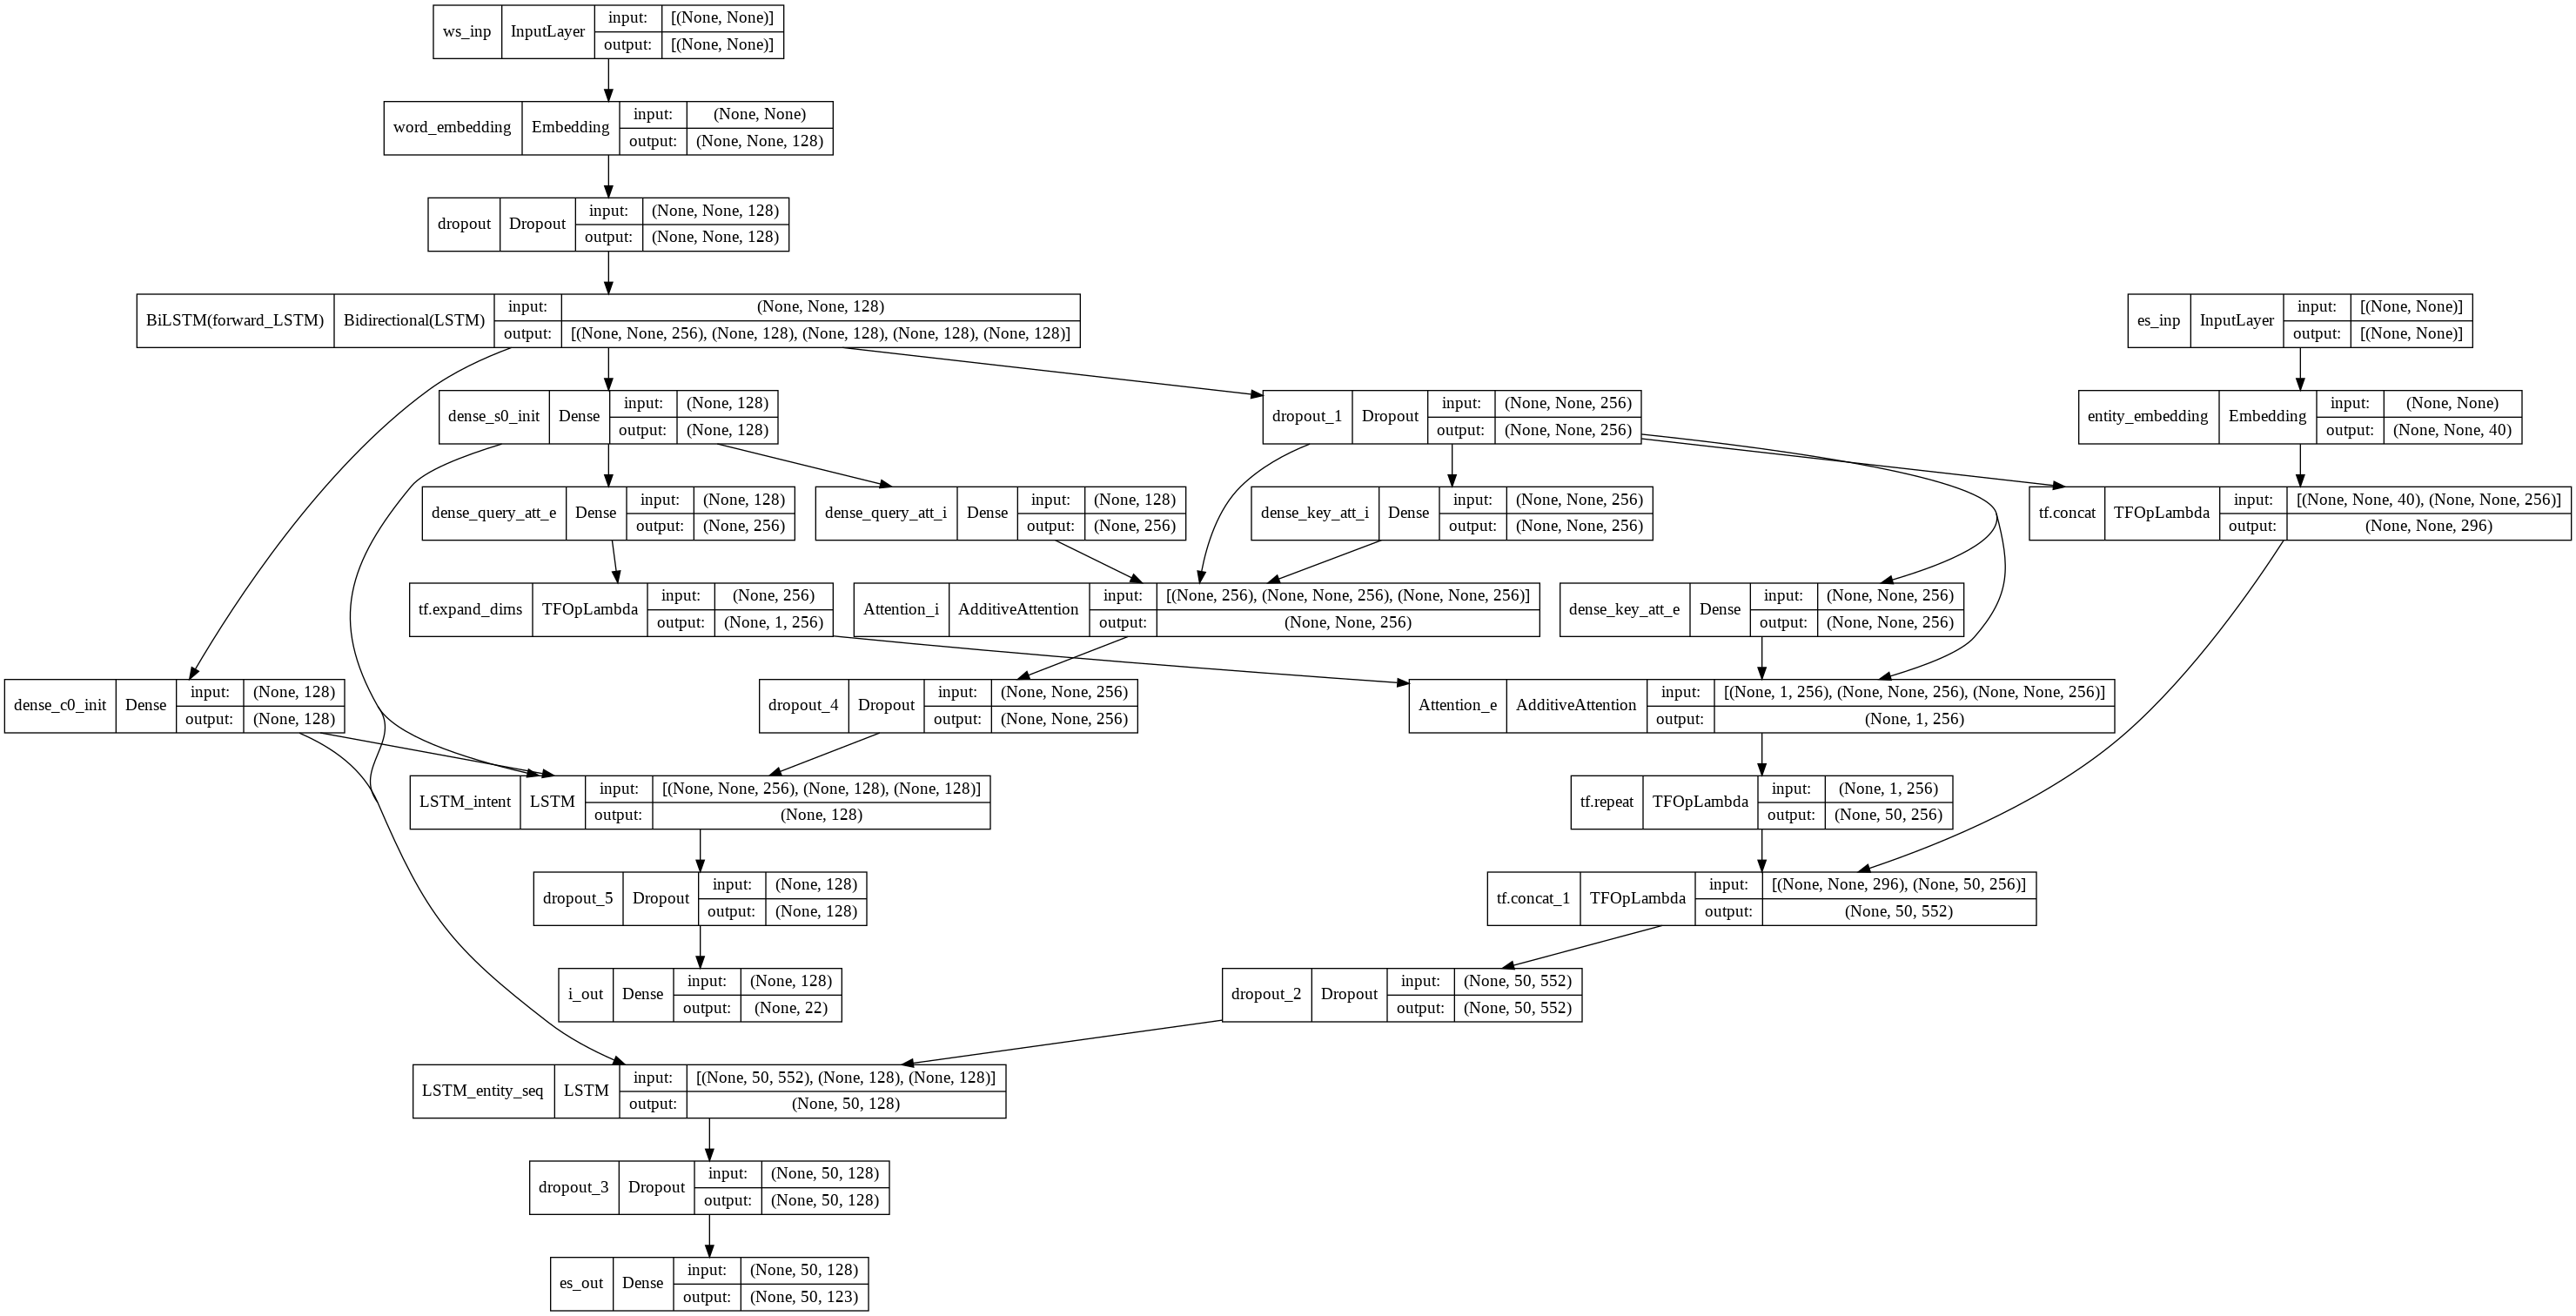

In [11]:
plot_model(model, to_file="model_seq2seq.png", show_shapes=True)

## 5. Entrenamiento

In [12]:
class F1Metrics(Callback):
  def __init__(self, id2label, val_data, pad_value=0):
    super(F1Metrics, self).__init__()
    self.id2label = id2label
    self.pad_value = pad_value
    self.validation_data = val_data
    self.is_fit = val_data is None

  def get_length(self, y):
    lens = [len([idx for idx in row if idx != self.pad_value]) for row in y]
    return lens

  def convert_idx_to_name(self, y, lens, padding):
    y_temp = []
    for row, l in zip(y, lens):
      row_temp = []
      if padding == 'pre':
        for idx in np.array(row[-l:-1]).tolist():
          if idx == self.pad_value:
            row_temp.append('O')
          elif idx == 1:
            row_temp.append('O')
          else:
            row_temp.append(self.id2label[idx])
        y_temp.append(row_temp)
      else:
        for idx in np.array(row[:(l-1)]).tolist():
          if idx == self.pad_value:
            row_temp.append('O')
          elif idx == 1:
            row_temp.append('O')
          else:
            row_temp.append(self.id2label[idx])
        y_temp.append(row_temp)
    return y_temp

  def predict(self, X, y):
    y_pred_slots, y_pred_intents = self.model.predict_on_batch(X)
    y_true_slots = y['es_out']
    y_true_intents = y['i_out']
    y_pred_slots = np.argmax(y_pred_slots, -1)
    y_pred_intents = np.argmax(y_pred_intents, -1)
    lens = self.get_length(y_true_slots)
    if np.array(y_true_slots[0]).tolist()[0] == 0:
      padding = 'pre'
    else:
      padding = 'post'
    y_true_slots = self.convert_idx_to_name(y_true_slots, lens, padding)
    y_pred_slots = self.convert_idx_to_name(y_pred_slots, lens, padding)
    return y_true_slots, y_true_intents, y_pred_slots, y_pred_intents

  def score(self, y_true, y_pred):
    score = f1_score(y_true, y_pred, mode='strict', scheme=IOB2)
    print(' - f1: {:04.2f}'.format(score * 100))
    print(classification_report(y_true, y_pred, digits=4, mode='strict', scheme=IOB2))
    return score

  def on_epoch_end(self, epoch, logs={}):
    if self.is_fit:
      self.on_epoch_end_fit(epoch, logs)
    else:
      self.on_epoch_end_fit_generator(epoch, logs)

  def on_epoch_end_fit(self, epoch, logs={}):
    X = self.validation_data[0]
    y = self.validation_data[1]
    y_true, y_pred = self.predict(X, y)
    score = self.score(y_true, y_pred)
    logs['f1'] = score

  def on_epoch_end_fit_generator(self, epoch, logs={}):
    y_true_slots = []
    y_pred_slots = []
    for X, y in self.validation_data:
      y_true_slots_batch, y_true_intents_batch, y_pred_slots_batch, y_pred_intents_batch = self.predict(X, y)
      y_true_slots.extend(y_true_slots_batch)
      y_pred_slots.extend(y_pred_slots_batch)
    slots_score = self.score(y_true_slots, y_pred_slots)
    intents_score = sklearn.metrics.f1_score(y_true_intents_batch, y_pred_intents_batch, average='micro')
    logs['slots_f1'] = slots_score
    logs['intent_f1'] = intents_score

f1score = F1Metrics(entity_tokenizer.index_word, val_dataset)

In [13]:
# Se entrena el modelo
epochs = 250

initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=len(train_dataset)*5, decay_rate=0.95, staircase=True)

model.compile(optimizer=Adam(learning_rate=lr_schedule, clipnorm=5), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

checkpoint = ModelCheckpoint('model-epoch:{epoch:02d}-loss:{loss:.3f}-val_loss:{val_loss:.3f}-slots_f1:{slots_f1:.3f}weights', monitor='slots_f1', mode='max')
early_stopping = EarlyStopping(monitor='slots_f1', patience=15, mode='max')
callbacks = [f1score, checkpoint, early_stopping]

history = model.fit(train_dataset, epochs=epochs, verbose=1, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/250
139/139 [==============================] - ETA: 0s - loss: 1.5875 - es_out_loss: 0.6684 - i_out_loss: 0.9191 - es_out_sparse_categorical_accuracy: 0.8770 - i_out_sparse_categorical_accuracy: 0.7855 - f1: 36.86
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         9
              airline_name     0.0000    0.0000    0.0000        56
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.0000    0.0000    0.0000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000         9
    arrive_date.day_number     0.0000    0.0000    0.0000         4
    arrive_date.month_name     0.0000    0.0000    0.0000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time   

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:01-loss:1.587-val_loss:1.172-slots_f1:0.369weights/assets


INFO:tensorflow:Assets written to: model-epoch:01-loss:1.587-val_loss:1.172-slots_f1:0.369weights/assets


139/139 [==============================] - 109s 683ms/step - loss: 1.5875 - es_out_loss: 0.6684 - i_out_loss: 0.9191 - es_out_sparse_categorical_accuracy: 0.8770 - i_out_sparse_categorical_accuracy: 0.7855 - val_loss: 1.1719 - val_es_out_loss: 0.3787 - val_i_out_loss: 0.7932 - val_es_out_sparse_categorical_accuracy: 0.9230 - val_i_out_sparse_categorical_accuracy: 0.8058 - slots_f1: 0.3686 - intent_f1: 0.8438
Epoch 2/250
139/139 [==============================] - ETA: 0s - loss: 0.8020 - es_out_loss: 0.3191 - i_out_loss: 0.4829 - es_out_sparse_categorical_accuracy: 0.9332 - i_out_sparse_categorical_accuracy: 0.8829 - f1: 47.63
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         7
              airline_name     0.0000    0.0000    0.0000        52
              airport_code     0.0000    0.0000    0.0000         3
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:02-loss:0.802-val_loss:0.873-slots_f1:0.476weights/assets


INFO:tensorflow:Assets written to: model-epoch:02-loss:0.802-val_loss:0.873-slots_f1:0.476weights/assets


139/139 [==============================] - 83s 596ms/step - loss: 0.8020 - es_out_loss: 0.3191 - i_out_loss: 0.4829 - es_out_sparse_categorical_accuracy: 0.9332 - i_out_sparse_categorical_accuracy: 0.8829 - val_loss: 0.8731 - val_es_out_loss: 0.2996 - val_i_out_loss: 0.5735 - val_es_out_sparse_categorical_accuracy: 0.9369 - val_i_out_sparse_categorical_accuracy: 0.8571 - slots_f1: 0.4763 - intent_f1: 0.8594
Epoch 3/250
139/139 [==============================] - ETA: 0s - loss: 0.6451 - es_out_loss: 0.2681 - i_out_loss: 0.3771 - es_out_sparse_categorical_accuracy: 0.9417 - i_out_sparse_categorical_accuracy: 0.9038 - f1: 51.70
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         6
              airline_name     0.0000    0.0000    0.0000        56
              airport_code     0.0000    0.0000    0.0000         4
              airport_name

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:03-loss:0.645-val_loss:0.756-slots_f1:0.517weights/assets


INFO:tensorflow:Assets written to: model-epoch:03-loss:0.645-val_loss:0.756-slots_f1:0.517weights/assets


139/139 [==============================] - 81s 584ms/step - loss: 0.6451 - es_out_loss: 0.2681 - i_out_loss: 0.3771 - es_out_sparse_categorical_accuracy: 0.9417 - i_out_sparse_categorical_accuracy: 0.9038 - val_loss: 0.7557 - val_es_out_loss: 0.2627 - val_i_out_loss: 0.4930 - val_es_out_sparse_categorical_accuracy: 0.9436 - val_i_out_sparse_categorical_accuracy: 0.8839 - slots_f1: 0.5170 - intent_f1: 0.9375
Epoch 4/250
139/139 [==============================] - ETA: 0s - loss: 0.5659 - es_out_loss: 0.2368 - i_out_loss: 0.3291 - es_out_sparse_categorical_accuracy: 0.9474 - i_out_sparse_categorical_accuracy: 0.9173 - f1: 55.34
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         8
              airline_name     0.2857    0.0339    0.0606        59
              airport_code     0.0000    0.0000    0.0000         4
              airport_name

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:04-loss:0.566-val_loss:0.689-slots_f1:0.553weights/assets


INFO:tensorflow:Assets written to: model-epoch:04-loss:0.566-val_loss:0.689-slots_f1:0.553weights/assets


139/139 [==============================] - 81s 588ms/step - loss: 0.5659 - es_out_loss: 0.2368 - i_out_loss: 0.3291 - es_out_sparse_categorical_accuracy: 0.9474 - i_out_sparse_categorical_accuracy: 0.9173 - val_loss: 0.6893 - val_es_out_loss: 0.2419 - val_i_out_loss: 0.4474 - val_es_out_sparse_categorical_accuracy: 0.9469 - val_i_out_sparse_categorical_accuracy: 0.9040 - slots_f1: 0.5534 - intent_f1: 0.9219
Epoch 5/250
139/139 [==============================] - ETA: 0s - loss: 0.4759 - es_out_loss: 0.2166 - i_out_loss: 0.2593 - es_out_sparse_categorical_accuracy: 0.9508 - i_out_sparse_categorical_accuracy: 0.9350 - f1: 58.66
                            precision    recall  f1-score   support

              airline_code     0.0000    0.0000    0.0000         7
              airline_name     0.2222    0.0364    0.0625        55
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.0000    0.0000    0.0000         4
 arrive_date.date_relative

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:05-loss:0.476-val_loss:0.549-slots_f1:0.587weights/assets


INFO:tensorflow:Assets written to: model-epoch:05-loss:0.476-val_loss:0.549-slots_f1:0.587weights/assets


139/139 [==============================] - 83s 598ms/step - loss: 0.4759 - es_out_loss: 0.2166 - i_out_loss: 0.2593 - es_out_sparse_categorical_accuracy: 0.9508 - i_out_sparse_categorical_accuracy: 0.9350 - val_loss: 0.5491 - val_es_out_loss: 0.2238 - val_i_out_loss: 0.3253 - val_es_out_sparse_categorical_accuracy: 0.9505 - val_i_out_sparse_categorical_accuracy: 0.9263 - slots_f1: 0.5866 - intent_f1: 0.9375
Epoch 6/250
139/139 [==============================] - ETA: 0s - loss: 0.4170 - es_out_loss: 0.2018 - i_out_loss: 0.2152 - es_out_sparse_categorical_accuracy: 0.9538 - i_out_sparse_categorical_accuracy: 0.9404 - f1: 59.53
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         8
              airline_name     0.2381    0.0847    0.1250        59
              airport_code     0.0000    0.0000    0.0000         4
              airport_name

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:06-loss:0.417-val_loss:0.588-slots_f1:0.595weights/assets


INFO:tensorflow:Assets written to: model-epoch:06-loss:0.417-val_loss:0.588-slots_f1:0.595weights/assets


139/139 [==============================] - 84s 608ms/step - loss: 0.4170 - es_out_loss: 0.2018 - i_out_loss: 0.2152 - es_out_sparse_categorical_accuracy: 0.9538 - i_out_sparse_categorical_accuracy: 0.9404 - val_loss: 0.5876 - val_es_out_loss: 0.2068 - val_i_out_loss: 0.3807 - val_es_out_sparse_categorical_accuracy: 0.9537 - val_i_out_sparse_categorical_accuracy: 0.9174 - slots_f1: 0.5953 - intent_f1: 0.8906
Epoch 7/250
139/139 [==============================] - ETA: 0s - loss: 0.3924 - es_out_loss: 0.1914 - i_out_loss: 0.2011 - es_out_sparse_categorical_accuracy: 0.9555 - i_out_sparse_categorical_accuracy: 0.9454 - f1: 61.86
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         7
              airline_name     0.3333    0.1400    0.1972        50
              airport_code     0.0000    0.0000    0.0000         4
              airport_name

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:07-loss:0.392-val_loss:0.498-slots_f1:0.619weights/assets


INFO:tensorflow:Assets written to: model-epoch:07-loss:0.392-val_loss:0.498-slots_f1:0.619weights/assets


139/139 [==============================] - 83s 599ms/step - loss: 0.3924 - es_out_loss: 0.1914 - i_out_loss: 0.2011 - es_out_sparse_categorical_accuracy: 0.9555 - i_out_sparse_categorical_accuracy: 0.9454 - val_loss: 0.4976 - val_es_out_loss: 0.2072 - val_i_out_loss: 0.2904 - val_es_out_sparse_categorical_accuracy: 0.9521 - val_i_out_sparse_categorical_accuracy: 0.9241 - slots_f1: 0.6186 - intent_f1: 0.9375
Epoch 8/250
139/139 [==============================] - ETA: 0s - loss: 0.3661 - es_out_loss: 0.1834 - i_out_loss: 0.1827 - es_out_sparse_categorical_accuracy: 0.9571 - i_out_sparse_categorical_accuracy: 0.9514 - f1: 59.11
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         9
              airline_name     0.3333    0.0690    0.1143        58
              airport_code     0.0000    0.0000    0.0000         3
              airport_name

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:08-loss:0.366-val_loss:0.529-slots_f1:0.591weights/assets


INFO:tensorflow:Assets written to: model-epoch:08-loss:0.366-val_loss:0.529-slots_f1:0.591weights/assets


139/139 [==============================] - 80s 578ms/step - loss: 0.3661 - es_out_loss: 0.1834 - i_out_loss: 0.1827 - es_out_sparse_categorical_accuracy: 0.9571 - i_out_sparse_categorical_accuracy: 0.9514 - val_loss: 0.5286 - val_es_out_loss: 0.1972 - val_i_out_loss: 0.3314 - val_es_out_sparse_categorical_accuracy: 0.9539 - val_i_out_sparse_categorical_accuracy: 0.9219 - slots_f1: 0.5911 - intent_f1: 0.8750
Epoch 9/250
139/139 [==============================] - ETA: 0s - loss: 0.3433 - es_out_loss: 0.1757 - i_out_loss: 0.1676 - es_out_sparse_categorical_accuracy: 0.9584 - i_out_sparse_categorical_accuracy: 0.9575 - f1: 65.94
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         7
              airline_name     0.3571    0.1852    0.2439        54
              airport_code     0.0000    0.0000    0.0000         4
              airport_name

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:09-loss:0.343-val_loss:0.419-slots_f1:0.659weights/assets


INFO:tensorflow:Assets written to: model-epoch:09-loss:0.343-val_loss:0.419-slots_f1:0.659weights/assets


139/139 [==============================] - 81s 584ms/step - loss: 0.3433 - es_out_loss: 0.1757 - i_out_loss: 0.1676 - es_out_sparse_categorical_accuracy: 0.9584 - i_out_sparse_categorical_accuracy: 0.9575 - val_loss: 0.4193 - val_es_out_loss: 0.1860 - val_i_out_loss: 0.2333 - val_es_out_sparse_categorical_accuracy: 0.9579 - val_i_out_sparse_categorical_accuracy: 0.9509 - slots_f1: 0.6594 - intent_f1: 0.9531
Epoch 10/250
139/139 [==============================] - ETA: 0s - loss: 0.3169 - es_out_loss: 0.1689 - i_out_loss: 0.1480 - es_out_sparse_categorical_accuracy: 0.9596 - i_out_sparse_categorical_accuracy: 0.9620 - f1: 64.76
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         9
              airline_name     0.3529    0.1071    0.1644        56
              airport_code     0.0000    0.0000    0.0000         3
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:10-loss:0.317-val_loss:0.469-slots_f1:0.648weights/assets


INFO:tensorflow:Assets written to: model-epoch:10-loss:0.317-val_loss:0.469-slots_f1:0.648weights/assets


139/139 [==============================] - 81s 584ms/step - loss: 0.3169 - es_out_loss: 0.1689 - i_out_loss: 0.1480 - es_out_sparse_categorical_accuracy: 0.9596 - i_out_sparse_categorical_accuracy: 0.9620 - val_loss: 0.4693 - val_es_out_loss: 0.1812 - val_i_out_loss: 0.2882 - val_es_out_sparse_categorical_accuracy: 0.9585 - val_i_out_sparse_categorical_accuracy: 0.9330 - slots_f1: 0.6476 - intent_f1: 0.9531
Epoch 11/250
139/139 [==============================] - ETA: 0s - loss: 0.2817 - es_out_loss: 0.1640 - i_out_loss: 0.1177 - es_out_sparse_categorical_accuracy: 0.9609 - i_out_sparse_categorical_accuracy: 0.9701 - f1: 63.16
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         9
              airline_name     0.3143    0.2075    0.2500        53
              airport_code     0.0000    0.0000    0.0000         4
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:11-loss:0.282-val_loss:0.476-slots_f1:0.632weights/assets


INFO:tensorflow:Assets written to: model-epoch:11-loss:0.282-val_loss:0.476-slots_f1:0.632weights/assets


139/139 [==============================] - 80s 578ms/step - loss: 0.2817 - es_out_loss: 0.1640 - i_out_loss: 0.1177 - es_out_sparse_categorical_accuracy: 0.9609 - i_out_sparse_categorical_accuracy: 0.9701 - val_loss: 0.4761 - val_es_out_loss: 0.1796 - val_i_out_loss: 0.2965 - val_es_out_sparse_categorical_accuracy: 0.9586 - val_i_out_sparse_categorical_accuracy: 0.9286 - slots_f1: 0.6316 - intent_f1: 0.9531
Epoch 12/250
139/139 [==============================] - ETA: 0s - loss: 0.2751 - es_out_loss: 0.1595 - i_out_loss: 0.1157 - es_out_sparse_categorical_accuracy: 0.9616 - i_out_sparse_categorical_accuracy: 0.9685 - f1: 65.16
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         8
              airline_name     0.4167    0.1852    0.2564        54
              airport_code     0.0000    0.0000    0.0000         3
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:12-loss:0.275-val_loss:0.424-slots_f1:0.652weights/assets


INFO:tensorflow:Assets written to: model-epoch:12-loss:0.275-val_loss:0.424-slots_f1:0.652weights/assets


139/139 [==============================] - 79s 574ms/step - loss: 0.2751 - es_out_loss: 0.1595 - i_out_loss: 0.1157 - es_out_sparse_categorical_accuracy: 0.9616 - i_out_sparse_categorical_accuracy: 0.9685 - val_loss: 0.4241 - val_es_out_loss: 0.1700 - val_i_out_loss: 0.2541 - val_es_out_sparse_categorical_accuracy: 0.9596 - val_i_out_sparse_categorical_accuracy: 0.9464 - slots_f1: 0.6516 - intent_f1: 0.9375
Epoch 13/250
139/139 [==============================] - ETA: 0s - loss: 0.2504 - es_out_loss: 0.1544 - i_out_loss: 0.0960 - es_out_sparse_categorical_accuracy: 0.9622 - i_out_sparse_categorical_accuracy: 0.9755 - f1: 66.26
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         9
              airline_name     0.4516    0.2456    0.3182        57
              airport_code     0.0000    0.0000    0.0000         3
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:13-loss:0.250-val_loss:0.427-slots_f1:0.663weights/assets


INFO:tensorflow:Assets written to: model-epoch:13-loss:0.250-val_loss:0.427-slots_f1:0.663weights/assets


139/139 [==============================] - 80s 581ms/step - loss: 0.2504 - es_out_loss: 0.1544 - i_out_loss: 0.0960 - es_out_sparse_categorical_accuracy: 0.9622 - i_out_sparse_categorical_accuracy: 0.9755 - val_loss: 0.4271 - val_es_out_loss: 0.1650 - val_i_out_loss: 0.2622 - val_es_out_sparse_categorical_accuracy: 0.9615 - val_i_out_sparse_categorical_accuracy: 0.9464 - slots_f1: 0.6626 - intent_f1: 0.9531
Epoch 14/250
139/139 [==============================] - ETA: 0s - loss: 0.2557 - es_out_loss: 0.1499 - i_out_loss: 0.1058 - es_out_sparse_categorical_accuracy: 0.9630 - i_out_sparse_categorical_accuracy: 0.9737 - f1: 65.79
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         9
              airline_name     0.3830    0.3051    0.3396        59
              airport_code     0.0000    0.0000    0.0000         3
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:14-loss:0.256-val_loss:0.486-slots_f1:0.658weights/assets


INFO:tensorflow:Assets written to: model-epoch:14-loss:0.256-val_loss:0.486-slots_f1:0.658weights/assets


139/139 [==============================] - 79s 574ms/step - loss: 0.2557 - es_out_loss: 0.1499 - i_out_loss: 0.1058 - es_out_sparse_categorical_accuracy: 0.9630 - i_out_sparse_categorical_accuracy: 0.9737 - val_loss: 0.4862 - val_es_out_loss: 0.1684 - val_i_out_loss: 0.3178 - val_es_out_sparse_categorical_accuracy: 0.9602 - val_i_out_sparse_categorical_accuracy: 0.9330 - slots_f1: 0.6579 - intent_f1: 0.9531
Epoch 15/250
139/139 [==============================] - ETA: 0s - loss: 0.2394 - es_out_loss: 0.1468 - i_out_loss: 0.0926 - es_out_sparse_categorical_accuracy: 0.9639 - i_out_sparse_categorical_accuracy: 0.9766 - f1: 67.17
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3333    0.1111    0.1667         9
              airline_name     0.4412    0.2632    0.3297        57
              airport_code     0.0000    0.0000    0.0000         4
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:15-loss:0.239-val_loss:0.387-slots_f1:0.672weights/assets


INFO:tensorflow:Assets written to: model-epoch:15-loss:0.239-val_loss:0.387-slots_f1:0.672weights/assets


139/139 [==============================] - 80s 579ms/step - loss: 0.2394 - es_out_loss: 0.1468 - i_out_loss: 0.0926 - es_out_sparse_categorical_accuracy: 0.9639 - i_out_sparse_categorical_accuracy: 0.9766 - val_loss: 0.3867 - val_es_out_loss: 0.1597 - val_i_out_loss: 0.2270 - val_es_out_sparse_categorical_accuracy: 0.9617 - val_i_out_sparse_categorical_accuracy: 0.9576 - slots_f1: 0.6717 - intent_f1: 0.9375
Epoch 16/250
139/139 [==============================] - ETA: 0s - loss: 0.2279 - es_out_loss: 0.1447 - i_out_loss: 0.0831 - es_out_sparse_categorical_accuracy: 0.9639 - i_out_sparse_categorical_accuracy: 0.9793 - f1: 66.69
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         8
              airline_name     0.3243    0.2353    0.2727        51
              airport_code     0.0000    0.0000    0.0000         4
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:16-loss:0.228-val_loss:0.384-slots_f1:0.667weights/assets


INFO:tensorflow:Assets written to: model-epoch:16-loss:0.228-val_loss:0.384-slots_f1:0.667weights/assets


139/139 [==============================] - 81s 583ms/step - loss: 0.2279 - es_out_loss: 0.1447 - i_out_loss: 0.0831 - es_out_sparse_categorical_accuracy: 0.9639 - i_out_sparse_categorical_accuracy: 0.9793 - val_loss: 0.3836 - val_es_out_loss: 0.1596 - val_i_out_loss: 0.2240 - val_es_out_sparse_categorical_accuracy: 0.9617 - val_i_out_sparse_categorical_accuracy: 0.9420 - slots_f1: 0.6669 - intent_f1: 0.9531
Epoch 17/250
139/139 [==============================] - ETA: 0s - loss: 0.2238 - es_out_loss: 0.1411 - i_out_loss: 0.0827 - es_out_sparse_categorical_accuracy: 0.9649 - i_out_sparse_categorical_accuracy: 0.9771 - f1: 67.24
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         9
              airline_name     0.4815    0.2364    0.3171        55
              airport_code     0.0000    0.0000    0.0000         4
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:17-loss:0.224-val_loss:0.359-slots_f1:0.672weights/assets


INFO:tensorflow:Assets written to: model-epoch:17-loss:0.224-val_loss:0.359-slots_f1:0.672weights/assets


139/139 [==============================] - 80s 577ms/step - loss: 0.2238 - es_out_loss: 0.1411 - i_out_loss: 0.0827 - es_out_sparse_categorical_accuracy: 0.9649 - i_out_sparse_categorical_accuracy: 0.9771 - val_loss: 0.3588 - val_es_out_loss: 0.1548 - val_i_out_loss: 0.2040 - val_es_out_sparse_categorical_accuracy: 0.9625 - val_i_out_sparse_categorical_accuracy: 0.9554 - slots_f1: 0.6724 - intent_f1: 0.9844
Epoch 18/250
139/139 [==============================] - ETA: 0s - loss: 0.2129 - es_out_loss: 0.1366 - i_out_loss: 0.0763 - es_out_sparse_categorical_accuracy: 0.9660 - i_out_sparse_categorical_accuracy: 0.9789 - f1: 68.24
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         8
              airline_name     0.4571    0.2759    0.3441        58
              airport_code     0.0000    0.0000    0.0000         3
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:18-loss:0.213-val_loss:0.371-slots_f1:0.682weights/assets


INFO:tensorflow:Assets written to: model-epoch:18-loss:0.213-val_loss:0.371-slots_f1:0.682weights/assets


139/139 [==============================] - 81s 589ms/step - loss: 0.2129 - es_out_loss: 0.1366 - i_out_loss: 0.0763 - es_out_sparse_categorical_accuracy: 0.9660 - i_out_sparse_categorical_accuracy: 0.9789 - val_loss: 0.3713 - val_es_out_loss: 0.1543 - val_i_out_loss: 0.2170 - val_es_out_sparse_categorical_accuracy: 0.9640 - val_i_out_sparse_categorical_accuracy: 0.9576 - slots_f1: 0.6824 - intent_f1: 0.9531
Epoch 19/250
139/139 [==============================] - ETA: 0s - loss: 0.1996 - es_out_loss: 0.1337 - i_out_loss: 0.0658 - es_out_sparse_categorical_accuracy: 0.9666 - i_out_sparse_categorical_accuracy: 0.9845 - f1: 68.47


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         7
              airline_name     0.5938    0.3725    0.4578        51
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     1.0000    0.3333    0.5000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000         9
    arrive_date.day_number     0.6667    1.0000    0.8000         2
    arrive_date.month_name     0.0000    0.0000    0.0000         2
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.0000    0.0000    0.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.0000    0.0000    0.0000        12
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:19-loss:0.200-val_loss:0.415-slots_f1:0.685weights/assets


139/139 [==============================] - 80s 578ms/step - loss: 0.1996 - es_out_loss: 0.1337 - i_out_loss: 0.0658 - es_out_sparse_categorical_accuracy: 0.9666 - i_out_sparse_categorical_accuracy: 0.9845 - val_loss: 0.4154 - val_es_out_loss: 0.1504 - val_i_out_loss: 0.2649 - val_es_out_sparse_categorical_accuracy: 0.9635 - val_i_out_sparse_categorical_accuracy: 0.9509 - slots_f1: 0.6847 - intent_f1: 0.9219
Epoch 20/250
139/139 [==============================] - ETA: 0s - loss: 0.1948 - es_out_loss: 0.1318 - i_out_loss: 0.0629 - es_out_sparse_categorical_accuracy: 0.9668 - i_out_sparse_categorical_accuracy: 0.9834 - f1: 69.95
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         9
              airline_name     0.4474    0.3269    0.3778        52
              airport_code     0.0000    0.0000    0.0000         4
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:20-loss:0.195-val_loss:0.386-slots_f1:0.700weights/assets


INFO:tensorflow:Assets written to: model-epoch:20-loss:0.195-val_loss:0.386-slots_f1:0.700weights/assets


139/139 [==============================] - 81s 585ms/step - loss: 0.1948 - es_out_loss: 0.1318 - i_out_loss: 0.0629 - es_out_sparse_categorical_accuracy: 0.9668 - i_out_sparse_categorical_accuracy: 0.9834 - val_loss: 0.3857 - val_es_out_loss: 0.1525 - val_i_out_loss: 0.2332 - val_es_out_sparse_categorical_accuracy: 0.9633 - val_i_out_sparse_categorical_accuracy: 0.9554 - slots_f1: 0.6995 - intent_f1: 0.9219
Epoch 21/250
139/139 [==============================] - ETA: 0s - loss: 0.2036 - es_out_loss: 0.1299 - i_out_loss: 0.0737 - es_out_sparse_categorical_accuracy: 0.9673 - i_out_sparse_categorical_accuracy: 0.9798 - f1: 69.41


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         5
              airline_name     0.4000    0.2373    0.2979        59
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     1.0000    0.5000    0.6667         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.0000    0.0000    0.0000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.0000    0.0000    0.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     1.0000    0.1538    0.2667        13
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:21-loss:0.204-val_loss:0.381-slots_f1:0.694weights/assets


139/139 [==============================] - 81s 588ms/step - loss: 0.2036 - es_out_loss: 0.1299 - i_out_loss: 0.0737 - es_out_sparse_categorical_accuracy: 0.9673 - i_out_sparse_categorical_accuracy: 0.9798 - val_loss: 0.3805 - val_es_out_loss: 0.1438 - val_i_out_loss: 0.2367 - val_es_out_sparse_categorical_accuracy: 0.9657 - val_i_out_sparse_categorical_accuracy: 0.9531 - slots_f1: 0.6941 - intent_f1: 0.9219
Epoch 22/250
139/139 [==============================] - ETA: 0s - loss: 0.1911 - es_out_loss: 0.1272 - i_out_loss: 0.0639 - es_out_sparse_categorical_accuracy: 0.9675 - i_out_sparse_categorical_accuracy: 0.9829 - f1: 69.88
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         8
              airline_name     0.4444    0.2909    0.3516        55
              airport_code     0.5000    0.2500    0.3333         4
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:22-loss:0.191-val_loss:0.340-slots_f1:0.699weights/assets


INFO:tensorflow:Assets written to: model-epoch:22-loss:0.191-val_loss:0.340-slots_f1:0.699weights/assets


139/139 [==============================] - 81s 585ms/step - loss: 0.1911 - es_out_loss: 0.1272 - i_out_loss: 0.0639 - es_out_sparse_categorical_accuracy: 0.9675 - i_out_sparse_categorical_accuracy: 0.9829 - val_loss: 0.3398 - val_es_out_loss: 0.1421 - val_i_out_loss: 0.1978 - val_es_out_sparse_categorical_accuracy: 0.9652 - val_i_out_sparse_categorical_accuracy: 0.9554 - slots_f1: 0.6988 - intent_f1: 0.9688
Epoch 23/250
139/139 [==============================] - ETA: 0s - loss: 0.1829 - es_out_loss: 0.1259 - i_out_loss: 0.0570 - es_out_sparse_categorical_accuracy: 0.9679 - i_out_sparse_categorical_accuracy: 0.9831 - f1: 70.30


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     1.0000    0.2222    0.3636         9
              airline_name     0.4878    0.3704    0.4211        54
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     1.0000    0.3333    0.5000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000        10
    arrive_date.day_number     1.0000    0.6667    0.8000         3
    arrive_date.month_name     0.0000    0.0000    0.0000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.0000    0.0000    0.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.0000    0.0000    0.0000        10
    arrive_time.start_time     1.0000    0.3333

INFO:tensorflow:Assets written to: model-epoch:23-loss:0.183-val_loss:0.395-slots_f1:0.703weights/assets


INFO:tensorflow:Assets written to: model-epoch:23-loss:0.183-val_loss:0.395-slots_f1:0.703weights/assets


139/139 [==============================] - 80s 579ms/step - loss: 0.1829 - es_out_loss: 0.1259 - i_out_loss: 0.0570 - es_out_sparse_categorical_accuracy: 0.9679 - i_out_sparse_categorical_accuracy: 0.9831 - val_loss: 0.3950 - val_es_out_loss: 0.1424 - val_i_out_loss: 0.2525 - val_es_out_sparse_categorical_accuracy: 0.9642 - val_i_out_sparse_categorical_accuracy: 0.9420 - slots_f1: 0.7030 - intent_f1: 0.9688
Epoch 24/250
139/139 [==============================] - ETA: 0s - loss: 0.1851 - es_out_loss: 0.1245 - i_out_loss: 0.0606 - es_out_sparse_categorical_accuracy: 0.9685 - i_out_sparse_categorical_accuracy: 0.9849 - f1: 71.53
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.1111    0.1818         9
              airline_name     0.6176    0.3750    0.4667        56
              airport_code     0.0000    0.0000    0.0000         4
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:24-loss:0.185-val_loss:0.380-slots_f1:0.715weights/assets


INFO:tensorflow:Assets written to: model-epoch:24-loss:0.185-val_loss:0.380-slots_f1:0.715weights/assets


139/139 [==============================] - 81s 584ms/step - loss: 0.1851 - es_out_loss: 0.1245 - i_out_loss: 0.0606 - es_out_sparse_categorical_accuracy: 0.9685 - i_out_sparse_categorical_accuracy: 0.9849 - val_loss: 0.3796 - val_es_out_loss: 0.1420 - val_i_out_loss: 0.2376 - val_es_out_sparse_categorical_accuracy: 0.9647 - val_i_out_sparse_categorical_accuracy: 0.9598 - slots_f1: 0.7153 - intent_f1: 0.9062
Epoch 25/250
139/139 [==============================] - ETA: 0s - loss: 0.1719 - es_out_loss: 0.1218 - i_out_loss: 0.0500 - es_out_sparse_categorical_accuracy: 0.9689 - i_out_sparse_categorical_accuracy: 0.9861 - f1: 70.61


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         9
              airline_name     0.4375    0.3889    0.4118        54
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.0000    0.0000    0.0000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.0000    0.0000    0.0000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.0000    0.0000    0.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5000    0.0769    0.1333        13
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:25-loss:0.172-val_loss:0.359-slots_f1:0.706weights/assets


INFO:tensorflow:Assets written to: model-epoch:25-loss:0.172-val_loss:0.359-slots_f1:0.706weights/assets


139/139 [==============================] - 81s 583ms/step - loss: 0.1719 - es_out_loss: 0.1218 - i_out_loss: 0.0500 - es_out_sparse_categorical_accuracy: 0.9689 - i_out_sparse_categorical_accuracy: 0.9861 - val_loss: 0.3589 - val_es_out_loss: 0.1334 - val_i_out_loss: 0.2255 - val_es_out_sparse_categorical_accuracy: 0.9663 - val_i_out_sparse_categorical_accuracy: 0.9509 - slots_f1: 0.7061 - intent_f1: 0.9531
Epoch 26/250
139/139 [==============================] - ETA: 0s - loss: 0.1754 - es_out_loss: 0.1198 - i_out_loss: 0.0555 - es_out_sparse_categorical_accuracy: 0.9689 - i_out_sparse_categorical_accuracy: 0.9858 - f1: 72.09


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         7
              airline_name     0.4468    0.3962    0.4200        53
              airport_code     0.0000    0.0000    0.0000         2
              airport_name     0.4000    0.5000    0.4444         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000         8
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.0000    0.0000    0.0000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.0000    0.0000    0.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5000    0.0769    0.1333        13
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:26-loss:0.175-val_loss:0.393-slots_f1:0.721weights/assets


INFO:tensorflow:Assets written to: model-epoch:26-loss:0.175-val_loss:0.393-slots_f1:0.721weights/assets


139/139 [==============================] - 81s 589ms/step - loss: 0.1754 - es_out_loss: 0.1198 - i_out_loss: 0.0555 - es_out_sparse_categorical_accuracy: 0.9689 - i_out_sparse_categorical_accuracy: 0.9858 - val_loss: 0.3929 - val_es_out_loss: 0.1335 - val_i_out_loss: 0.2593 - val_es_out_sparse_categorical_accuracy: 0.9679 - val_i_out_sparse_categorical_accuracy: 0.9598 - slots_f1: 0.7209 - intent_f1: 0.9375
Epoch 27/250
139/139 [==============================] - ETA: 0s - loss: 0.1672 - es_out_loss: 0.1175 - i_out_loss: 0.0496 - es_out_sparse_categorical_accuracy: 0.9697 - i_out_sparse_categorical_accuracy: 0.9863 - f1: 70.89


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.1111    0.1818         9
              airline_name     0.4667    0.3684    0.4118        57
              airport_code     0.5000    0.3333    0.4000         3
              airport_name     0.0000    0.0000    0.0000         1
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.3333    0.2500    0.2857         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.0000    0.0000    0.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.0000    0.0000    0.0000        12
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:27-loss:0.167-val_loss:0.326-slots_f1:0.709weights/assets


INFO:tensorflow:Assets written to: model-epoch:27-loss:0.167-val_loss:0.326-slots_f1:0.709weights/assets


139/139 [==============================] - 82s 590ms/step - loss: 0.1672 - es_out_loss: 0.1175 - i_out_loss: 0.0496 - es_out_sparse_categorical_accuracy: 0.9697 - i_out_sparse_categorical_accuracy: 0.9863 - val_loss: 0.3264 - val_es_out_loss: 0.1387 - val_i_out_loss: 0.1876 - val_es_out_sparse_categorical_accuracy: 0.9666 - val_i_out_sparse_categorical_accuracy: 0.9554 - slots_f1: 0.7089 - intent_f1: 0.9375
Epoch 28/250
139/139 [==============================] - ETA: 0s - loss: 0.1605 - es_out_loss: 0.1151 - i_out_loss: 0.0454 - es_out_sparse_categorical_accuracy: 0.9704 - i_out_sparse_categorical_accuracy: 0.9888 - f1: 70.44


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         9
              airline_name     0.5455    0.3273    0.4091        55
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.6667    0.5000    0.5714         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000         8
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.0000    0.0000    0.0000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.5000    0.5000    0.5000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.0000    0.0000    0.0000        11
    arrive_time.start_time     1.0000    0.5000

INFO:tensorflow:Assets written to: model-epoch:28-loss:0.161-val_loss:0.415-slots_f1:0.704weights/assets


139/139 [==============================] - 81s 586ms/step - loss: 0.1605 - es_out_loss: 0.1151 - i_out_loss: 0.0454 - es_out_sparse_categorical_accuracy: 0.9704 - i_out_sparse_categorical_accuracy: 0.9888 - val_loss: 0.4153 - val_es_out_loss: 0.1320 - val_i_out_loss: 0.2833 - val_es_out_sparse_categorical_accuracy: 0.9674 - val_i_out_sparse_categorical_accuracy: 0.9487 - slots_f1: 0.7044 - intent_f1: 0.9219
Epoch 29/250
139/139 [==============================] - ETA: 0s - loss: 0.1596 - es_out_loss: 0.1140 - i_out_loss: 0.0456 - es_out_sparse_categorical_accuracy: 0.9704 - i_out_sparse_categorical_accuracy: 0.9867 - f1: 71.82
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     1.0000    0.1111    0.2000         9
              airline_name     0.4762    0.3636    0.4124        55
              airport_code     0.0000    0.0000    0.0000         3
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:29-loss:0.160-val_loss:0.381-slots_f1:0.718weights/assets


INFO:tensorflow:Assets written to: model-epoch:29-loss:0.160-val_loss:0.381-slots_f1:0.718weights/assets


139/139 [==============================] - 82s 592ms/step - loss: 0.1596 - es_out_loss: 0.1140 - i_out_loss: 0.0456 - es_out_sparse_categorical_accuracy: 0.9704 - i_out_sparse_categorical_accuracy: 0.9867 - val_loss: 0.3813 - val_es_out_loss: 0.1357 - val_i_out_loss: 0.2456 - val_es_out_sparse_categorical_accuracy: 0.9676 - val_i_out_sparse_categorical_accuracy: 0.9509 - slots_f1: 0.7182 - intent_f1: 0.9375
Epoch 30/250
139/139 [==============================] - ETA: 0s - loss: 0.1549 - es_out_loss: 0.1126 - i_out_loss: 0.0423 - es_out_sparse_categorical_accuracy: 0.9707 - i_out_sparse_categorical_accuracy: 0.9901 - f1: 70.92


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         7
              airline_name     0.4565    0.3818    0.4158        55
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.0000    0.0000    0.0000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000        10
    arrive_date.day_number     0.7500    0.7500    0.7500         4
    arrive_date.month_name     1.0000    0.2500    0.4000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.0000    0.0000    0.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.2500    0.0833    0.1250        12
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:30-loss:0.155-val_loss:0.386-slots_f1:0.709weights/assets


139/139 [==============================] - 82s 590ms/step - loss: 0.1549 - es_out_loss: 0.1126 - i_out_loss: 0.0423 - es_out_sparse_categorical_accuracy: 0.9707 - i_out_sparse_categorical_accuracy: 0.9901 - val_loss: 0.3857 - val_es_out_loss: 0.1306 - val_i_out_loss: 0.2552 - val_es_out_sparse_categorical_accuracy: 0.9677 - val_i_out_sparse_categorical_accuracy: 0.9442 - slots_f1: 0.7092 - intent_f1: 0.9688
Epoch 31/250
139/139 [==============================] - ETA: 0s - loss: 0.1412 - es_out_loss: 0.1096 - i_out_loss: 0.0316 - es_out_sparse_categorical_accuracy: 0.9711 - i_out_sparse_categorical_accuracy: 0.9888 - f1: 73.09
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.2500    0.3333         8
              airline_name     0.4000    0.3571    0.3774        56
              airport_code     0.5000    0.3333    0.4000         3
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:31-loss:0.141-val_loss:0.364-slots_f1:0.731weights/assets


INFO:tensorflow:Assets written to: model-epoch:31-loss:0.141-val_loss:0.364-slots_f1:0.731weights/assets


139/139 [==============================] - 81s 586ms/step - loss: 0.1412 - es_out_loss: 0.1096 - i_out_loss: 0.0316 - es_out_sparse_categorical_accuracy: 0.9711 - i_out_sparse_categorical_accuracy: 0.9888 - val_loss: 0.3639 - val_es_out_loss: 0.1286 - val_i_out_loss: 0.2353 - val_es_out_sparse_categorical_accuracy: 0.9675 - val_i_out_sparse_categorical_accuracy: 0.9554 - slots_f1: 0.7309 - intent_f1: 0.9219
Epoch 32/250
139/139 [==============================] - ETA: 0s - loss: 0.1452 - es_out_loss: 0.1085 - i_out_loss: 0.0367 - es_out_sparse_categorical_accuracy: 0.9715 - i_out_sparse_categorical_accuracy: 0.9888 - f1: 71.69


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         9
              airline_name     0.5526    0.3750    0.4468        56
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.3333    0.2500    0.2857         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.1111    0.1818         9
    arrive_date.day_number     1.0000    0.6667    0.8000         3
    arrive_date.month_name     1.0000    0.3333    0.5000         3
      arrive_time.end_time     0.5000    0.3333    0.4000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.3333    0.0833    0.1333        12
    arrive_time.start_time     0.0000    0.0000    0.0000         3
          arrive_time.time     0.7857    0.6875

INFO:tensorflow:Assets written to: model-epoch:32-loss:0.145-val_loss:0.366-slots_f1:0.717weights/assets


INFO:tensorflow:Assets written to: model-epoch:32-loss:0.145-val_loss:0.366-slots_f1:0.717weights/assets


139/139 [==============================] - 82s 591ms/step - loss: 0.1452 - es_out_loss: 0.1085 - i_out_loss: 0.0367 - es_out_sparse_categorical_accuracy: 0.9715 - i_out_sparse_categorical_accuracy: 0.9888 - val_loss: 0.3655 - val_es_out_loss: 0.1265 - val_i_out_loss: 0.2390 - val_es_out_sparse_categorical_accuracy: 0.9688 - val_i_out_sparse_categorical_accuracy: 0.9487 - slots_f1: 0.7169 - intent_f1: 0.9531
Epoch 33/250
139/139 [==============================] - ETA: 0s - loss: 0.1405 - es_out_loss: 0.1079 - i_out_loss: 0.0326 - es_out_sparse_categorical_accuracy: 0.9721 - i_out_sparse_categorical_accuracy: 0.9906 - f1: 72.29


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         8
              airline_name     0.4884    0.3621    0.4158        58
              airport_code     0.0000    0.0000    0.0000         2
              airport_name     0.0000    0.0000    0.0000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.0000    0.0000    0.0000         9
    arrive_date.day_number     0.8000    1.0000    0.8889         4
    arrive_date.month_name     0.0000    0.0000    0.0000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.0000    0.0000    0.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.0000    0.0000    0.0000        10
    arrive_time.start_time     1.0000    0.3333

INFO:tensorflow:Assets written to: model-epoch:33-loss:0.140-val_loss:0.388-slots_f1:0.723weights/assets


INFO:tensorflow:Assets written to: model-epoch:33-loss:0.140-val_loss:0.388-slots_f1:0.723weights/assets


139/139 [==============================] - 82s 595ms/step - loss: 0.1405 - es_out_loss: 0.1079 - i_out_loss: 0.0326 - es_out_sparse_categorical_accuracy: 0.9721 - i_out_sparse_categorical_accuracy: 0.9906 - val_loss: 0.3876 - val_es_out_loss: 0.1293 - val_i_out_loss: 0.2583 - val_es_out_sparse_categorical_accuracy: 0.9692 - val_i_out_sparse_categorical_accuracy: 0.9621 - slots_f1: 0.7229 - intent_f1: 0.9844
Epoch 34/250
139/139 [==============================] - ETA: 0s - loss: 0.1403 - es_out_loss: 0.1051 - i_out_loss: 0.0353 - es_out_sparse_categorical_accuracy: 0.9725 - i_out_sparse_categorical_accuracy: 0.9899 - f1: 72.26


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         8
              airline_name     0.6000    0.4444    0.5106        54
              airport_code     0.5000    0.3333    0.4000         3
              airport_name     0.0000    0.0000    0.0000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     1.0000    0.1111    0.2000         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    0.2500    0.4000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.0000    0.0000    0.0000         3
 arrive_time.period_of_day     0.0000    0.0000    0.0000        12
    arrive_time.start_time     0.0000    0.0000    0.0000         3
          arrive_time.time     0.8000    0.7059

INFO:tensorflow:Assets written to: model-epoch:34-loss:0.140-val_loss:0.366-slots_f1:0.723weights/assets


INFO:tensorflow:Assets written to: model-epoch:34-loss:0.140-val_loss:0.366-slots_f1:0.723weights/assets


139/139 [==============================] - 82s 593ms/step - loss: 0.1403 - es_out_loss: 0.1051 - i_out_loss: 0.0353 - es_out_sparse_categorical_accuracy: 0.9725 - i_out_sparse_categorical_accuracy: 0.9899 - val_loss: 0.3658 - val_es_out_loss: 0.1214 - val_i_out_loss: 0.2444 - val_es_out_sparse_categorical_accuracy: 0.9701 - val_i_out_sparse_categorical_accuracy: 0.9442 - slots_f1: 0.7226 - intent_f1: 0.9531
Epoch 35/250
139/139 [==============================] - ETA: 0s - loss: 0.1299 - es_out_loss: 0.1036 - i_out_loss: 0.0263 - es_out_sparse_categorical_accuracy: 0.9729 - i_out_sparse_categorical_accuracy: 0.9924 - f1: 72.73


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

              airline_code     0.0000    0.0000    0.0000         6
              airline_name     0.5294    0.4909    0.5094        55
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.5000    0.3333    0.4000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000         9
    arrive_date.day_number     1.0000    0.6667    0.8000         3
    arrive_date.month_name     0.0000    0.0000    0.0000         3
      arrive_time.end_time     0.0000    0.0000    0.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     1.0000    0.1538    0.2667        13
    arrive_time.start_time     0.0000    0.0000    0.0000         3
          arrive_time.time     0.6667    0.7692    0.7143        13
 arrive_time.time_relative     0.3636    0.3333

INFO:tensorflow:Assets written to: model-epoch:35-loss:0.130-val_loss:0.336-slots_f1:0.727weights/assets


INFO:tensorflow:Assets written to: model-epoch:35-loss:0.130-val_loss:0.336-slots_f1:0.727weights/assets


139/139 [==============================] - 83s 599ms/step - loss: 0.1299 - es_out_loss: 0.1036 - i_out_loss: 0.0263 - es_out_sparse_categorical_accuracy: 0.9729 - i_out_sparse_categorical_accuracy: 0.9924 - val_loss: 0.3360 - val_es_out_loss: 0.1269 - val_i_out_loss: 0.2092 - val_es_out_sparse_categorical_accuracy: 0.9686 - val_i_out_sparse_categorical_accuracy: 0.9576 - slots_f1: 0.7273 - intent_f1: 0.9531
Epoch 36/250
139/139 [==============================] - ETA: 0s - loss: 0.1311 - es_out_loss: 0.1022 - i_out_loss: 0.0290 - es_out_sparse_categorical_accuracy: 0.9729 - i_out_sparse_categorical_accuracy: 0.9933 - f1: 73.54


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         8
              airline_name     0.5854    0.4286    0.4948        56
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.6667    0.5000    0.5714         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.2000    0.1111    0.1429         9
    arrive_date.day_number     0.7500    0.7500    0.7500         4
    arrive_date.month_name     1.0000    0.2500    0.4000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.0000    0.0000    0.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.0000    0.0000    0.0000         9
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:36-loss:0.131-val_loss:0.362-slots_f1:0.735weights/assets


139/139 [==============================] - 80s 581ms/step - loss: 0.1311 - es_out_loss: 0.1022 - i_out_loss: 0.0290 - es_out_sparse_categorical_accuracy: 0.9729 - i_out_sparse_categorical_accuracy: 0.9933 - val_loss: 0.3622 - val_es_out_loss: 0.1177 - val_i_out_loss: 0.2445 - val_es_out_sparse_categorical_accuracy: 0.9727 - val_i_out_sparse_categorical_accuracy: 0.9554 - slots_f1: 0.7354 - intent_f1: 0.9531
Epoch 37/250
139/139 [==============================] - ETA: 0s - loss: 0.1305 - es_out_loss: 0.1015 - i_out_loss: 0.0290 - es_out_sparse_categorical_accuracy: 0.9731 - i_out_sparse_categorical_accuracy: 0.9942 - f1: 74.40
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.2222    0.3077         9
              airline_name     0.4884    0.3889    0.4330        54
              airport_code     1.0000    0.2500    0.4000         4
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:37-loss:0.130-val_loss:0.319-slots_f1:0.744weights/assets


INFO:tensorflow:Assets written to: model-epoch:37-loss:0.130-val_loss:0.319-slots_f1:0.744weights/assets


139/139 [==============================] - 80s 580ms/step - loss: 0.1305 - es_out_loss: 0.1015 - i_out_loss: 0.0290 - es_out_sparse_categorical_accuracy: 0.9731 - i_out_sparse_categorical_accuracy: 0.9942 - val_loss: 0.3190 - val_es_out_loss: 0.1216 - val_i_out_loss: 0.1974 - val_es_out_sparse_categorical_accuracy: 0.9698 - val_i_out_sparse_categorical_accuracy: 0.9621 - slots_f1: 0.7440 - intent_f1: 0.9375
Epoch 38/250
139/139 [==============================] - ETA: 0s - loss: 0.1216 - es_out_loss: 0.0996 - i_out_loss: 0.0220 - es_out_sparse_categorical_accuracy: 0.9738 - i_out_sparse_categorical_accuracy: 0.9944 - f1: 72.65
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         0
              airline_code     1.0000    0.2500    0.4000         8
              airline_name     0.5000    0.4561    0.4771        57
              airport_code     0.0000    0.0000    0.0000         4
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:38-loss:0.122-val_loss:0.351-slots_f1:0.726weights/assets


INFO:tensorflow:Assets written to: model-epoch:38-loss:0.122-val_loss:0.351-slots_f1:0.726weights/assets


139/139 [==============================] - 82s 591ms/step - loss: 0.1216 - es_out_loss: 0.0996 - i_out_loss: 0.0220 - es_out_sparse_categorical_accuracy: 0.9738 - i_out_sparse_categorical_accuracy: 0.9944 - val_loss: 0.3511 - val_es_out_loss: 0.1184 - val_i_out_loss: 0.2327 - val_es_out_sparse_categorical_accuracy: 0.9707 - val_i_out_sparse_categorical_accuracy: 0.9554 - slots_f1: 0.7265 - intent_f1: 0.9688
Epoch 39/250
139/139 [==============================] - ETA: 0s - loss: 0.1207 - es_out_loss: 0.0985 - i_out_loss: 0.0222 - es_out_sparse_categorical_accuracy: 0.9739 - i_out_sparse_categorical_accuracy: 0.9953 - f1: 74.27


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         8
              airline_name     0.5870    0.4821    0.5294        56
              airport_code     0.3333    0.2500    0.2857         4
              airport_name     1.0000    0.5000    0.6667         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000        10
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     1.0000    0.6667    0.8000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.5000    0.6667         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.0000    0.0000    0.0000        11
    arrive_time.start_time     1.0000    0.5000

INFO:tensorflow:Assets written to: model-epoch:39-loss:0.121-val_loss:0.374-slots_f1:0.743weights/assets


139/139 [==============================] - 81s 584ms/step - loss: 0.1207 - es_out_loss: 0.0985 - i_out_loss: 0.0222 - es_out_sparse_categorical_accuracy: 0.9739 - i_out_sparse_categorical_accuracy: 0.9953 - val_loss: 0.3739 - val_es_out_loss: 0.1201 - val_i_out_loss: 0.2538 - val_es_out_sparse_categorical_accuracy: 0.9701 - val_i_out_sparse_categorical_accuracy: 0.9464 - slots_f1: 0.7427 - intent_f1: 0.9375
Epoch 40/250
139/139 [==============================] - ETA: 0s - loss: 0.1222 - es_out_loss: 0.0973 - i_out_loss: 0.0249 - es_out_sparse_categorical_accuracy: 0.9739 - i_out_sparse_categorical_accuracy: 0.9942 - f1: 73.76
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6667    0.2500    0.3636         8
              airline_name     0.6286    0.4000    0.4889        55
              airport_code     0.0000    0.0000    0.0000         4
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:40-loss:0.122-val_loss:0.358-slots_f1:0.738weights/assets


INFO:tensorflow:Assets written to: model-epoch:40-loss:0.122-val_loss:0.358-slots_f1:0.738weights/assets


139/139 [==============================] - 81s 587ms/step - loss: 0.1222 - es_out_loss: 0.0973 - i_out_loss: 0.0249 - es_out_sparse_categorical_accuracy: 0.9739 - i_out_sparse_categorical_accuracy: 0.9942 - val_loss: 0.3584 - val_es_out_loss: 0.1160 - val_i_out_loss: 0.2424 - val_es_out_sparse_categorical_accuracy: 0.9707 - val_i_out_sparse_categorical_accuracy: 0.9487 - slots_f1: 0.7376 - intent_f1: 0.9688
Epoch 41/250
139/139 [==============================] - ETA: 0s - loss: 0.1341 - es_out_loss: 0.0970 - i_out_loss: 0.0372 - es_out_sparse_categorical_accuracy: 0.9740 - i_out_sparse_categorical_accuracy: 0.9908 - f1: 73.05


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         9
              airline_name     0.4906    0.4333    0.4602        60
              airport_code     0.5000    0.3333    0.4000         3
              airport_name     0.5000    0.6667    0.5714         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.0000    0.0000    0.0000         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    0.2500    0.4000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.0000    0.0000    0.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5000    0.0833    0.1429        12
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:41-loss:0.134-val_loss:0.353-slots_f1:0.731weights/assets


139/139 [==============================] - 80s 580ms/step - loss: 0.1341 - es_out_loss: 0.0970 - i_out_loss: 0.0372 - es_out_sparse_categorical_accuracy: 0.9740 - i_out_sparse_categorical_accuracy: 0.9908 - val_loss: 0.3533 - val_es_out_loss: 0.1180 - val_i_out_loss: 0.2353 - val_es_out_sparse_categorical_accuracy: 0.9709 - val_i_out_sparse_categorical_accuracy: 0.9576 - slots_f1: 0.7305 - intent_f1: 0.9688
Epoch 42/250
139/139 [==============================] - ETA: 0s - loss: 0.1235 - es_out_loss: 0.0950 - i_out_loss: 0.0285 - es_out_sparse_categorical_accuracy: 0.9747 - i_out_sparse_categorical_accuracy: 0.9928 - f1: 74.88


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6000    0.3750    0.4615         8
              airline_name     0.6410    0.4310    0.5155        58
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.5000    0.5000    0.5000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.3333    0.1000    0.1538        10
    arrive_date.day_number     1.0000    0.6667    0.8000         3
    arrive_date.month_name     1.0000    0.3333    0.5000         3
      arrive_time.end_time     0.6667    0.6667    0.6667         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5000    0.0909    0.1538        11
    arrive_time.start_time     1.0000    0.3333    0.5000         3
          arrive_time.time     0.7500    0.6923

INFO:tensorflow:Assets written to: model-epoch:42-loss:0.124-val_loss:0.347-slots_f1:0.749weights/assets


139/139 [==============================] - 81s 585ms/step - loss: 0.1235 - es_out_loss: 0.0950 - i_out_loss: 0.0285 - es_out_sparse_categorical_accuracy: 0.9747 - i_out_sparse_categorical_accuracy: 0.9928 - val_loss: 0.3474 - val_es_out_loss: 0.1180 - val_i_out_loss: 0.2294 - val_es_out_sparse_categorical_accuracy: 0.9712 - val_i_out_sparse_categorical_accuracy: 0.9576 - slots_f1: 0.7488 - intent_f1: 0.9531
Epoch 43/250
139/139 [==============================] - ETA: 0s - loss: 0.1171 - es_out_loss: 0.0936 - i_out_loss: 0.0235 - es_out_sparse_categorical_accuracy: 0.9750 - i_out_sparse_categorical_accuracy: 0.9948 - f1: 74.35


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.7500    0.3333    0.4615         9
              airline_name     0.6744    0.5000    0.5743        58
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     1.0000    0.3333    0.5000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.0000    0.0000    0.0000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.0000    0.0000    0.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     1.0000    0.0833    0.1538        12
    arrive_time.start_time     1.0000    0.3333

INFO:tensorflow:Assets written to: model-epoch:43-loss:0.117-val_loss:0.391-slots_f1:0.743weights/assets


INFO:tensorflow:Assets written to: model-epoch:43-loss:0.117-val_loss:0.391-slots_f1:0.743weights/assets


139/139 [==============================] - 82s 592ms/step - loss: 0.1171 - es_out_loss: 0.0936 - i_out_loss: 0.0235 - es_out_sparse_categorical_accuracy: 0.9750 - i_out_sparse_categorical_accuracy: 0.9948 - val_loss: 0.3912 - val_es_out_loss: 0.1157 - val_i_out_loss: 0.2755 - val_es_out_sparse_categorical_accuracy: 0.9714 - val_i_out_sparse_categorical_accuracy: 0.9531 - slots_f1: 0.7435 - intent_f1: 0.9531
Epoch 44/250
139/139 [==============================] - ETA: 0s - loss: 0.1214 - es_out_loss: 0.0918 - i_out_loss: 0.0296 - es_out_sparse_categorical_accuracy: 0.9753 - i_out_sparse_categorical_accuracy: 0.9926 - f1: 75.20


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     1.0000    0.1111    0.2000         9
              airline_name     0.5283    0.5091    0.5185        55
              airport_code     0.2500    0.2500    0.2500         4
              airport_name     0.4000    0.5000    0.4444         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.2000    0.1111    0.1429         9
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.6667    0.6667    0.6667         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.6667    0.6667    0.6667         3
 arrive_time.period_of_day     0.5000    0.1111    0.1818         9
    arrive_time.start_time     1.0000    0.6667    0.8000         3
          arrive_time.time     0.8333    0.7143

INFO:tensorflow:Assets written to: model-epoch:44-loss:0.121-val_loss:0.307-slots_f1:0.752weights/assets


INFO:tensorflow:Assets written to: model-epoch:44-loss:0.121-val_loss:0.307-slots_f1:0.752weights/assets


139/139 [==============================] - 82s 589ms/step - loss: 0.1214 - es_out_loss: 0.0918 - i_out_loss: 0.0296 - es_out_sparse_categorical_accuracy: 0.9753 - i_out_sparse_categorical_accuracy: 0.9926 - val_loss: 0.3065 - val_es_out_loss: 0.1126 - val_i_out_loss: 0.1940 - val_es_out_sparse_categorical_accuracy: 0.9717 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.7520 - intent_f1: 0.9531
Epoch 45/250
139/139 [==============================] - ETA: 0s - loss: 0.1229 - es_out_loss: 0.0912 - i_out_loss: 0.0317 - es_out_sparse_categorical_accuracy: 0.9756 - i_out_sparse_categorical_accuracy: 0.9919 - f1: 75.58


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     1.0000    0.2500    0.4000         8
              airline_name     0.8519    0.4107    0.5542        56
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.3333    0.2500    0.2857         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000        10
    arrive_date.day_number     0.6000    1.0000    0.7500         3
    arrive_date.month_name     0.5000    0.3333    0.4000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.0000    0.0000    0.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8333    0.3846    0.5263        13
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:45-loss:0.123-val_loss:0.407-slots_f1:0.756weights/assets


INFO:tensorflow:Assets written to: model-epoch:45-loss:0.123-val_loss:0.407-slots_f1:0.756weights/assets


139/139 [==============================] - 81s 589ms/step - loss: 0.1229 - es_out_loss: 0.0912 - i_out_loss: 0.0317 - es_out_sparse_categorical_accuracy: 0.9756 - i_out_sparse_categorical_accuracy: 0.9919 - val_loss: 0.4070 - val_es_out_loss: 0.1157 - val_i_out_loss: 0.2913 - val_es_out_sparse_categorical_accuracy: 0.9701 - val_i_out_sparse_categorical_accuracy: 0.9531 - slots_f1: 0.7558 - intent_f1: 0.9375
Epoch 46/250
139/139 [==============================] - ETA: 0s - loss: 0.1138 - es_out_loss: 0.0905 - i_out_loss: 0.0233 - es_out_sparse_categorical_accuracy: 0.9757 - i_out_sparse_categorical_accuracy: 0.9930 - f1: 75.61


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.2857    0.2857    0.2857         7
              airline_name     0.6364    0.5000    0.5600        56
              airport_code     1.0000    0.3333    0.5000         3
              airport_name     0.5000    0.3333    0.4000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.2000    0.1111    0.1429         9
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.5000    0.6667    0.5714         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.3333    0.5000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6000    0.2308    0.3333        13
    arrive_time.start_time     1.0000    0.3333

INFO:tensorflow:Assets written to: model-epoch:46-loss:0.114-val_loss:0.257-slots_f1:0.756weights/assets


INFO:tensorflow:Assets written to: model-epoch:46-loss:0.114-val_loss:0.257-slots_f1:0.756weights/assets


139/139 [==============================] - 82s 593ms/step - loss: 0.1138 - es_out_loss: 0.0905 - i_out_loss: 0.0233 - es_out_sparse_categorical_accuracy: 0.9757 - i_out_sparse_categorical_accuracy: 0.9930 - val_loss: 0.2569 - val_es_out_loss: 0.1140 - val_i_out_loss: 0.1429 - val_es_out_sparse_categorical_accuracy: 0.9720 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.7561 - intent_f1: 0.9688
Epoch 47/250
139/139 [==============================] - ETA: 0s - loss: 0.1115 - es_out_loss: 0.0900 - i_out_loss: 0.0215 - es_out_sparse_categorical_accuracy: 0.9756 - i_out_sparse_categorical_accuracy: 0.9942 - f1: 75.13


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3333    0.1250    0.1818         8
              airline_name     0.6585    0.5000    0.5684        54
              airport_code     0.3333    0.3333    0.3333         3
              airport_name     0.0000    0.0000    0.0000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.0000    0.0000    0.0000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.4000    0.1538    0.2222        13
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:47-loss:0.111-val_loss:0.365-slots_f1:0.751weights/assets


INFO:tensorflow:Assets written to: model-epoch:47-loss:0.111-val_loss:0.365-slots_f1:0.751weights/assets


139/139 [==============================] - 83s 598ms/step - loss: 0.1115 - es_out_loss: 0.0900 - i_out_loss: 0.0215 - es_out_sparse_categorical_accuracy: 0.9756 - i_out_sparse_categorical_accuracy: 0.9942 - val_loss: 0.3652 - val_es_out_loss: 0.1132 - val_i_out_loss: 0.2520 - val_es_out_sparse_categorical_accuracy: 0.9713 - val_i_out_sparse_categorical_accuracy: 0.9598 - slots_f1: 0.7513 - intent_f1: 0.9688
Epoch 48/250
139/139 [==============================] - ETA: 0s - loss: 0.1054 - es_out_loss: 0.0889 - i_out_loss: 0.0165 - es_out_sparse_categorical_accuracy: 0.9758 - i_out_sparse_categorical_accuracy: 0.9942 - f1: 75.64


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6000    0.4286    0.5000         7
              airline_name     0.6047    0.4727    0.5306        55
              airport_code     0.6667    0.5000    0.5714         4
              airport_name     0.5000    0.5000    0.5000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.2500    0.1000    0.1429        10
    arrive_date.day_number     0.7500    1.0000    0.8571         3
    arrive_date.month_name     1.0000    0.3333    0.5000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.5000    0.3333    0.4000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.3333    0.0833    0.1333        12
    arrive_time.start_time     0.7500    1.0000

INFO:tensorflow:Assets written to: model-epoch:48-loss:0.105-val_loss:0.311-slots_f1:0.756weights/assets


139/139 [==============================] - 82s 590ms/step - loss: 0.1054 - es_out_loss: 0.0889 - i_out_loss: 0.0165 - es_out_sparse_categorical_accuracy: 0.9758 - i_out_sparse_categorical_accuracy: 0.9942 - val_loss: 0.3108 - val_es_out_loss: 0.1106 - val_i_out_loss: 0.2002 - val_es_out_sparse_categorical_accuracy: 0.9729 - val_i_out_sparse_categorical_accuracy: 0.9732 - slots_f1: 0.7564 - intent_f1: 0.9375
Epoch 49/250
139/139 [==============================] - ETA: 0s - loss: 0.1073 - es_out_loss: 0.0879 - i_out_loss: 0.0194 - es_out_sparse_categorical_accuracy: 0.9761 - i_out_sparse_categorical_accuracy: 0.9946 - f1: 76.45


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.1111    0.1818         9
              airline_name     0.7027    0.4643    0.5591        56
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.5000    0.3333    0.4000         3
      arrive_date.day_name     0.2500    0.1250    0.1667         8
    arrive_date.day_number     0.7500    0.7500    0.7500         4
    arrive_date.month_name     0.5000    0.2500    0.3333         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.5000    0.6667         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5000    0.0833    0.1429        12
    arrive_time.start_time     0.0000    0.0000    0.0000         2
          arrive_time.time     0.6875    0.6471

INFO:tensorflow:Assets written to: model-epoch:49-loss:0.107-val_loss:0.347-slots_f1:0.764weights/assets


INFO:tensorflow:Assets written to: model-epoch:49-loss:0.107-val_loss:0.347-slots_f1:0.764weights/assets


139/139 [==============================] - 82s 590ms/step - loss: 0.1073 - es_out_loss: 0.0879 - i_out_loss: 0.0194 - es_out_sparse_categorical_accuracy: 0.9761 - i_out_sparse_categorical_accuracy: 0.9946 - val_loss: 0.3467 - val_es_out_loss: 0.1118 - val_i_out_loss: 0.2350 - val_es_out_sparse_categorical_accuracy: 0.9713 - val_i_out_sparse_categorical_accuracy: 0.9621 - slots_f1: 0.7645 - intent_f1: 0.9844
Epoch 50/250
139/139 [==============================] - ETA: 0s - loss: 0.1080 - es_out_loss: 0.0862 - i_out_loss: 0.0218 - es_out_sparse_categorical_accuracy: 0.9764 - i_out_sparse_categorical_accuracy: 0.9951 - f1: 75.54
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4000    0.2222    0.2857         9
              airline_name     0.4500    0.4737    0.4615        57
              airport_code     0.5000    0.2500    0.3333         4
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:50-loss:0.108-val_loss:0.301-slots_f1:0.755weights/assets


INFO:tensorflow:Assets written to: model-epoch:50-loss:0.108-val_loss:0.301-slots_f1:0.755weights/assets


139/139 [==============================] - 81s 583ms/step - loss: 0.1080 - es_out_loss: 0.0862 - i_out_loss: 0.0218 - es_out_sparse_categorical_accuracy: 0.9764 - i_out_sparse_categorical_accuracy: 0.9951 - val_loss: 0.3011 - val_es_out_loss: 0.1075 - val_i_out_loss: 0.1936 - val_es_out_sparse_categorical_accuracy: 0.9733 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.7554 - intent_f1: 1.0000
Epoch 51/250
139/139 [==============================] - ETA: 0s - loss: 0.1039 - es_out_loss: 0.0848 - i_out_loss: 0.0191 - es_out_sparse_categorical_accuracy: 0.9770 - i_out_sparse_categorical_accuracy: 0.9955 - f1: 75.91
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.2000    0.1667    0.1818         6
              airline_name     0.6087    0.5091    0.5545        55
              airport_code     0.6667    0.5000    0.5714         4
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:51-loss:0.104-val_loss:0.399-slots_f1:0.759weights/assets


INFO:tensorflow:Assets written to: model-epoch:51-loss:0.104-val_loss:0.399-slots_f1:0.759weights/assets


139/139 [==============================] - 81s 585ms/step - loss: 0.1039 - es_out_loss: 0.0848 - i_out_loss: 0.0191 - es_out_sparse_categorical_accuracy: 0.9770 - i_out_sparse_categorical_accuracy: 0.9955 - val_loss: 0.3988 - val_es_out_loss: 0.1047 - val_i_out_loss: 0.2941 - val_es_out_sparse_categorical_accuracy: 0.9737 - val_i_out_sparse_categorical_accuracy: 0.9487 - slots_f1: 0.7591 - intent_f1: 0.9219
Epoch 52/250
139/139 [==============================] - ETA: 0s - loss: 0.1060 - es_out_loss: 0.0849 - i_out_loss: 0.0211 - es_out_sparse_categorical_accuracy: 0.9772 - i_out_sparse_categorical_accuracy: 0.9955 - f1: 75.94
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.3750    0.4286         8
              airline_name     0.5091    0.4667    0.4870        60
              airport_code     1.0000    0.3333    0.5000         3
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:52-loss:0.106-val_loss:0.344-slots_f1:0.759weights/assets


INFO:tensorflow:Assets written to: model-epoch:52-loss:0.106-val_loss:0.344-slots_f1:0.759weights/assets


139/139 [==============================] - 81s 584ms/step - loss: 0.1060 - es_out_loss: 0.0849 - i_out_loss: 0.0211 - es_out_sparse_categorical_accuracy: 0.9772 - i_out_sparse_categorical_accuracy: 0.9955 - val_loss: 0.3441 - val_es_out_loss: 0.1065 - val_i_out_loss: 0.2376 - val_es_out_sparse_categorical_accuracy: 0.9743 - val_i_out_sparse_categorical_accuracy: 0.9531 - slots_f1: 0.7594 - intent_f1: 0.9844
Epoch 53/250
139/139 [==============================] - ETA: 0s - loss: 0.0997 - es_out_loss: 0.0823 - i_out_loss: 0.0173 - es_out_sparse_categorical_accuracy: 0.9779 - i_out_sparse_categorical_accuracy: 0.9948 - f1: 77.70


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.3750    0.4286         8
              airline_name     0.5625    0.5400    0.5510        50
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     1.0000    0.3333    0.5000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.2000    0.2857        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.6000    0.7500    0.6667         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.0000    0.0000    0.0000        13
    arrive_time.start_time     1.0000    0.3333

INFO:tensorflow:Assets written to: model-epoch:53-loss:0.100-val_loss:0.363-slots_f1:0.777weights/assets


INFO:tensorflow:Assets written to: model-epoch:53-loss:0.100-val_loss:0.363-slots_f1:0.777weights/assets


139/139 [==============================] - 80s 579ms/step - loss: 0.0997 - es_out_loss: 0.0823 - i_out_loss: 0.0173 - es_out_sparse_categorical_accuracy: 0.9779 - i_out_sparse_categorical_accuracy: 0.9948 - val_loss: 0.3625 - val_es_out_loss: 0.1050 - val_i_out_loss: 0.2575 - val_es_out_sparse_categorical_accuracy: 0.9739 - val_i_out_sparse_categorical_accuracy: 0.9643 - slots_f1: 0.7770 - intent_f1: 0.9062
Epoch 54/250
139/139 [==============================] - ETA: 0s - loss: 0.0980 - es_out_loss: 0.0828 - i_out_loss: 0.0152 - es_out_sparse_categorical_accuracy: 0.9772 - i_out_sparse_categorical_accuracy: 0.9964 - f1: 76.79
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.1429    0.1111    0.1250         9
              airline_name     0.5682    0.4808    0.5208        52
              airport_code     0.2500    0.2500    0.2500         4
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:54-loss:0.098-val_loss:0.338-slots_f1:0.768weights/assets


INFO:tensorflow:Assets written to: model-epoch:54-loss:0.098-val_loss:0.338-slots_f1:0.768weights/assets


139/139 [==============================] - 81s 584ms/step - loss: 0.0980 - es_out_loss: 0.0828 - i_out_loss: 0.0152 - es_out_sparse_categorical_accuracy: 0.9772 - i_out_sparse_categorical_accuracy: 0.9964 - val_loss: 0.3382 - val_es_out_loss: 0.1062 - val_i_out_loss: 0.2320 - val_es_out_sparse_categorical_accuracy: 0.9739 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.7679 - intent_f1: 0.9688
Epoch 55/250
139/139 [==============================] - ETA: 0s - loss: 0.0943 - es_out_loss: 0.0814 - i_out_loss: 0.0129 - es_out_sparse_categorical_accuracy: 0.9780 - i_out_sparse_categorical_accuracy: 0.9951 - f1: 77.89


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.2500    0.1111    0.1538         9
              airline_name     0.5417    0.4815    0.5098        54
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     1.0000    0.7500    0.8571         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.2500    0.1000    0.1429        10
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.6667    0.6667    0.6667         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6667    0.1818    0.2857        11
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:55-loss:0.094-val_loss:0.366-slots_f1:0.779weights/assets


139/139 [==============================] - 81s 585ms/step - loss: 0.0943 - es_out_loss: 0.0814 - i_out_loss: 0.0129 - es_out_sparse_categorical_accuracy: 0.9780 - i_out_sparse_categorical_accuracy: 0.9951 - val_loss: 0.3659 - val_es_out_loss: 0.1014 - val_i_out_loss: 0.2645 - val_es_out_sparse_categorical_accuracy: 0.9737 - val_i_out_sparse_categorical_accuracy: 0.9621 - slots_f1: 0.7789 - intent_f1: 1.0000
Epoch 56/250
139/139 [==============================] - ETA: 0s - loss: 0.0986 - es_out_loss: 0.0813 - i_out_loss: 0.0173 - es_out_sparse_categorical_accuracy: 0.9781 - i_out_sparse_categorical_accuracy: 0.9948 - f1: 77.32


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         9
              airline_name     0.6154    0.5818    0.5981        55
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     1.0000    0.5000    0.6667         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000         9
    arrive_date.day_number     0.8000    1.0000    0.8889         4
    arrive_date.month_name     1.0000    0.2500    0.4000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.3333    0.5000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5000    0.0833    0.1429        12
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:56-loss:0.099-val_loss:0.276-slots_f1:0.773weights/assets


INFO:tensorflow:Assets written to: model-epoch:56-loss:0.099-val_loss:0.276-slots_f1:0.773weights/assets


139/139 [==============================] - 80s 581ms/step - loss: 0.0986 - es_out_loss: 0.0813 - i_out_loss: 0.0173 - es_out_sparse_categorical_accuracy: 0.9781 - i_out_sparse_categorical_accuracy: 0.9948 - val_loss: 0.2764 - val_es_out_loss: 0.0980 - val_i_out_loss: 0.1783 - val_es_out_sparse_categorical_accuracy: 0.9749 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.7732 - intent_f1: 0.9688
Epoch 57/250
139/139 [==============================] - ETA: 0s - loss: 0.1005 - es_out_loss: 0.0799 - i_out_loss: 0.0207 - es_out_sparse_categorical_accuracy: 0.9780 - i_out_sparse_categorical_accuracy: 0.9957 - f1: 77.64
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.7500    0.3333    0.4615         9
              airline_name     0.5957    0.5000    0.5437        56
              airport_code     0.0000    0.0000    0.0000         4
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:57-loss:0.101-val_loss:0.298-slots_f1:0.776weights/assets


INFO:tensorflow:Assets written to: model-epoch:57-loss:0.101-val_loss:0.298-slots_f1:0.776weights/assets


139/139 [==============================] - 80s 579ms/step - loss: 0.1005 - es_out_loss: 0.0799 - i_out_loss: 0.0207 - es_out_sparse_categorical_accuracy: 0.9780 - i_out_sparse_categorical_accuracy: 0.9957 - val_loss: 0.2981 - val_es_out_loss: 0.1034 - val_i_out_loss: 0.1947 - val_es_out_sparse_categorical_accuracy: 0.9739 - val_i_out_sparse_categorical_accuracy: 0.9643 - slots_f1: 0.7764 - intent_f1: 0.9531
Epoch 58/250
139/139 [==============================] - ETA: 0s - loss: 0.0951 - es_out_loss: 0.0798 - i_out_loss: 0.0153 - es_out_sparse_categorical_accuracy: 0.9781 - i_out_sparse_categorical_accuracy: 0.9964 - f1: 77.14


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

              airline_code     0.1000    0.1429    0.1176         7
              airline_name     0.5686    0.5273    0.5472        55
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.0000    0.0000    0.0000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.2000    0.1111    0.1429         9
    arrive_date.day_number     0.8000    1.0000    0.8889         4
    arrive_date.month_name     1.0000    0.5000    0.6667         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.0000    0.0000    0.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7500    0.2308    0.3529        13
    arrive_time.start_time     1.0000    1.0000    1.0000         2
          arrive_time.time     0.8000    0.7059

INFO:tensorflow:Assets written to: model-epoch:58-loss:0.095-val_loss:0.364-slots_f1:0.771weights/assets


INFO:tensorflow:Assets written to: model-epoch:58-loss:0.095-val_loss:0.364-slots_f1:0.771weights/assets


139/139 [==============================] - 80s 581ms/step - loss: 0.0951 - es_out_loss: 0.0798 - i_out_loss: 0.0153 - es_out_sparse_categorical_accuracy: 0.9781 - i_out_sparse_categorical_accuracy: 0.9964 - val_loss: 0.3644 - val_es_out_loss: 0.1005 - val_i_out_loss: 0.2639 - val_es_out_sparse_categorical_accuracy: 0.9756 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.7714 - intent_f1: 0.9844
Epoch 59/250
139/139 [==============================] - ETA: 0s - loss: 0.0972 - es_out_loss: 0.0781 - i_out_loss: 0.0191 - es_out_sparse_categorical_accuracy: 0.9786 - i_out_sparse_categorical_accuracy: 0.9951 - f1: 77.37


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3333    0.2222    0.2667         9
              airline_name     0.6346    0.5893    0.6111        56
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     1.0000    0.5000    0.6667         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.1000    0.1667        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    0.5000    0.6667         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.7500    1.0000    0.8571         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5000    0.1000    0.1667        10
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:59-loss:0.097-val_loss:0.379-slots_f1:0.774weights/assets


INFO:tensorflow:Assets written to: model-epoch:59-loss:0.097-val_loss:0.379-slots_f1:0.774weights/assets


139/139 [==============================] - 80s 579ms/step - loss: 0.0972 - es_out_loss: 0.0781 - i_out_loss: 0.0191 - es_out_sparse_categorical_accuracy: 0.9786 - i_out_sparse_categorical_accuracy: 0.9951 - val_loss: 0.3786 - val_es_out_loss: 0.0989 - val_i_out_loss: 0.2797 - val_es_out_sparse_categorical_accuracy: 0.9750 - val_i_out_sparse_categorical_accuracy: 0.9576 - slots_f1: 0.7737 - intent_f1: 0.9531
Epoch 60/250
139/139 [==============================] - ETA: 0s - loss: 0.1007 - es_out_loss: 0.0777 - i_out_loss: 0.0230 - es_out_sparse_categorical_accuracy: 0.9782 - i_out_sparse_categorical_accuracy: 0.9953 - f1: 77.87
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3333    0.1429    0.2000         7
              airline_name     0.7200    0.6102    0.6606        59
              airport_code     0.7500    0.7500    0.7500         4
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:60-loss:0.101-val_loss:0.239-slots_f1:0.779weights/assets


INFO:tensorflow:Assets written to: model-epoch:60-loss:0.101-val_loss:0.239-slots_f1:0.779weights/assets


139/139 [==============================] - 81s 587ms/step - loss: 0.1007 - es_out_loss: 0.0777 - i_out_loss: 0.0230 - es_out_sparse_categorical_accuracy: 0.9782 - i_out_sparse_categorical_accuracy: 0.9953 - val_loss: 0.2395 - val_es_out_loss: 0.0965 - val_i_out_loss: 0.1430 - val_es_out_sparse_categorical_accuracy: 0.9753 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.7787 - intent_f1: 0.9531
Epoch 61/250
139/139 [==============================] - ETA: 0s - loss: 0.1001 - es_out_loss: 0.0776 - i_out_loss: 0.0225 - es_out_sparse_categorical_accuracy: 0.9789 - i_out_sparse_categorical_accuracy: 0.9942 - f1: 77.30


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3636    0.5000    0.4211         8
              airline_name     0.6066    0.6607    0.6325        56
              airport_code     0.0000    0.0000    0.0000         2
              airport_name     0.6667    0.5000    0.5714         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.0000    0.0000    0.0000         9
    arrive_date.day_number     0.8000    1.0000    0.8889         4
    arrive_date.month_name     0.7500    0.7500    0.7500         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.3333    0.5000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     1.0000    0.2727    0.4286        11
    arrive_time.start_time     0.3333    0.3333

INFO:tensorflow:Assets written to: model-epoch:61-loss:0.100-val_loss:0.309-slots_f1:0.773weights/assets


139/139 [==============================] - 82s 591ms/step - loss: 0.1001 - es_out_loss: 0.0776 - i_out_loss: 0.0225 - es_out_sparse_categorical_accuracy: 0.9789 - i_out_sparse_categorical_accuracy: 0.9942 - val_loss: 0.3088 - val_es_out_loss: 0.1010 - val_i_out_loss: 0.2078 - val_es_out_sparse_categorical_accuracy: 0.9737 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.7730 - intent_f1: 0.9688
Epoch 62/250
139/139 [==============================] - ETA: 0s - loss: 0.0892 - es_out_loss: 0.0762 - i_out_loss: 0.0129 - es_out_sparse_categorical_accuracy: 0.9793 - i_out_sparse_categorical_accuracy: 0.9982 - f1: 78.08


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.7500    0.3750    0.5000         8
              airline_name     0.5254    0.5741    0.5487        54
              airport_code     0.0000    0.0000    0.0000         1
              airport_name     0.0000    0.0000    0.0000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.2222    0.3077         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.0000    0.0000    0.0000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.6667    0.8000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     1.0000    0.2500    0.4000        12
    arrive_time.start_time     0.5000    0.3333

INFO:tensorflow:Assets written to: model-epoch:62-loss:0.089-val_loss:0.322-slots_f1:0.781weights/assets


139/139 [==============================] - 82s 590ms/step - loss: 0.0892 - es_out_loss: 0.0762 - i_out_loss: 0.0129 - es_out_sparse_categorical_accuracy: 0.9793 - i_out_sparse_categorical_accuracy: 0.9982 - val_loss: 0.3224 - val_es_out_loss: 0.0959 - val_i_out_loss: 0.2265 - val_es_out_sparse_categorical_accuracy: 0.9754 - val_i_out_sparse_categorical_accuracy: 0.9598 - slots_f1: 0.7808 - intent_f1: 0.9688
Epoch 63/250
139/139 [==============================] - ETA: 0s - loss: 0.0927 - es_out_loss: 0.0755 - i_out_loss: 0.0172 - es_out_sparse_categorical_accuracy: 0.9792 - i_out_sparse_categorical_accuracy: 0.9951 - f1: 76.55


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     1.0000    0.1667    0.2857         6
              airline_name     0.6818    0.5660    0.6186        53
              airport_code     0.6667    0.6667    0.6667         3
              airport_name     0.5000    0.3333    0.4000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.3333    0.1000    0.1538        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    0.2500    0.4000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.0000    0.0000    0.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.4444    0.3333    0.3810        12
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:63-loss:0.093-val_loss:0.293-slots_f1:0.766weights/assets


INFO:tensorflow:Assets written to: model-epoch:63-loss:0.093-val_loss:0.293-slots_f1:0.766weights/assets


139/139 [==============================] - 81s 583ms/step - loss: 0.0927 - es_out_loss: 0.0755 - i_out_loss: 0.0172 - es_out_sparse_categorical_accuracy: 0.9792 - i_out_sparse_categorical_accuracy: 0.9951 - val_loss: 0.2926 - val_es_out_loss: 0.0993 - val_i_out_loss: 0.1933 - val_es_out_sparse_categorical_accuracy: 0.9753 - val_i_out_sparse_categorical_accuracy: 0.9732 - slots_f1: 0.7655 - intent_f1: 1.0000
Epoch 64/250
139/139 [==============================] - ETA: 0s - loss: 0.0879 - es_out_loss: 0.0755 - i_out_loss: 0.0124 - es_out_sparse_categorical_accuracy: 0.9792 - i_out_sparse_categorical_accuracy: 0.9975 - f1: 78.64


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6667    0.2500    0.3636         8
              airline_name     0.7021    0.5893    0.6408        56
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.5000    0.5000    0.5000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.4000    0.2000    0.2667        10
    arrive_date.day_number     1.0000    1.0000    1.0000         2
    arrive_date.month_name     0.0000    0.0000    0.0000         2
      arrive_time.end_time     0.6667    0.6667    0.6667         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.0000    0.0000    0.0000        11
    arrive_time.start_time     0.5000    0.3333    0.4000         3
          arrive_time.time     0.6154    0.6154

INFO:tensorflow:Assets written to: model-epoch:64-loss:0.088-val_loss:0.306-slots_f1:0.786weights/assets


INFO:tensorflow:Assets written to: model-epoch:64-loss:0.088-val_loss:0.306-slots_f1:0.786weights/assets


139/139 [==============================] - 82s 591ms/step - loss: 0.0879 - es_out_loss: 0.0755 - i_out_loss: 0.0124 - es_out_sparse_categorical_accuracy: 0.9792 - i_out_sparse_categorical_accuracy: 0.9975 - val_loss: 0.3058 - val_es_out_loss: 0.0919 - val_i_out_loss: 0.2139 - val_es_out_sparse_categorical_accuracy: 0.9766 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.7864 - intent_f1: 0.9688
Epoch 65/250
139/139 [==============================] - ETA: 0s - loss: 0.0903 - es_out_loss: 0.0737 - i_out_loss: 0.0166 - es_out_sparse_categorical_accuracy: 0.9795 - i_out_sparse_categorical_accuracy: 0.9960 - f1: 77.55


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4000    0.2500    0.3077         8
              airline_name     0.6364    0.6250    0.6306        56
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.5000    0.2500    0.3333         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.1667    0.1111    0.1333         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.6667    0.5000    0.5714         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5000    0.1667    0.2500        12
    arrive_time.start_time     0.5000    0.3333

INFO:tensorflow:Assets written to: model-epoch:65-loss:0.090-val_loss:0.312-slots_f1:0.776weights/assets


INFO:tensorflow:Assets written to: model-epoch:65-loss:0.090-val_loss:0.312-slots_f1:0.776weights/assets


139/139 [==============================] - 81s 585ms/step - loss: 0.0903 - es_out_loss: 0.0737 - i_out_loss: 0.0166 - es_out_sparse_categorical_accuracy: 0.9795 - i_out_sparse_categorical_accuracy: 0.9960 - val_loss: 0.3116 - val_es_out_loss: 0.0957 - val_i_out_loss: 0.2158 - val_es_out_sparse_categorical_accuracy: 0.9742 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.7755 - intent_f1: 0.9531
Epoch 66/250
139/139 [==============================] - ETA: 0s - loss: 0.0909 - es_out_loss: 0.0737 - i_out_loss: 0.0172 - es_out_sparse_categorical_accuracy: 0.9797 - i_out_sparse_categorical_accuracy: 0.9948 - f1: 77.90


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3333    0.1429    0.2000         7
              airline_name     0.5208    0.4808    0.5000        52
              airport_code     0.6667    0.6667    0.6667         3
              airport_name     0.5000    0.7500    0.6000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000         8
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.0000    0.0000    0.0000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.0000    0.0000    0.0000         2
 arrive_time.period_of_day     0.3333    0.0833    0.1333        12
    arrive_time.start_time     1.0000    1.0000    1.0000         2
          arrive_time.time     0.8125    0.8125

INFO:tensorflow:Assets written to: model-epoch:66-loss:0.091-val_loss:0.270-slots_f1:0.779weights/assets


INFO:tensorflow:Assets written to: model-epoch:66-loss:0.091-val_loss:0.270-slots_f1:0.779weights/assets


139/139 [==============================] - 80s 582ms/step - loss: 0.0909 - es_out_loss: 0.0737 - i_out_loss: 0.0172 - es_out_sparse_categorical_accuracy: 0.9797 - i_out_sparse_categorical_accuracy: 0.9948 - val_loss: 0.2702 - val_es_out_loss: 0.0971 - val_i_out_loss: 0.1731 - val_es_out_sparse_categorical_accuracy: 0.9753 - val_i_out_sparse_categorical_accuracy: 0.9732 - slots_f1: 0.7790 - intent_f1: 0.9844
Epoch 67/250
139/139 [==============================] - ETA: 0s - loss: 0.0914 - es_out_loss: 0.0728 - i_out_loss: 0.0186 - es_out_sparse_categorical_accuracy: 0.9797 - i_out_sparse_categorical_accuracy: 0.9955 - f1: 78.58


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.7500    0.3750    0.5000         8
              airline_name     0.6731    0.5932    0.6306        59
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.5000    0.5000    0.5000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.6667    0.2222    0.3333         9
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.6667    0.6667    0.6667         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.6667    0.6667    0.6667         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6000    0.2500    0.3529        12
    arrive_time.start_time     0.6667    0.6667

INFO:tensorflow:Assets written to: model-epoch:67-loss:0.091-val_loss:0.262-slots_f1:0.786weights/assets


139/139 [==============================] - 81s 589ms/step - loss: 0.0914 - es_out_loss: 0.0728 - i_out_loss: 0.0186 - es_out_sparse_categorical_accuracy: 0.9797 - i_out_sparse_categorical_accuracy: 0.9955 - val_loss: 0.2617 - val_es_out_loss: 0.0964 - val_i_out_loss: 0.1653 - val_es_out_sparse_categorical_accuracy: 0.9757 - val_i_out_sparse_categorical_accuracy: 0.9732 - slots_f1: 0.7858 - intent_f1: 0.9688
Epoch 68/250
139/139 [==============================] - ETA: 0s - loss: 0.0829 - es_out_loss: 0.0724 - i_out_loss: 0.0106 - es_out_sparse_categorical_accuracy: 0.9801 - i_out_sparse_categorical_accuracy: 0.9971 - f1: 78.26


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4286    0.4286    0.4286         7
              airline_name     0.5283    0.4828    0.5045        58
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     0.0000    0.0000    0.0000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.5000    0.2500    0.3333         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.0000    0.0000    0.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6000    0.2500    0.3529        12
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:68-loss:0.083-val_loss:0.287-slots_f1:0.783weights/assets


139/139 [==============================] - 80s 581ms/step - loss: 0.0829 - es_out_loss: 0.0724 - i_out_loss: 0.0106 - es_out_sparse_categorical_accuracy: 0.9801 - i_out_sparse_categorical_accuracy: 0.9971 - val_loss: 0.2872 - val_es_out_loss: 0.0900 - val_i_out_loss: 0.1972 - val_es_out_sparse_categorical_accuracy: 0.9769 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.7826 - intent_f1: 0.9844
Epoch 69/250
139/139 [==============================] - ETA: 0s - loss: 0.0863 - es_out_loss: 0.0714 - i_out_loss: 0.0150 - es_out_sparse_categorical_accuracy: 0.9801 - i_out_sparse_categorical_accuracy: 0.9955 - f1: 78.64


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

              airline_code     0.4000    0.2222    0.2857         9
              airline_name     0.5500    0.6000    0.5739        55
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     0.0000    0.0000    0.0000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000         8
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    0.2500    0.4000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.3333    0.0909    0.1429        11
    arrive_time.start_time     1.0000    1.0000    1.0000         2
          arrive_time.time     0.6875    0.7333

INFO:tensorflow:Assets written to: model-epoch:69-loss:0.086-val_loss:0.319-slots_f1:0.786weights/assets


INFO:tensorflow:Assets written to: model-epoch:69-loss:0.086-val_loss:0.319-slots_f1:0.786weights/assets


139/139 [==============================] - 80s 578ms/step - loss: 0.0863 - es_out_loss: 0.0714 - i_out_loss: 0.0150 - es_out_sparse_categorical_accuracy: 0.9801 - i_out_sparse_categorical_accuracy: 0.9955 - val_loss: 0.3188 - val_es_out_loss: 0.0935 - val_i_out_loss: 0.2253 - val_es_out_sparse_categorical_accuracy: 0.9770 - val_i_out_sparse_categorical_accuracy: 0.9621 - slots_f1: 0.7864 - intent_f1: 0.9531
Epoch 70/250
139/139 [==============================] - ETA: 0s - loss: 0.0780 - es_out_loss: 0.0702 - i_out_loss: 0.0077 - es_out_sparse_categorical_accuracy: 0.9804 - i_out_sparse_categorical_accuracy: 0.9987 - f1: 79.33
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6000    0.3750    0.4615         8
              airline_name     0.6458    0.6200    0.6327        50
              airport_code     0.0000    0.0000    0.0000         4
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:70-loss:0.078-val_loss:0.365-slots_f1:0.793weights/assets


INFO:tensorflow:Assets written to: model-epoch:70-loss:0.078-val_loss:0.365-slots_f1:0.793weights/assets


139/139 [==============================] - 81s 585ms/step - loss: 0.0780 - es_out_loss: 0.0702 - i_out_loss: 0.0077 - es_out_sparse_categorical_accuracy: 0.9804 - i_out_sparse_categorical_accuracy: 0.9987 - val_loss: 0.3648 - val_es_out_loss: 0.0950 - val_i_out_loss: 0.2698 - val_es_out_sparse_categorical_accuracy: 0.9766 - val_i_out_sparse_categorical_accuracy: 0.9576 - slots_f1: 0.7933 - intent_f1: 0.9688
Epoch 71/250
139/139 [==============================] - ETA: 0s - loss: 0.0826 - es_out_loss: 0.0716 - i_out_loss: 0.0110 - es_out_sparse_categorical_accuracy: 0.9801 - i_out_sparse_categorical_accuracy: 0.9969 - f1: 79.68


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.7500    0.3333    0.4615         9
              airline_name     0.6296    0.6071    0.6182        56
              airport_code     0.3333    0.3333    0.3333         3
              airport_name     0.5000    0.2500    0.3333         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.2000    0.2857        10
    arrive_date.day_number     0.5000    1.0000    0.6667         1
    arrive_date.month_name     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.6667    0.8000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6000    0.2308    0.3333        13
    arrive_time.start_time     1.0000    0.6667    0.8000         3
          arrive_time.time     0.8667    0.8125

INFO:tensorflow:Assets written to: model-epoch:71-loss:0.083-val_loss:0.328-slots_f1:0.797weights/assets


INFO:tensorflow:Assets written to: model-epoch:71-loss:0.083-val_loss:0.328-slots_f1:0.797weights/assets


139/139 [==============================] - 80s 577ms/step - loss: 0.0826 - es_out_loss: 0.0716 - i_out_loss: 0.0110 - es_out_sparse_categorical_accuracy: 0.9801 - i_out_sparse_categorical_accuracy: 0.9969 - val_loss: 0.3278 - val_es_out_loss: 0.0910 - val_i_out_loss: 0.2368 - val_es_out_sparse_categorical_accuracy: 0.9761 - val_i_out_sparse_categorical_accuracy: 0.9621 - slots_f1: 0.7968 - intent_f1: 0.9688
Epoch 72/250
139/139 [==============================] - ETA: 0s - loss: 0.0758 - es_out_loss: 0.0693 - i_out_loss: 0.0065 - es_out_sparse_categorical_accuracy: 0.9806 - i_out_sparse_categorical_accuracy: 0.9982 - f1: 78.47


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.2000    0.1429    0.1667         7
              airline_name     0.7895    0.5660    0.6593        53
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     1.0000    0.3333    0.5000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.2500    0.1111    0.1538         9
    arrive_date.day_number     0.8000    1.0000    0.8889         4
    arrive_date.month_name     0.0000    0.0000    0.0000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.3333    0.5000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.2500    0.0833    0.1250        12
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:72-loss:0.076-val_loss:0.346-slots_f1:0.785weights/assets


INFO:tensorflow:Assets written to: model-epoch:72-loss:0.076-val_loss:0.346-slots_f1:0.785weights/assets


139/139 [==============================] - 82s 596ms/step - loss: 0.0758 - es_out_loss: 0.0693 - i_out_loss: 0.0065 - es_out_sparse_categorical_accuracy: 0.9806 - i_out_sparse_categorical_accuracy: 0.9982 - val_loss: 0.3457 - val_es_out_loss: 0.0918 - val_i_out_loss: 0.2538 - val_es_out_sparse_categorical_accuracy: 0.9774 - val_i_out_sparse_categorical_accuracy: 0.9621 - slots_f1: 0.7847 - intent_f1: 0.9688
Epoch 73/250
139/139 [==============================] - ETA: 0s - loss: 0.0808 - es_out_loss: 0.0694 - i_out_loss: 0.0113 - es_out_sparse_categorical_accuracy: 0.9808 - i_out_sparse_categorical_accuracy: 0.9971 - f1: 77.88


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

              airline_code     0.2000    0.1250    0.1538         8
              airline_name     0.5833    0.6140    0.5983        57
              airport_code     1.0000    0.5000    0.6667         4
              airport_name     0.7500    1.0000    0.8571         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.3333    0.1111    0.1667         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.0000    0.0000    0.0000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.5000    0.3333    0.4000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6000    0.2308    0.3333        13
    arrive_time.start_time     0.0000    0.0000    0.0000         3
          arrive_time.time     0.7500    0.7059

INFO:tensorflow:Assets written to: model-epoch:73-loss:0.081-val_loss:0.292-slots_f1:0.779weights/assets


INFO:tensorflow:Assets written to: model-epoch:73-loss:0.081-val_loss:0.292-slots_f1:0.779weights/assets


139/139 [==============================] - 82s 594ms/step - loss: 0.0808 - es_out_loss: 0.0694 - i_out_loss: 0.0113 - es_out_sparse_categorical_accuracy: 0.9808 - i_out_sparse_categorical_accuracy: 0.9971 - val_loss: 0.2922 - val_es_out_loss: 0.0921 - val_i_out_loss: 0.2002 - val_es_out_sparse_categorical_accuracy: 0.9780 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.7788 - intent_f1: 0.9375
Epoch 74/250
139/139 [==============================] - ETA: 0s - loss: 0.0791 - es_out_loss: 0.0682 - i_out_loss: 0.0109 - es_out_sparse_categorical_accuracy: 0.9811 - i_out_sparse_categorical_accuracy: 0.9971 - f1: 80.03


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6667    0.2500    0.3636         8
              airline_name     0.7115    0.6491    0.6789        57
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.3333    0.3333    0.3333         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.2000    0.1250    0.1538         8
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.5000    0.2500    0.3333         4
      arrive_time.end_time     1.0000    0.6667    0.8000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6667    0.2500    0.3636         8
    arrive_time.start_time     1.0000    1.0000    1.0000         3
          arrive_time.time     0.6667    0.8333

INFO:tensorflow:Assets written to: model-epoch:74-loss:0.079-val_loss:0.324-slots_f1:0.800weights/assets


INFO:tensorflow:Assets written to: model-epoch:74-loss:0.079-val_loss:0.324-slots_f1:0.800weights/assets


139/139 [==============================] - 83s 597ms/step - loss: 0.0791 - es_out_loss: 0.0682 - i_out_loss: 0.0109 - es_out_sparse_categorical_accuracy: 0.9811 - i_out_sparse_categorical_accuracy: 0.9971 - val_loss: 0.3241 - val_es_out_loss: 0.0945 - val_i_out_loss: 0.2296 - val_es_out_sparse_categorical_accuracy: 0.9769 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.8003 - intent_f1: 0.9219
Epoch 75/250
139/139 [==============================] - ETA: 0s - loss: 0.0739 - es_out_loss: 0.0672 - i_out_loss: 0.0067 - es_out_sparse_categorical_accuracy: 0.9814 - i_out_sparse_categorical_accuracy: 0.9978 - f1: 79.75


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3333    0.1250    0.1818         8
              airline_name     0.6071    0.6182    0.6126        55
              airport_code     1.0000    0.5000    0.6667         2
              airport_name     0.0000    0.0000    0.0000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.6000    0.3000    0.4000        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    0.5000    0.6667         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.6667    0.6667    0.6667         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6667    0.1818    0.2857        11
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:75-loss:0.074-val_loss:0.322-slots_f1:0.798weights/assets


INFO:tensorflow:Assets written to: model-epoch:75-loss:0.074-val_loss:0.322-slots_f1:0.798weights/assets


139/139 [==============================] - 82s 590ms/step - loss: 0.0739 - es_out_loss: 0.0672 - i_out_loss: 0.0067 - es_out_sparse_categorical_accuracy: 0.9814 - i_out_sparse_categorical_accuracy: 0.9978 - val_loss: 0.3217 - val_es_out_loss: 0.0946 - val_i_out_loss: 0.2271 - val_es_out_sparse_categorical_accuracy: 0.9764 - val_i_out_sparse_categorical_accuracy: 0.9643 - slots_f1: 0.7975 - intent_f1: 0.9531
Epoch 76/250
139/139 [==============================] - ETA: 0s - loss: 0.0748 - es_out_loss: 0.0675 - i_out_loss: 0.0073 - es_out_sparse_categorical_accuracy: 0.9816 - i_out_sparse_categorical_accuracy: 0.9975 - f1: 79.48


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4000    0.4444    0.4211         9
              airline_name     0.6316    0.6792    0.6545        53
              airport_code     0.0000    0.0000    0.0000         2
              airport_name     0.6667    0.5000    0.5714         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.2500    0.2000    0.2222        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    0.7500    0.8571         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.6667    0.8000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.2500    0.1000    0.1429        10
    arrive_time.start_time     0.5000    0.3333

INFO:tensorflow:Assets written to: model-epoch:76-loss:0.075-val_loss:0.319-slots_f1:0.795weights/assets


139/139 [==============================] - 82s 592ms/step - loss: 0.0748 - es_out_loss: 0.0675 - i_out_loss: 0.0073 - es_out_sparse_categorical_accuracy: 0.9816 - i_out_sparse_categorical_accuracy: 0.9975 - val_loss: 0.3193 - val_es_out_loss: 0.0914 - val_i_out_loss: 0.2279 - val_es_out_sparse_categorical_accuracy: 0.9773 - val_i_out_sparse_categorical_accuracy: 0.9621 - slots_f1: 0.7948 - intent_f1: 0.9688
Epoch 77/250
139/139 [==============================] - ETA: 0s - loss: 0.0793 - es_out_loss: 0.0657 - i_out_loss: 0.0136 - es_out_sparse_categorical_accuracy: 0.9815 - i_out_sparse_categorical_accuracy: 0.9957 - f1: 80.04


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6000    0.3750    0.4615         8
              airline_name     0.6613    0.7455    0.7009        55
              airport_code     1.0000    0.3333    0.5000         3
              airport_name     0.6667    0.5000    0.5714         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.2500    0.1000    0.1429        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    0.7500    0.8571         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.0000    0.0000    0.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.3333    0.1667    0.2222        12
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:77-loss:0.079-val_loss:0.302-slots_f1:0.800weights/assets


INFO:tensorflow:Assets written to: model-epoch:77-loss:0.079-val_loss:0.302-slots_f1:0.800weights/assets


139/139 [==============================] - 81s 589ms/step - loss: 0.0793 - es_out_loss: 0.0657 - i_out_loss: 0.0136 - es_out_sparse_categorical_accuracy: 0.9815 - i_out_sparse_categorical_accuracy: 0.9957 - val_loss: 0.3018 - val_es_out_loss: 0.0924 - val_i_out_loss: 0.2094 - val_es_out_sparse_categorical_accuracy: 0.9770 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.8004 - intent_f1: 0.9688
Epoch 78/250
139/139 [==============================] - ETA: 0s - loss: 0.0786 - es_out_loss: 0.0658 - i_out_loss: 0.0128 - es_out_sparse_categorical_accuracy: 0.9816 - i_out_sparse_categorical_accuracy: 0.9960 - f1: 79.39


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4000    0.2500    0.3077         8
              airline_name     0.6308    0.7593    0.6891        54
              airport_code     0.6667    0.5000    0.5714         4
              airport_name     1.0000    0.5000    0.6667         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.6000    0.3333    0.4286         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.7500    0.7500    0.7500         4
      arrive_time.end_time     1.0000    0.6667    0.8000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5556    0.4167    0.4762        12
    arrive_time.start_time     1.0000    0.6667    0.8000         3
          arrive_time.time     0.7333    0.6875

INFO:tensorflow:Assets written to: model-epoch:78-loss:0.079-val_loss:0.338-slots_f1:0.794weights/assets


INFO:tensorflow:Assets written to: model-epoch:78-loss:0.079-val_loss:0.338-slots_f1:0.794weights/assets


139/139 [==============================] - 81s 584ms/step - loss: 0.0786 - es_out_loss: 0.0658 - i_out_loss: 0.0128 - es_out_sparse_categorical_accuracy: 0.9816 - i_out_sparse_categorical_accuracy: 0.9960 - val_loss: 0.3384 - val_es_out_loss: 0.0932 - val_i_out_loss: 0.2452 - val_es_out_sparse_categorical_accuracy: 0.9761 - val_i_out_sparse_categorical_accuracy: 0.9643 - slots_f1: 0.7939 - intent_f1: 0.9531
Epoch 79/250
139/139 [==============================] - ETA: 0s - loss: 0.0801 - es_out_loss: 0.0650 - i_out_loss: 0.0151 - es_out_sparse_categorical_accuracy: 0.9818 - i_out_sparse_categorical_accuracy: 0.9962 - f1: 79.47


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5714    0.5714    0.5714         7
              airline_name     0.7200    0.6429    0.6792        56
              airport_code     1.0000    0.3333    0.5000         3
              airport_name     0.0000    0.0000    0.0000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.6667    0.2000    0.3077        10
    arrive_date.day_number     0.7500    1.0000    0.8571         3
    arrive_date.month_name     1.0000    0.3333    0.5000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6000    0.2500    0.3529        12
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:79-loss:0.080-val_loss:0.385-slots_f1:0.795weights/assets


INFO:tensorflow:Assets written to: model-epoch:79-loss:0.080-val_loss:0.385-slots_f1:0.795weights/assets


139/139 [==============================] - 81s 586ms/step - loss: 0.0801 - es_out_loss: 0.0650 - i_out_loss: 0.0151 - es_out_sparse_categorical_accuracy: 0.9818 - i_out_sparse_categorical_accuracy: 0.9962 - val_loss: 0.3847 - val_es_out_loss: 0.0886 - val_i_out_loss: 0.2961 - val_es_out_sparse_categorical_accuracy: 0.9772 - val_i_out_sparse_categorical_accuracy: 0.9621 - slots_f1: 0.7947 - intent_f1: 1.0000
Epoch 80/250
139/139 [==============================] - ETA: 0s - loss: 0.0760 - es_out_loss: 0.0644 - i_out_loss: 0.0116 - es_out_sparse_categorical_accuracy: 0.9824 - i_out_sparse_categorical_accuracy: 0.9973 - f1: 78.92


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.2500    0.2222    0.2353         9
              airline_name     0.6279    0.5094    0.5625        53
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     1.0000    0.3333    0.5000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.3333    0.2000    0.2500        10
    arrive_date.day_number     1.0000    1.0000    1.0000         2
    arrive_date.month_name     1.0000    1.0000    1.0000         2
      arrive_time.end_time     0.6667    0.6667    0.6667         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7500    0.2500    0.3750        12
    arrive_time.start_time     0.0000    0.0000    0.0000         3
          arrive_time.time     0.8333    0.7143

INFO:tensorflow:Assets written to: model-epoch:80-loss:0.076-val_loss:0.280-slots_f1:0.789weights/assets


139/139 [==============================] - 82s 590ms/step - loss: 0.0760 - es_out_loss: 0.0644 - i_out_loss: 0.0116 - es_out_sparse_categorical_accuracy: 0.9824 - i_out_sparse_categorical_accuracy: 0.9973 - val_loss: 0.2797 - val_es_out_loss: 0.0896 - val_i_out_loss: 0.1900 - val_es_out_sparse_categorical_accuracy: 0.9773 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.7892 - intent_f1: 0.9688
Epoch 81/250
139/139 [==============================] - ETA: 0s - loss: 0.0791 - es_out_loss: 0.0647 - i_out_loss: 0.0144 - es_out_sparse_categorical_accuracy: 0.9821 - i_out_sparse_categorical_accuracy: 0.9955 - f1: 79.72


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4286    0.5000    0.4615         6
              airline_name     0.6607    0.6167    0.6379        60
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     0.5000    0.5000    0.5000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.2000    0.1000    0.1333        10
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.5000    0.3333    0.4000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.6667    0.8000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.4000    0.1667    0.2353        12
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:81-loss:0.079-val_loss:0.311-slots_f1:0.797weights/assets


139/139 [==============================] - 82s 592ms/step - loss: 0.0791 - es_out_loss: 0.0647 - i_out_loss: 0.0144 - es_out_sparse_categorical_accuracy: 0.9821 - i_out_sparse_categorical_accuracy: 0.9955 - val_loss: 0.3109 - val_es_out_loss: 0.0886 - val_i_out_loss: 0.2223 - val_es_out_sparse_categorical_accuracy: 0.9775 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.7972 - intent_f1: 0.9531
Epoch 82/250
139/139 [==============================] - ETA: 0s - loss: 0.0709 - es_out_loss: 0.0638 - i_out_loss: 0.0071 - es_out_sparse_categorical_accuracy: 0.9823 - i_out_sparse_categorical_accuracy: 0.9982 - f1: 78.82


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3333    0.5714    0.4211         7
              airline_name     0.5667    0.6071    0.5862        56
              airport_code     0.5000    0.3333    0.4000         3
              airport_name     0.4000    0.5000    0.4444         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000         9
    arrive_date.day_number     1.0000    1.0000    1.0000         2
    arrive_date.month_name     0.3333    0.5000    0.4000         2
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.5000    0.6667         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6000    0.2500    0.3529        12
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:82-loss:0.071-val_loss:0.278-slots_f1:0.788weights/assets


INFO:tensorflow:Assets written to: model-epoch:82-loss:0.071-val_loss:0.278-slots_f1:0.788weights/assets


139/139 [==============================] - 81s 585ms/step - loss: 0.0709 - es_out_loss: 0.0638 - i_out_loss: 0.0071 - es_out_sparse_categorical_accuracy: 0.9823 - i_out_sparse_categorical_accuracy: 0.9982 - val_loss: 0.2781 - val_es_out_loss: 0.0907 - val_i_out_loss: 0.1874 - val_es_out_sparse_categorical_accuracy: 0.9771 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.7882 - intent_f1: 0.9375
Epoch 83/250
139/139 [==============================] - ETA: 0s - loss: 0.0689 - es_out_loss: 0.0632 - i_out_loss: 0.0057 - es_out_sparse_categorical_accuracy: 0.9823 - i_out_sparse_categorical_accuracy: 0.9987 - f1: 80.52


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3333    0.3333    0.3333         6
              airline_name     0.6429    0.6429    0.6429        56
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.7500    0.7500    0.7500         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.2222    0.3077         9
    arrive_date.day_number     1.0000    1.0000    1.0000         2
    arrive_date.month_name     0.5000    0.5000    0.5000         2
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.5000    0.3333    0.4000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6667    0.3077    0.4211        13
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:83-loss:0.069-val_loss:0.291-slots_f1:0.805weights/assets


INFO:tensorflow:Assets written to: model-epoch:83-loss:0.069-val_loss:0.291-slots_f1:0.805weights/assets


139/139 [==============================] - 81s 583ms/step - loss: 0.0689 - es_out_loss: 0.0632 - i_out_loss: 0.0057 - es_out_sparse_categorical_accuracy: 0.9823 - i_out_sparse_categorical_accuracy: 0.9987 - val_loss: 0.2907 - val_es_out_loss: 0.0862 - val_i_out_loss: 0.2045 - val_es_out_sparse_categorical_accuracy: 0.9781 - val_i_out_sparse_categorical_accuracy: 0.9643 - slots_f1: 0.8052 - intent_f1: 0.9688
Epoch 84/250
139/139 [==============================] - ETA: 0s - loss: 0.0730 - es_out_loss: 0.0627 - i_out_loss: 0.0103 - es_out_sparse_categorical_accuracy: 0.9824 - i_out_sparse_categorical_accuracy: 0.9971 - f1: 79.17


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3636    0.4444    0.4000         9
              airline_name     0.7174    0.6000    0.6535        55
              airport_code     1.0000    0.2500    0.4000         4
              airport_name     0.6000    0.7500    0.6667         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.2500    0.1111    0.1538         9
    arrive_date.day_number     0.8000    1.0000    0.8889         4
    arrive_date.month_name     0.5000    0.2500    0.3333         4
      arrive_time.end_time     1.0000    0.6667    0.8000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5000    0.1818    0.2667        11
    arrive_time.start_time     0.2500    0.3333    0.2857         3
          arrive_time.time     0.6667    0.6250

INFO:tensorflow:Assets written to: model-epoch:84-loss:0.073-val_loss:0.311-slots_f1:0.792weights/assets


INFO:tensorflow:Assets written to: model-epoch:84-loss:0.073-val_loss:0.311-slots_f1:0.792weights/assets


139/139 [==============================] - 82s 590ms/step - loss: 0.0730 - es_out_loss: 0.0627 - i_out_loss: 0.0103 - es_out_sparse_categorical_accuracy: 0.9824 - i_out_sparse_categorical_accuracy: 0.9971 - val_loss: 0.3109 - val_es_out_loss: 0.0871 - val_i_out_loss: 0.2237 - val_es_out_sparse_categorical_accuracy: 0.9776 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.7917 - intent_f1: 0.9688
Epoch 85/250
139/139 [==============================] - ETA: 0s - loss: 0.0666 - es_out_loss: 0.0622 - i_out_loss: 0.0044 - es_out_sparse_categorical_accuracy: 0.9827 - i_out_sparse_categorical_accuracy: 0.9984 - f1: 81.35


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4444    0.4444    0.4444         9
              airline_name     0.7321    0.6949    0.7130        59
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.6667    1.0000    0.8000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.4000    0.2222    0.2857         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.6667    0.5000    0.5714         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     1.0000    0.3333    0.5000        12
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:85-loss:0.067-val_loss:0.298-slots_f1:0.813weights/assets


INFO:tensorflow:Assets written to: model-epoch:85-loss:0.067-val_loss:0.298-slots_f1:0.813weights/assets


139/139 [==============================] - 81s 583ms/step - loss: 0.0666 - es_out_loss: 0.0622 - i_out_loss: 0.0044 - es_out_sparse_categorical_accuracy: 0.9827 - i_out_sparse_categorical_accuracy: 0.9984 - val_loss: 0.2979 - val_es_out_loss: 0.0853 - val_i_out_loss: 0.2126 - val_es_out_sparse_categorical_accuracy: 0.9778 - val_i_out_sparse_categorical_accuracy: 0.9754 - slots_f1: 0.8135 - intent_f1: 0.9531
Epoch 86/250
139/139 [==============================] - ETA: 0s - loss: 0.0689 - es_out_loss: 0.0621 - i_out_loss: 0.0069 - es_out_sparse_categorical_accuracy: 0.9828 - i_out_sparse_categorical_accuracy: 0.9987 - f1: 79.25


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.2500    0.2500    0.2500         8
              airline_name     0.6154    0.6275    0.6214        51
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.4000    0.5000    0.4444         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.4444    0.4000    0.4211        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.4000    0.5000    0.4444         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5000    0.1538    0.2353        13
    arrive_time.start_time     0.5000    0.3333

INFO:tensorflow:Assets written to: model-epoch:86-loss:0.069-val_loss:0.323-slots_f1:0.793weights/assets


INFO:tensorflow:Assets written to: model-epoch:86-loss:0.069-val_loss:0.323-slots_f1:0.793weights/assets


139/139 [==============================] - 81s 587ms/step - loss: 0.0689 - es_out_loss: 0.0621 - i_out_loss: 0.0069 - es_out_sparse_categorical_accuracy: 0.9828 - i_out_sparse_categorical_accuracy: 0.9987 - val_loss: 0.3228 - val_es_out_loss: 0.0843 - val_i_out_loss: 0.2385 - val_es_out_sparse_categorical_accuracy: 0.9787 - val_i_out_sparse_categorical_accuracy: 0.9643 - slots_f1: 0.7925 - intent_f1: 0.9688
Epoch 87/250
139/139 [==============================] - ETA: 0s - loss: 0.0671 - es_out_loss: 0.0606 - i_out_loss: 0.0065 - es_out_sparse_categorical_accuracy: 0.9833 - i_out_sparse_categorical_accuracy: 0.9978 - f1: 81.09
                            precision    recall  f1-score   support

             aircraft_code     1.0000    1.0000    1.0000         1
              airline_code     0.4286    0.3333    0.3750         9
              airline_name     0.6852    0.6727    0.6789        55
              airport_code     0.6667    0.5000    0.5714         4
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:87-loss:0.067-val_loss:0.292-slots_f1:0.811weights/assets


INFO:tensorflow:Assets written to: model-epoch:87-loss:0.067-val_loss:0.292-slots_f1:0.811weights/assets


139/139 [==============================] - 81s 582ms/step - loss: 0.0671 - es_out_loss: 0.0606 - i_out_loss: 0.0065 - es_out_sparse_categorical_accuracy: 0.9833 - i_out_sparse_categorical_accuracy: 0.9978 - val_loss: 0.2916 - val_es_out_loss: 0.0826 - val_i_out_loss: 0.2090 - val_es_out_sparse_categorical_accuracy: 0.9791 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.8109 - intent_f1: 0.9844
Epoch 88/250
139/139 [==============================] - ETA: 0s - loss: 0.0678 - es_out_loss: 0.0604 - i_out_loss: 0.0074 - es_out_sparse_categorical_accuracy: 0.9832 - i_out_sparse_categorical_accuracy: 0.9980 - f1: 80.80


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.3750    0.4286         8
              airline_name     0.6379    0.6379    0.6379        58
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.6667    0.5000    0.5714         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.3750    0.3000    0.3333        10
    arrive_date.day_number     1.0000    1.0000    1.0000         2
    arrive_date.month_name     0.6667    1.0000    0.8000         2
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.6667    0.8000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7500    0.2500    0.3750        12
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:88-loss:0.068-val_loss:0.303-slots_f1:0.808weights/assets


139/139 [==============================] - 80s 575ms/step - loss: 0.0678 - es_out_loss: 0.0604 - i_out_loss: 0.0074 - es_out_sparse_categorical_accuracy: 0.9832 - i_out_sparse_categorical_accuracy: 0.9980 - val_loss: 0.3030 - val_es_out_loss: 0.0793 - val_i_out_loss: 0.2237 - val_es_out_sparse_categorical_accuracy: 0.9788 - val_i_out_sparse_categorical_accuracy: 0.9621 - slots_f1: 0.8080 - intent_f1: 0.9375
Epoch 89/250
139/139 [==============================] - ETA: 0s - loss: 0.0696 - es_out_loss: 0.0595 - i_out_loss: 0.0101 - es_out_sparse_categorical_accuracy: 0.9833 - i_out_sparse_categorical_accuracy: 0.9975 - f1: 79.84


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3333    0.1111    0.1667         9
              airline_name     0.6667    0.5965    0.6296        57
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     0.6000    0.7500    0.6667         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.2000    0.2857        10
    arrive_date.day_number     0.7500    0.7500    0.7500         4
    arrive_date.month_name     0.5000    0.5000    0.5000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6667    0.3077    0.4211        13
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:89-loss:0.070-val_loss:0.310-slots_f1:0.798weights/assets


139/139 [==============================] - 80s 581ms/step - loss: 0.0696 - es_out_loss: 0.0595 - i_out_loss: 0.0101 - es_out_sparse_categorical_accuracy: 0.9833 - i_out_sparse_categorical_accuracy: 0.9975 - val_loss: 0.3102 - val_es_out_loss: 0.0838 - val_i_out_loss: 0.2264 - val_es_out_sparse_categorical_accuracy: 0.9787 - val_i_out_sparse_categorical_accuracy: 0.9643 - slots_f1: 0.7984 - intent_f1: 0.9375
Epoch 90/250
139/139 [==============================] - ETA: 0s - loss: 0.0694 - es_out_loss: 0.0595 - i_out_loss: 0.0099 - es_out_sparse_categorical_accuracy: 0.9831 - i_out_sparse_categorical_accuracy: 0.9973 - f1: 80.84


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.2857    0.2500    0.2667         8
              airline_name     0.6441    0.6552    0.6496        58
              airport_code     0.2500    0.2500    0.2500         4
              airport_name     0.3333    0.5000    0.4000         2
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.2000    0.1111    0.1429         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    0.5000    0.6667         4
      arrive_time.end_time     0.0000    0.0000    0.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     1.0000    0.3636    0.5333        11
    arrive_time.start_time     1.0000    0.5000    0.6667         2
          arrive_time.time     0.7692    0.7143

INFO:tensorflow:Assets written to: model-epoch:90-loss:0.069-val_loss:0.294-slots_f1:0.808weights/assets


INFO:tensorflow:Assets written to: model-epoch:90-loss:0.069-val_loss:0.294-slots_f1:0.808weights/assets


139/139 [==============================] - 82s 593ms/step - loss: 0.0694 - es_out_loss: 0.0595 - i_out_loss: 0.0099 - es_out_sparse_categorical_accuracy: 0.9831 - i_out_sparse_categorical_accuracy: 0.9973 - val_loss: 0.2937 - val_es_out_loss: 0.0836 - val_i_out_loss: 0.2101 - val_es_out_sparse_categorical_accuracy: 0.9787 - val_i_out_sparse_categorical_accuracy: 0.9643 - slots_f1: 0.8084 - intent_f1: 1.0000
Epoch 91/250
139/139 [==============================] - ETA: 0s - loss: 0.0666 - es_out_loss: 0.0583 - i_out_loss: 0.0083 - es_out_sparse_categorical_accuracy: 0.9837 - i_out_sparse_categorical_accuracy: 0.9978 - f1: 79.28


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.7500    0.3750    0.5000         8
              airline_name     0.6275    0.5714    0.5981        56
              airport_code     0.3333    0.2500    0.2857         4
              airport_name     0.0000    0.0000    0.0000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.3333    0.3333    0.3333         9
    arrive_date.day_number     0.3333    1.0000    0.5000         1
    arrive_date.month_name     0.0000    0.0000    0.0000         1
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.6667    0.8000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5000    0.1538    0.2353        13
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:91-loss:0.067-val_loss:0.292-slots_f1:0.793weights/assets


INFO:tensorflow:Assets written to: model-epoch:91-loss:0.067-val_loss:0.292-slots_f1:0.793weights/assets


139/139 [==============================] - 80s 581ms/step - loss: 0.0666 - es_out_loss: 0.0583 - i_out_loss: 0.0083 - es_out_sparse_categorical_accuracy: 0.9837 - i_out_sparse_categorical_accuracy: 0.9978 - val_loss: 0.2923 - val_es_out_loss: 0.0829 - val_i_out_loss: 0.2094 - val_es_out_sparse_categorical_accuracy: 0.9781 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.7928 - intent_f1: 0.9688
Epoch 92/250
139/139 [==============================] - ETA: 0s - loss: 0.0679 - es_out_loss: 0.0585 - i_out_loss: 0.0093 - es_out_sparse_categorical_accuracy: 0.9836 - i_out_sparse_categorical_accuracy: 0.9984 - f1: 80.90


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3750    0.3750    0.3750         8
              airline_name     0.6379    0.6379    0.6379        58
              airport_code     1.0000    0.2500    0.4000         4
              airport_name     0.0000    0.0000    0.0000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.6000    0.3333    0.4286         9
    arrive_date.day_number     0.7500    1.0000    0.8571         3
    arrive_date.month_name     0.0000    0.0000    0.0000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.5000    0.6667         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7500    0.2308    0.3529        13
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:92-loss:0.068-val_loss:0.321-slots_f1:0.809weights/assets


139/139 [==============================] - 81s 584ms/step - loss: 0.0679 - es_out_loss: 0.0585 - i_out_loss: 0.0093 - es_out_sparse_categorical_accuracy: 0.9836 - i_out_sparse_categorical_accuracy: 0.9984 - val_loss: 0.3211 - val_es_out_loss: 0.0746 - val_i_out_loss: 0.2464 - val_es_out_sparse_categorical_accuracy: 0.9810 - val_i_out_sparse_categorical_accuracy: 0.9643 - slots_f1: 0.8090 - intent_f1: 1.0000
Epoch 93/250
139/139 [==============================] - ETA: 0s - loss: 0.0658 - es_out_loss: 0.0584 - i_out_loss: 0.0074 - es_out_sparse_categorical_accuracy: 0.9836 - i_out_sparse_categorical_accuracy: 0.9982 - f1: 79.74


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.1818    0.2222    0.2000         9
              airline_name     0.6316    0.6207    0.6261        58
              airport_code     0.6667    0.6667    0.6667         3
              airport_name     1.0000    0.2500    0.4000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.3333    0.1111    0.1667         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.2500    0.2500    0.2500         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6000    0.2308    0.3333        13
    arrive_time.start_time     0.5000    0.3333

INFO:tensorflow:Assets written to: model-epoch:93-loss:0.066-val_loss:0.286-slots_f1:0.797weights/assets


INFO:tensorflow:Assets written to: model-epoch:93-loss:0.066-val_loss:0.286-slots_f1:0.797weights/assets


139/139 [==============================] - 82s 590ms/step - loss: 0.0658 - es_out_loss: 0.0584 - i_out_loss: 0.0074 - es_out_sparse_categorical_accuracy: 0.9836 - i_out_sparse_categorical_accuracy: 0.9982 - val_loss: 0.2858 - val_es_out_loss: 0.0871 - val_i_out_loss: 0.1987 - val_es_out_sparse_categorical_accuracy: 0.9783 - val_i_out_sparse_categorical_accuracy: 0.9732 - slots_f1: 0.7974 - intent_f1: 0.9531
Epoch 94/250
139/139 [==============================] - ETA: 0s - loss: 0.0682 - es_out_loss: 0.0585 - i_out_loss: 0.0097 - es_out_sparse_categorical_accuracy: 0.9836 - i_out_sparse_categorical_accuracy: 0.9978 - f1: 80.50


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3000    0.4286    0.3529         7
              airline_name     0.5968    0.6607    0.6271        56
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     0.2500    0.2500    0.2500         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.3333    0.1111    0.1667         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    0.5000    0.6667         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.3333    0.5000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     1.0000    0.0833    0.1538        12
    arrive_time.start_time     0.3333    0.3333

INFO:tensorflow:Assets written to: model-epoch:94-loss:0.068-val_loss:0.297-slots_f1:0.805weights/assets


INFO:tensorflow:Assets written to: model-epoch:94-loss:0.068-val_loss:0.297-slots_f1:0.805weights/assets


139/139 [==============================] - 81s 583ms/step - loss: 0.0682 - es_out_loss: 0.0585 - i_out_loss: 0.0097 - es_out_sparse_categorical_accuracy: 0.9836 - i_out_sparse_categorical_accuracy: 0.9978 - val_loss: 0.2967 - val_es_out_loss: 0.0832 - val_i_out_loss: 0.2135 - val_es_out_sparse_categorical_accuracy: 0.9794 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.8050 - intent_f1: 0.9375
Epoch 95/250
139/139 [==============================] - ETA: 0s - loss: 0.0651 - es_out_loss: 0.0578 - i_out_loss: 0.0073 - es_out_sparse_categorical_accuracy: 0.9836 - i_out_sparse_categorical_accuracy: 0.9982 - f1: 80.53
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5714    0.6667    0.6154         6
              airline_name     0.6226    0.5893    0.6055        56
              airport_code     1.0000    0.3333    0.5000         3
              airport_nam

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:95-loss:0.065-val_loss:0.382-slots_f1:0.805weights/assets


INFO:tensorflow:Assets written to: model-epoch:95-loss:0.065-val_loss:0.382-slots_f1:0.805weights/assets


139/139 [==============================] - 80s 581ms/step - loss: 0.0651 - es_out_loss: 0.0578 - i_out_loss: 0.0073 - es_out_sparse_categorical_accuracy: 0.9836 - i_out_sparse_categorical_accuracy: 0.9982 - val_loss: 0.3824 - val_es_out_loss: 0.0835 - val_i_out_loss: 0.2989 - val_es_out_sparse_categorical_accuracy: 0.9796 - val_i_out_sparse_categorical_accuracy: 0.9531 - slots_f1: 0.8053 - intent_f1: 0.9062
Epoch 96/250
139/139 [==============================] - ETA: 0s - loss: 0.0630 - es_out_loss: 0.0561 - i_out_loss: 0.0069 - es_out_sparse_categorical_accuracy: 0.9842 - i_out_sparse_categorical_accuracy: 0.9978 - f1: 81.45


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4286    0.3750    0.4000         8
              airline_name     0.6491    0.6607    0.6549        56
              airport_code     0.3333    0.3333    0.3333         3
              airport_name     0.6667    0.6667    0.6667         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.1429    0.1000    0.1176        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.6667    0.5000    0.5714         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6667    0.1667    0.2667        12
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:96-loss:0.063-val_loss:0.254-slots_f1:0.814weights/assets


INFO:tensorflow:Assets written to: model-epoch:96-loss:0.063-val_loss:0.254-slots_f1:0.814weights/assets


139/139 [==============================] - 81s 585ms/step - loss: 0.0630 - es_out_loss: 0.0561 - i_out_loss: 0.0069 - es_out_sparse_categorical_accuracy: 0.9842 - i_out_sparse_categorical_accuracy: 0.9978 - val_loss: 0.2539 - val_es_out_loss: 0.0771 - val_i_out_loss: 0.1768 - val_es_out_sparse_categorical_accuracy: 0.9801 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.8145 - intent_f1: 0.9531
Epoch 97/250
139/139 [==============================] - ETA: 0s - loss: 0.0597 - es_out_loss: 0.0559 - i_out_loss: 0.0038 - es_out_sparse_categorical_accuracy: 0.9842 - i_out_sparse_categorical_accuracy: 0.9991 - f1: 80.18


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4286    0.3333    0.3750         9
              airline_name     0.5625    0.6429    0.6000        56
              airport_code     0.3333    0.2500    0.2857         4
              airport_name     1.0000    0.3333    0.5000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.3333    0.2500    0.2857         8
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    0.7500    0.8571         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.6667    0.8000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.2000    0.0909    0.1250        11
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:97-loss:0.060-val_loss:0.251-slots_f1:0.802weights/assets


INFO:tensorflow:Assets written to: model-epoch:97-loss:0.060-val_loss:0.251-slots_f1:0.802weights/assets


139/139 [==============================] - 82s 592ms/step - loss: 0.0597 - es_out_loss: 0.0559 - i_out_loss: 0.0038 - es_out_sparse_categorical_accuracy: 0.9842 - i_out_sparse_categorical_accuracy: 0.9991 - val_loss: 0.2510 - val_es_out_loss: 0.0785 - val_i_out_loss: 0.1724 - val_es_out_sparse_categorical_accuracy: 0.9796 - val_i_out_sparse_categorical_accuracy: 0.9732 - slots_f1: 0.8018 - intent_f1: 0.9844
Epoch 98/250
139/139 [==============================] - ETA: 0s - loss: 0.0609 - es_out_loss: 0.0555 - i_out_loss: 0.0054 - es_out_sparse_categorical_accuracy: 0.9841 - i_out_sparse_categorical_accuracy: 0.9982 - f1: 80.11


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.2500    0.3333         8
              airline_name     0.5902    0.7059    0.6429        51
              airport_code     0.0000    0.0000    0.0000         2
              airport_name     0.5000    0.3333    0.4000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.1667    0.1111    0.1333         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.2500    0.2500    0.2500         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8333    0.4545    0.5882        11
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:98-loss:0.061-val_loss:0.323-slots_f1:0.801weights/assets


INFO:tensorflow:Assets written to: model-epoch:98-loss:0.061-val_loss:0.323-slots_f1:0.801weights/assets


139/139 [==============================] - 82s 593ms/step - loss: 0.0609 - es_out_loss: 0.0555 - i_out_loss: 0.0054 - es_out_sparse_categorical_accuracy: 0.9841 - i_out_sparse_categorical_accuracy: 0.9982 - val_loss: 0.3234 - val_es_out_loss: 0.0826 - val_i_out_loss: 0.2408 - val_es_out_sparse_categorical_accuracy: 0.9793 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.8011 - intent_f1: 1.0000
Epoch 99/250
139/139 [==============================] - ETA: 0s - loss: 0.0653 - es_out_loss: 0.0558 - i_out_loss: 0.0095 - es_out_sparse_categorical_accuracy: 0.9844 - i_out_sparse_categorical_accuracy: 0.9987 - f1: 82.13


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.0000    0.0000    0.0000         8
              airline_name     0.6094    0.7222    0.6610        54
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.6667    0.5000    0.5714         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.2500    0.2500    0.2500         8
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    0.5000    0.6667         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.6667    0.6667    0.6667         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6667    0.1538    0.2500        13
    arrive_time.start_time     0.3333    0.3333

INFO:tensorflow:Assets written to: model-epoch:99-loss:0.065-val_loss:0.358-slots_f1:0.821weights/assets


INFO:tensorflow:Assets written to: model-epoch:99-loss:0.065-val_loss:0.358-slots_f1:0.821weights/assets


139/139 [==============================] - 82s 591ms/step - loss: 0.0653 - es_out_loss: 0.0558 - i_out_loss: 0.0095 - es_out_sparse_categorical_accuracy: 0.9844 - i_out_sparse_categorical_accuracy: 0.9987 - val_loss: 0.3579 - val_es_out_loss: 0.0827 - val_i_out_loss: 0.2752 - val_es_out_sparse_categorical_accuracy: 0.9792 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.8213 - intent_f1: 0.9531
Epoch 100/250
139/139 [==============================] - ETA: 0s - loss: 0.0605 - es_out_loss: 0.0546 - i_out_loss: 0.0059 - es_out_sparse_categorical_accuracy: 0.9845 - i_out_sparse_categorical_accuracy: 0.9984 - f1: 81.97


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3750    0.5000    0.4286         6
              airline_name     0.6232    0.7414    0.6772        58
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.5000    0.3333    0.4000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.6667    0.4000    0.5000        10
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     1.0000    0.6667    0.8000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5000    0.1667    0.2500        12
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:100-loss:0.061-val_loss:0.242-slots_f1:0.820weights/assets


139/139 [==============================] - 83s 601ms/step - loss: 0.0605 - es_out_loss: 0.0546 - i_out_loss: 0.0059 - es_out_sparse_categorical_accuracy: 0.9845 - i_out_sparse_categorical_accuracy: 0.9984 - val_loss: 0.2416 - val_es_out_loss: 0.0782 - val_i_out_loss: 0.1634 - val_es_out_sparse_categorical_accuracy: 0.9794 - val_i_out_sparse_categorical_accuracy: 0.9754 - slots_f1: 0.8197 - intent_f1: 0.9531
Epoch 101/250
139/139 [==============================] - ETA: 0s - loss: 0.0607 - es_out_loss: 0.0556 - i_out_loss: 0.0050 - es_out_sparse_categorical_accuracy: 0.9844 - i_out_sparse_categorical_accuracy: 0.9993 - f1: 81.12
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.4444    0.4706         9
              airline_name     0.6481    0.6034    0.6250        58
              airport_code     0.0000    0.0000    0.0000         4
              airport_na

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:101-loss:0.061-val_loss:0.358-slots_f1:0.811weights/assets


INFO:tensorflow:Assets written to: model-epoch:101-loss:0.061-val_loss:0.358-slots_f1:0.811weights/assets


139/139 [==============================] - 81s 586ms/step - loss: 0.0607 - es_out_loss: 0.0556 - i_out_loss: 0.0050 - es_out_sparse_categorical_accuracy: 0.9844 - i_out_sparse_categorical_accuracy: 0.9993 - val_loss: 0.3576 - val_es_out_loss: 0.0807 - val_i_out_loss: 0.2769 - val_es_out_sparse_categorical_accuracy: 0.9789 - val_i_out_sparse_categorical_accuracy: 0.9554 - slots_f1: 0.8112 - intent_f1: 1.0000
Epoch 102/250
139/139 [==============================] - ETA: 0s - loss: 0.0607 - es_out_loss: 0.0539 - i_out_loss: 0.0068 - es_out_sparse_categorical_accuracy: 0.9847 - i_out_sparse_categorical_accuracy: 0.9978 - f1: 80.83


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3750    0.4286    0.4000         7
              airline_name     0.6034    0.6250    0.6140        56
              airport_code     0.5000    0.6667    0.5714         3
              airport_name     0.2500    0.3333    0.2857         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5556    0.5556    0.5556         9
    arrive_date.day_number     0.8000    1.0000    0.8889         4
    arrive_date.month_name     0.5000    0.7500    0.6000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
 arrive_time.period_of_day     0.5000    0.2500    0.3333        12
    arrive_time.start_time     1.0000    0.3333    0.5000         3
          arrive_time.time     0.7857    0.7333

INFO:tensorflow:Assets written to: model-epoch:102-loss:0.061-val_loss:0.393-slots_f1:0.808weights/assets


INFO:tensorflow:Assets written to: model-epoch:102-loss:0.061-val_loss:0.393-slots_f1:0.808weights/assets


139/139 [==============================] - 81s 588ms/step - loss: 0.0607 - es_out_loss: 0.0539 - i_out_loss: 0.0068 - es_out_sparse_categorical_accuracy: 0.9847 - i_out_sparse_categorical_accuracy: 0.9978 - val_loss: 0.3932 - val_es_out_loss: 0.0797 - val_i_out_loss: 0.3136 - val_es_out_sparse_categorical_accuracy: 0.9800 - val_i_out_sparse_categorical_accuracy: 0.9531 - slots_f1: 0.8083 - intent_f1: 0.9531
Epoch 103/250
139/139 [==============================] - ETA: 0s - loss: 0.0618 - es_out_loss: 0.0538 - i_out_loss: 0.0080 - es_out_sparse_categorical_accuracy: 0.9847 - i_out_sparse_categorical_accuracy: 0.9982 - f1: 81.37


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

              airline_code     0.5000    0.5556    0.5263         9
              airline_name     0.6939    0.5862    0.6355        58
              airport_code     0.5000    0.3333    0.4000         3
              airport_name     0.6667    0.6667    0.6667         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.4444    0.4706         9
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.6667    0.6667    0.6667         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.0000    0.0000    0.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7500    0.2308    0.3529        13
    arrive_time.start_time     1.0000    0.5000    0.6667         2
          arrive_time.time     0.7333    0.6471

INFO:tensorflow:Assets written to: model-epoch:103-loss:0.062-val_loss:0.330-slots_f1:0.814weights/assets


139/139 [==============================] - 82s 592ms/step - loss: 0.0618 - es_out_loss: 0.0538 - i_out_loss: 0.0080 - es_out_sparse_categorical_accuracy: 0.9847 - i_out_sparse_categorical_accuracy: 0.9982 - val_loss: 0.3300 - val_es_out_loss: 0.0810 - val_i_out_loss: 0.2490 - val_es_out_sparse_categorical_accuracy: 0.9798 - val_i_out_sparse_categorical_accuracy: 0.9643 - slots_f1: 0.8137 - intent_f1: 0.9844
Epoch 104/250
139/139 [==============================] - ETA: 0s - loss: 0.0612 - es_out_loss: 0.0545 - i_out_loss: 0.0067 - es_out_sparse_categorical_accuracy: 0.9847 - i_out_sparse_categorical_accuracy: 0.9989 - f1: 81.30


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

              airline_code     0.4444    0.4444    0.4444         9
              airline_name     0.7895    0.7759    0.7826        58
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.5000    0.2500    0.3333         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.6000    0.3333    0.4286         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.7500    0.7500    0.7500         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.3333    0.3333    0.3333         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.4286    0.2727    0.3333        11
    arrive_time.start_time     0.7500    1.0000    0.8571         3
          arrive_time.time     0.7500    0.8000

INFO:tensorflow:Assets written to: model-epoch:104-loss:0.061-val_loss:0.377-slots_f1:0.813weights/assets


INFO:tensorflow:Assets written to: model-epoch:104-loss:0.061-val_loss:0.377-slots_f1:0.813weights/assets


139/139 [==============================] - 82s 591ms/step - loss: 0.0612 - es_out_loss: 0.0545 - i_out_loss: 0.0067 - es_out_sparse_categorical_accuracy: 0.9847 - i_out_sparse_categorical_accuracy: 0.9989 - val_loss: 0.3770 - val_es_out_loss: 0.0765 - val_i_out_loss: 0.3005 - val_es_out_sparse_categorical_accuracy: 0.9805 - val_i_out_sparse_categorical_accuracy: 0.9576 - slots_f1: 0.8130 - intent_f1: 0.9688
Epoch 105/250
139/139 [==============================] - ETA: 0s - loss: 0.0586 - es_out_loss: 0.0530 - i_out_loss: 0.0056 - es_out_sparse_categorical_accuracy: 0.9852 - i_out_sparse_categorical_accuracy: 0.9989 - f1: 81.37


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3333    0.3750    0.3529         8
              airline_name     0.6066    0.6491    0.6271        57
              airport_code     1.0000    0.2500    0.4000         4
              airport_name     1.0000    0.6667    0.8000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.4000    0.2000    0.2667        10
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.6667    0.6667    0.6667         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.0000    0.0000    0.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7500    0.4615    0.5714        13
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:105-loss:0.059-val_loss:0.275-slots_f1:0.814weights/assets


139/139 [==============================] - 83s 596ms/step - loss: 0.0586 - es_out_loss: 0.0530 - i_out_loss: 0.0056 - es_out_sparse_categorical_accuracy: 0.9852 - i_out_sparse_categorical_accuracy: 0.9989 - val_loss: 0.2750 - val_es_out_loss: 0.0765 - val_i_out_loss: 0.1986 - val_es_out_sparse_categorical_accuracy: 0.9801 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.8137 - intent_f1: 0.9531
Epoch 106/250
139/139 [==============================] - ETA: 0s - loss: 0.0614 - es_out_loss: 0.0524 - i_out_loss: 0.0089 - es_out_sparse_categorical_accuracy: 0.9852 - i_out_sparse_categorical_accuracy: 0.9982 - f1: 81.67


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5714    0.4444    0.5000         9
              airline_name     0.6406    0.6949    0.6667        59
              airport_code     1.0000    0.7500    0.8571         4
              airport_name     0.5000    0.2500    0.3333         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.3333    0.2222    0.2667         9
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     1.0000    0.6667    0.8000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5714    0.3333    0.4211        12
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:106-loss:0.061-val_loss:0.313-slots_f1:0.817weights/assets


INFO:tensorflow:Assets written to: model-epoch:106-loss:0.061-val_loss:0.313-slots_f1:0.817weights/assets


139/139 [==============================] - 82s 592ms/step - loss: 0.0614 - es_out_loss: 0.0524 - i_out_loss: 0.0089 - es_out_sparse_categorical_accuracy: 0.9852 - i_out_sparse_categorical_accuracy: 0.9982 - val_loss: 0.3130 - val_es_out_loss: 0.0772 - val_i_out_loss: 0.2358 - val_es_out_sparse_categorical_accuracy: 0.9804 - val_i_out_sparse_categorical_accuracy: 0.9621 - slots_f1: 0.8167 - intent_f1: 0.9844
Epoch 107/250
139/139 [==============================] - ETA: 0s - loss: 0.0604 - es_out_loss: 0.0520 - i_out_loss: 0.0084 - es_out_sparse_categorical_accuracy: 0.9851 - i_out_sparse_categorical_accuracy: 0.9982 - f1: 81.22


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

              airline_code     0.6667    0.5714    0.6154         7
              airline_name     0.6316    0.6792    0.6545        53
              airport_code     0.5000    0.3333    0.4000         3
              airport_name     0.3333    0.2500    0.2857         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         0
      arrive_date.day_name     0.6667    0.2500    0.3636         8
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.6000    0.7500    0.6667         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6250    0.4545    0.5263        11
    arrive_time.start_time     0.0000    0.0000    0.0000         3
          arrive_time.time     0.7692    0.7143

INFO:tensorflow:Assets written to: model-epoch:107-loss:0.060-val_loss:0.320-slots_f1:0.812weights/assets


INFO:tensorflow:Assets written to: model-epoch:107-loss:0.060-val_loss:0.320-slots_f1:0.812weights/assets


139/139 [==============================] - 83s 599ms/step - loss: 0.0604 - es_out_loss: 0.0520 - i_out_loss: 0.0084 - es_out_sparse_categorical_accuracy: 0.9851 - i_out_sparse_categorical_accuracy: 0.9982 - val_loss: 0.3195 - val_es_out_loss: 0.0782 - val_i_out_loss: 0.2413 - val_es_out_sparse_categorical_accuracy: 0.9799 - val_i_out_sparse_categorical_accuracy: 0.9621 - slots_f1: 0.8122 - intent_f1: 0.9844
Epoch 108/250
139/139 [==============================] - ETA: 0s - loss: 0.0651 - es_out_loss: 0.0526 - i_out_loss: 0.0125 - es_out_sparse_categorical_accuracy: 0.9850 - i_out_sparse_categorical_accuracy: 0.9962 - f1: 82.15


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3000    0.3333    0.3158         9
              airline_name     0.6596    0.6200    0.6392        50
              airport_code     0.5000    0.6667    0.5714         3
              airport_name     0.3333    0.2500    0.2857         4
 arrive_date.date_relative     0.5000    0.5000    0.5000         2
      arrive_date.day_name     0.3333    0.2000    0.2500        10
    arrive_date.day_number     0.5714    1.0000    0.7273         4
    arrive_date.month_name     1.0000    0.5000    0.6667         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.6667    0.8000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7143    0.4167    0.5263        12
    arrive_time.start_time     0.5000    0.3333

INFO:tensorflow:Assets written to: model-epoch:108-loss:0.065-val_loss:0.410-slots_f1:0.822weights/assets


INFO:tensorflow:Assets written to: model-epoch:108-loss:0.065-val_loss:0.410-slots_f1:0.822weights/assets


139/139 [==============================] - 83s 600ms/step - loss: 0.0651 - es_out_loss: 0.0526 - i_out_loss: 0.0125 - es_out_sparse_categorical_accuracy: 0.9850 - i_out_sparse_categorical_accuracy: 0.9962 - val_loss: 0.4105 - val_es_out_loss: 0.0750 - val_i_out_loss: 0.3355 - val_es_out_sparse_categorical_accuracy: 0.9797 - val_i_out_sparse_categorical_accuracy: 0.9576 - slots_f1: 0.8215 - intent_f1: 1.0000
Epoch 109/250
139/139 [==============================] - ETA: 0s - loss: 0.0573 - es_out_loss: 0.0522 - i_out_loss: 0.0051 - es_out_sparse_categorical_accuracy: 0.9852 - i_out_sparse_categorical_accuracy: 0.9989 - f1: 81.76
                            precision    recall  f1-score   support

             aircraft_code     1.0000    1.0000    1.0000         1
              airline_code     0.5000    0.3333    0.4000         6
              airline_name     0.6731    0.6481    0.6604        54
              airport_code     1.0000    1.0000    1.0000         3
              airport_na

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:109-loss:0.057-val_loss:0.286-slots_f1:0.818weights/assets


INFO:tensorflow:Assets written to: model-epoch:109-loss:0.057-val_loss:0.286-slots_f1:0.818weights/assets


139/139 [==============================] - 83s 598ms/step - loss: 0.0573 - es_out_loss: 0.0522 - i_out_loss: 0.0051 - es_out_sparse_categorical_accuracy: 0.9852 - i_out_sparse_categorical_accuracy: 0.9989 - val_loss: 0.2864 - val_es_out_loss: 0.0744 - val_i_out_loss: 0.2120 - val_es_out_sparse_categorical_accuracy: 0.9796 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.8176 - intent_f1: 0.9844
Epoch 110/250
139/139 [==============================] - ETA: 0s - loss: 0.0594 - es_out_loss: 0.0518 - i_out_loss: 0.0076 - es_out_sparse_categorical_accuracy: 0.9856 - i_out_sparse_categorical_accuracy: 0.9982 - f1: 82.87


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.7143    0.6250    0.6667         8
              airline_name     0.7857    0.8000    0.7928        55
              airport_code     0.8000    1.0000    0.8889         4
              airport_name     1.0000    1.0000    1.0000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.3333    0.2857    0.3077         7
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.3333    0.2500    0.2857         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6250    0.4545    0.5263        11
    arrive_time.start_time     0.5000    0.5000

INFO:tensorflow:Assets written to: model-epoch:110-loss:0.059-val_loss:0.295-slots_f1:0.829weights/assets


139/139 [==============================] - 82s 591ms/step - loss: 0.0594 - es_out_loss: 0.0518 - i_out_loss: 0.0076 - es_out_sparse_categorical_accuracy: 0.9856 - i_out_sparse_categorical_accuracy: 0.9982 - val_loss: 0.2948 - val_es_out_loss: 0.0801 - val_i_out_loss: 0.2147 - val_es_out_sparse_categorical_accuracy: 0.9810 - val_i_out_sparse_categorical_accuracy: 0.9732 - slots_f1: 0.8287 - intent_f1: 0.9688
Epoch 111/250
139/139 [==============================] - ETA: 0s - loss: 0.0554 - es_out_loss: 0.0511 - i_out_loss: 0.0043 - es_out_sparse_categorical_accuracy: 0.9855 - i_out_sparse_categorical_accuracy: 0.9989 - f1: 83.17


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     1.0000    1.0000    1.0000         1
              airline_code     0.2500    0.2500    0.2500         8
              airline_name     0.6415    0.6538    0.6476        52
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.7500    1.0000    0.8571         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.8333    0.5000    0.6250        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.7500    0.7500    0.7500         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8000    0.4000    0.5333        10
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:111-loss:0.055-val_loss:0.223-slots_f1:0.832weights/assets


INFO:tensorflow:Assets written to: model-epoch:111-loss:0.055-val_loss:0.223-slots_f1:0.832weights/assets


139/139 [==============================] - 83s 599ms/step - loss: 0.0554 - es_out_loss: 0.0511 - i_out_loss: 0.0043 - es_out_sparse_categorical_accuracy: 0.9855 - i_out_sparse_categorical_accuracy: 0.9989 - val_loss: 0.2233 - val_es_out_loss: 0.0762 - val_i_out_loss: 0.1471 - val_es_out_sparse_categorical_accuracy: 0.9808 - val_i_out_sparse_categorical_accuracy: 0.9777 - slots_f1: 0.8317 - intent_f1: 0.9688
Epoch 112/250
139/139 [==============================] - ETA: 0s - loss: 0.0559 - es_out_loss: 0.0512 - i_out_loss: 0.0047 - es_out_sparse_categorical_accuracy: 0.9854 - i_out_sparse_categorical_accuracy: 0.9993 - f1: 82.19


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5455    0.6667    0.6000         9
              airline_name     0.6316    0.6667    0.6486        54
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.6667    0.6667    0.6667         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.0000    0.0000    0.0000        10
    arrive_date.day_number     1.0000    1.0000    1.0000         2
    arrive_date.month_name     0.5000    0.5000    0.5000         2
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6250    0.3846    0.4762        13
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:112-loss:0.056-val_loss:0.347-slots_f1:0.822weights/assets


INFO:tensorflow:Assets written to: model-epoch:112-loss:0.056-val_loss:0.347-slots_f1:0.822weights/assets


139/139 [==============================] - 83s 602ms/step - loss: 0.0559 - es_out_loss: 0.0512 - i_out_loss: 0.0047 - es_out_sparse_categorical_accuracy: 0.9854 - i_out_sparse_categorical_accuracy: 0.9993 - val_loss: 0.3468 - val_es_out_loss: 0.0763 - val_i_out_loss: 0.2705 - val_es_out_sparse_categorical_accuracy: 0.9816 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.8219 - intent_f1: 0.9531
Epoch 113/250
139/139 [==============================] - ETA: 0s - loss: 0.0588 - es_out_loss: 0.0503 - i_out_loss: 0.0086 - es_out_sparse_categorical_accuracy: 0.9856 - i_out_sparse_categorical_accuracy: 0.9975 - f1: 82.30


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.7500    0.4286    0.5455         7
              airline_name     0.6897    0.7692    0.7273        52
              airport_code     0.0000    0.0000    0.0000         1
              airport_name     0.3333    0.2500    0.2857         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.2000    0.2857        10
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.6000    1.0000    0.7500         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.6667    0.8000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8000    0.3333    0.4706        12
    arrive_time.start_time     0.7500    1.0000

INFO:tensorflow:Assets written to: model-epoch:113-loss:0.059-val_loss:0.306-slots_f1:0.823weights/assets


INFO:tensorflow:Assets written to: model-epoch:113-loss:0.059-val_loss:0.306-slots_f1:0.823weights/assets


139/139 [==============================] - 82s 595ms/step - loss: 0.0588 - es_out_loss: 0.0503 - i_out_loss: 0.0086 - es_out_sparse_categorical_accuracy: 0.9856 - i_out_sparse_categorical_accuracy: 0.9975 - val_loss: 0.3058 - val_es_out_loss: 0.0751 - val_i_out_loss: 0.2306 - val_es_out_sparse_categorical_accuracy: 0.9808 - val_i_out_sparse_categorical_accuracy: 0.9621 - slots_f1: 0.8230 - intent_f1: 1.0000
Epoch 114/250
139/139 [==============================] - ETA: 0s - loss: 0.0525 - es_out_loss: 0.0500 - i_out_loss: 0.0025 - es_out_sparse_categorical_accuracy: 0.9859 - i_out_sparse_categorical_accuracy: 0.9993 - f1: 82.12


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.2500    0.2500    0.2500         8
              airline_name     0.6393    0.6964    0.6667        56
              airport_code     0.6667    0.5000    0.5714         4
              airport_name     1.0000    0.5000    0.6667         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.7500    0.6000    0.6667        10
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.0000    0.0000    0.0000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6364    0.5833    0.6087        12
    arrive_time.start_time     0.2500    0.3333

INFO:tensorflow:Assets written to: model-epoch:114-loss:0.052-val_loss:0.311-slots_f1:0.821weights/assets


INFO:tensorflow:Assets written to: model-epoch:114-loss:0.052-val_loss:0.311-slots_f1:0.821weights/assets


139/139 [==============================] - 84s 606ms/step - loss: 0.0525 - es_out_loss: 0.0500 - i_out_loss: 0.0025 - es_out_sparse_categorical_accuracy: 0.9859 - i_out_sparse_categorical_accuracy: 0.9993 - val_loss: 0.3108 - val_es_out_loss: 0.0738 - val_i_out_loss: 0.2370 - val_es_out_sparse_categorical_accuracy: 0.9808 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.8212 - intent_f1: 0.9844
Epoch 115/250
139/139 [==============================] - ETA: 0s - loss: 0.0528 - es_out_loss: 0.0495 - i_out_loss: 0.0033 - es_out_sparse_categorical_accuracy: 0.9859 - i_out_sparse_categorical_accuracy: 0.9991 - f1: 80.79


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.6667    0.5714         9
              airline_name     0.7031    0.7895    0.7438        57
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     0.3333    0.2500    0.2857         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.1429    0.1250    0.1333         8
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.5000    0.2500    0.3333         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.5000    0.3333    0.4000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5714    0.3077    0.4000        13
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:115-loss:0.053-val_loss:0.213-slots_f1:0.808weights/assets


INFO:tensorflow:Assets written to: model-epoch:115-loss:0.053-val_loss:0.213-slots_f1:0.808weights/assets


139/139 [==============================] - 84s 604ms/step - loss: 0.0528 - es_out_loss: 0.0495 - i_out_loss: 0.0033 - es_out_sparse_categorical_accuracy: 0.9859 - i_out_sparse_categorical_accuracy: 0.9991 - val_loss: 0.2129 - val_es_out_loss: 0.0693 - val_i_out_loss: 0.1436 - val_es_out_sparse_categorical_accuracy: 0.9821 - val_i_out_sparse_categorical_accuracy: 0.9754 - slots_f1: 0.8079 - intent_f1: 0.9844
Epoch 116/250
139/139 [==============================] - ETA: 0s - loss: 0.0542 - es_out_loss: 0.0495 - i_out_loss: 0.0048 - es_out_sparse_categorical_accuracy: 0.9858 - i_out_sparse_categorical_accuracy: 0.9987 - f1: 81.53


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5714    0.5714    0.5714         7
              airline_name     0.6000    0.7091    0.6500        55
              airport_code     0.5000    0.5000    0.5000         2
              airport_name     1.0000    0.6667    0.8000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.6000    0.3333    0.4286         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    0.5000    0.6667         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.6667    0.6667    0.6667         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7500    0.2308    0.3529        13
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:116-loss:0.054-val_loss:0.358-slots_f1:0.815weights/assets


INFO:tensorflow:Assets written to: model-epoch:116-loss:0.054-val_loss:0.358-slots_f1:0.815weights/assets


139/139 [==============================] - 83s 601ms/step - loss: 0.0542 - es_out_loss: 0.0495 - i_out_loss: 0.0048 - es_out_sparse_categorical_accuracy: 0.9858 - i_out_sparse_categorical_accuracy: 0.9987 - val_loss: 0.3577 - val_es_out_loss: 0.0699 - val_i_out_loss: 0.2877 - val_es_out_sparse_categorical_accuracy: 0.9822 - val_i_out_sparse_categorical_accuracy: 0.9621 - slots_f1: 0.8153 - intent_f1: 0.9531
Epoch 117/250
139/139 [==============================] - ETA: 0s - loss: 0.0553 - es_out_loss: 0.0488 - i_out_loss: 0.0065 - es_out_sparse_categorical_accuracy: 0.9860 - i_out_sparse_categorical_accuracy: 0.9975 - f1: 83.64


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

              airline_code     0.6250    0.6250    0.6250         8
              airline_name     0.6607    0.6852    0.6727        54
              airport_code     1.0000    0.5000    0.6667         4
              airport_name     1.0000    0.5000    0.6667         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.4286    0.3333    0.3750         9
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     1.0000    1.0000    1.0000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.5000    0.6667    0.5714         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     1.0000    0.3077    0.4706        13
    arrive_time.start_time     0.0000    0.0000    0.0000         3
          arrive_time.time     0.8000    0.8000

INFO:tensorflow:Assets written to: model-epoch:117-loss:0.055-val_loss:0.348-slots_f1:0.836weights/assets


INFO:tensorflow:Assets written to: model-epoch:117-loss:0.055-val_loss:0.348-slots_f1:0.836weights/assets


139/139 [==============================] - 83s 598ms/step - loss: 0.0553 - es_out_loss: 0.0488 - i_out_loss: 0.0065 - es_out_sparse_categorical_accuracy: 0.9860 - i_out_sparse_categorical_accuracy: 0.9975 - val_loss: 0.3485 - val_es_out_loss: 0.0751 - val_i_out_loss: 0.2734 - val_es_out_sparse_categorical_accuracy: 0.9806 - val_i_out_sparse_categorical_accuracy: 0.9643 - slots_f1: 0.8364 - intent_f1: 1.0000
Epoch 118/250
139/139 [==============================] - ETA: 0s - loss: 0.0585 - es_out_loss: 0.0496 - i_out_loss: 0.0089 - es_out_sparse_categorical_accuracy: 0.9861 - i_out_sparse_categorical_accuracy: 0.9980 - f1: 82.65


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4545    0.5556    0.5000         9
              airline_name     0.6250    0.7143    0.6667        56
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.6667    0.5000    0.5714         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.3000    0.3750        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    0.7500    0.8571         4
      arrive_time.end_time     1.0000    0.6667    0.8000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7143    0.3846    0.5000        13
    arrive_time.start_time     1.0000    1.0000    1.0000         3
          arrive_time.time     0.8571    0.7500

INFO:tensorflow:Assets written to: model-epoch:118-loss:0.058-val_loss:0.354-slots_f1:0.827weights/assets


INFO:tensorflow:Assets written to: model-epoch:118-loss:0.058-val_loss:0.354-slots_f1:0.827weights/assets


139/139 [==============================] - 84s 608ms/step - loss: 0.0585 - es_out_loss: 0.0496 - i_out_loss: 0.0089 - es_out_sparse_categorical_accuracy: 0.9861 - i_out_sparse_categorical_accuracy: 0.9980 - val_loss: 0.3536 - val_es_out_loss: 0.0771 - val_i_out_loss: 0.2766 - val_es_out_sparse_categorical_accuracy: 0.9804 - val_i_out_sparse_categorical_accuracy: 0.9643 - slots_f1: 0.8265 - intent_f1: 0.9531
Epoch 119/250
139/139 [==============================] - ETA: 0s - loss: 0.0551 - es_out_loss: 0.0483 - i_out_loss: 0.0068 - es_out_sparse_categorical_accuracy: 0.9862 - i_out_sparse_categorical_accuracy: 0.9980 - f1: 81.19


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3333    0.4444    0.3810         9
              airline_name     0.6429    0.6545    0.6486        55
              airport_code     0.5000    0.5000    0.5000         4
              airport_name     0.3333    0.2500    0.2857         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.4444    0.4000    0.4211        10
    arrive_date.day_number     1.0000    0.5000    0.6667         2
    arrive_date.month_name     0.5000    1.0000    0.6667         2
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.0000    0.0000    0.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6667    0.3636    0.4706        11
    arrive_time.start_time     0.5000    0.5000

INFO:tensorflow:Assets written to: model-epoch:119-loss:0.055-val_loss:0.309-slots_f1:0.812weights/assets


INFO:tensorflow:Assets written to: model-epoch:119-loss:0.055-val_loss:0.309-slots_f1:0.812weights/assets


139/139 [==============================] - 83s 597ms/step - loss: 0.0551 - es_out_loss: 0.0483 - i_out_loss: 0.0068 - es_out_sparse_categorical_accuracy: 0.9862 - i_out_sparse_categorical_accuracy: 0.9980 - val_loss: 0.3092 - val_es_out_loss: 0.0716 - val_i_out_loss: 0.2375 - val_es_out_sparse_categorical_accuracy: 0.9828 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.8119 - intent_f1: 0.9844
Epoch 120/250
139/139 [==============================] - ETA: 0s - loss: 0.0532 - es_out_loss: 0.0484 - i_out_loss: 0.0048 - es_out_sparse_categorical_accuracy: 0.9863 - i_out_sparse_categorical_accuracy: 0.9989 - f1: 81.79


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.5000    0.5000         8
              airline_name     0.5536    0.5849    0.5688        53
              airport_code     1.0000    0.2500    0.4000         4
              airport_name     0.5000    0.2500    0.3333         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.4167    0.5000    0.4545        10
    arrive_date.day_number     0.8000    1.0000    0.8889         4
    arrive_date.month_name     0.7500    0.7500    0.7500         4
      arrive_time.end_time     1.0000    0.6667    0.8000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5000    0.3636    0.4211        11
    arrive_time.start_time     1.0000    0.6667    0.8000         3
          arrive_time.time     1.0000    0.8667

INFO:tensorflow:Assets written to: model-epoch:120-loss:0.053-val_loss:0.294-slots_f1:0.818weights/assets


INFO:tensorflow:Assets written to: model-epoch:120-loss:0.053-val_loss:0.294-slots_f1:0.818weights/assets


139/139 [==============================] - 84s 607ms/step - loss: 0.0532 - es_out_loss: 0.0484 - i_out_loss: 0.0048 - es_out_sparse_categorical_accuracy: 0.9863 - i_out_sparse_categorical_accuracy: 0.9989 - val_loss: 0.2943 - val_es_out_loss: 0.0706 - val_i_out_loss: 0.2237 - val_es_out_sparse_categorical_accuracy: 0.9822 - val_i_out_sparse_categorical_accuracy: 0.9732 - slots_f1: 0.8179 - intent_f1: 0.9844
Epoch 121/250
139/139 [==============================] - ETA: 0s - loss: 0.0512 - es_out_loss: 0.0472 - i_out_loss: 0.0041 - es_out_sparse_categorical_accuracy: 0.9868 - i_out_sparse_categorical_accuracy: 0.9987 - f1: 82.96
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.7143    0.5556    0.6250         9
              airline_name     0.7288    0.7288    0.7288        59
              airport_code     0.5000    0.3333    0.4000         3
              airport_na

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:121-loss:0.051-val_loss:0.225-slots_f1:0.830weights/assets


INFO:tensorflow:Assets written to: model-epoch:121-loss:0.051-val_loss:0.225-slots_f1:0.830weights/assets


139/139 [==============================] - 84s 606ms/step - loss: 0.0512 - es_out_loss: 0.0472 - i_out_loss: 0.0041 - es_out_sparse_categorical_accuracy: 0.9868 - i_out_sparse_categorical_accuracy: 0.9987 - val_loss: 0.2249 - val_es_out_loss: 0.0694 - val_i_out_loss: 0.1555 - val_es_out_sparse_categorical_accuracy: 0.9827 - val_i_out_sparse_categorical_accuracy: 0.9754 - slots_f1: 0.8296 - intent_f1: 0.9688
Epoch 122/250
139/139 [==============================] - ETA: 0s - loss: 0.0513 - es_out_loss: 0.0475 - i_out_loss: 0.0038 - es_out_sparse_categorical_accuracy: 0.9865 - i_out_sparse_categorical_accuracy: 0.9984 - f1: 83.11


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4167    0.7143    0.5263         7
              airline_name     0.7826    0.6923    0.7347        52
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.6667    0.5000    0.5714         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.5000    0.5000         8
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.6000    0.7500    0.6667         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7778    0.6364    0.7000        11
    arrive_time.start_time     0.6667    0.6667

INFO:tensorflow:Assets written to: model-epoch:122-loss:0.051-val_loss:0.416-slots_f1:0.831weights/assets


INFO:tensorflow:Assets written to: model-epoch:122-loss:0.051-val_loss:0.416-slots_f1:0.831weights/assets


139/139 [==============================] - 82s 593ms/step - loss: 0.0513 - es_out_loss: 0.0475 - i_out_loss: 0.0038 - es_out_sparse_categorical_accuracy: 0.9865 - i_out_sparse_categorical_accuracy: 0.9984 - val_loss: 0.4164 - val_es_out_loss: 0.0756 - val_i_out_loss: 0.3409 - val_es_out_sparse_categorical_accuracy: 0.9811 - val_i_out_sparse_categorical_accuracy: 0.9554 - slots_f1: 0.8311 - intent_f1: 0.9844
Epoch 123/250
139/139 [==============================] - ETA: 0s - loss: 0.0541 - es_out_loss: 0.0469 - i_out_loss: 0.0072 - es_out_sparse_categorical_accuracy: 0.9867 - i_out_sparse_categorical_accuracy: 0.9980 - f1: 83.07


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3636    0.4444    0.4000         9
              airline_name     0.6119    0.7069    0.6560        58
              airport_code     0.2500    0.2500    0.2500         4
              airport_name     0.4286    0.7500    0.5455         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.8000    0.4444    0.5714         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.8000    1.0000    0.8889         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.6667    0.8000         3
 arrive_time.period_of_day     0.6667    0.6000    0.6316        10
    arrive_time.start_time     0.7500    1.0000    0.8571         3
          arrive_time.time     0.9167    0.8462

INFO:tensorflow:Assets written to: model-epoch:123-loss:0.054-val_loss:0.304-slots_f1:0.831weights/assets


INFO:tensorflow:Assets written to: model-epoch:123-loss:0.054-val_loss:0.304-slots_f1:0.831weights/assets


139/139 [==============================] - 83s 603ms/step - loss: 0.0541 - es_out_loss: 0.0469 - i_out_loss: 0.0072 - es_out_sparse_categorical_accuracy: 0.9867 - i_out_sparse_categorical_accuracy: 0.9980 - val_loss: 0.3038 - val_es_out_loss: 0.0654 - val_i_out_loss: 0.2384 - val_es_out_sparse_categorical_accuracy: 0.9827 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.8307 - intent_f1: 0.9531
Epoch 124/250
139/139 [==============================] - ETA: 0s - loss: 0.0545 - es_out_loss: 0.0475 - i_out_loss: 0.0069 - es_out_sparse_categorical_accuracy: 0.9866 - i_out_sparse_categorical_accuracy: 0.9982 - f1: 82.67


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4444    0.5000    0.4706         8
              airline_name     0.7500    0.6964    0.7222        56
              airport_code     0.5000    0.3333    0.4000         3
              airport_name     0.5000    0.3333    0.4000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5556    0.5000    0.5263        10
    arrive_date.day_number     1.0000    0.7500    0.8571         4
    arrive_date.month_name     0.7500    0.7500    0.7500         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.5000    0.6667         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8333    0.3846    0.5263        13
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:124-loss:0.054-val_loss:0.264-slots_f1:0.827weights/assets


INFO:tensorflow:Assets written to: model-epoch:124-loss:0.054-val_loss:0.264-slots_f1:0.827weights/assets


139/139 [==============================] - 83s 603ms/step - loss: 0.0545 - es_out_loss: 0.0475 - i_out_loss: 0.0069 - es_out_sparse_categorical_accuracy: 0.9866 - i_out_sparse_categorical_accuracy: 0.9982 - val_loss: 0.2640 - val_es_out_loss: 0.0697 - val_i_out_loss: 0.1943 - val_es_out_sparse_categorical_accuracy: 0.9823 - val_i_out_sparse_categorical_accuracy: 0.9732 - slots_f1: 0.8267 - intent_f1: 0.9688
Epoch 125/250
139/139 [==============================] - ETA: 0s - loss: 0.0506 - es_out_loss: 0.0464 - i_out_loss: 0.0042 - es_out_sparse_categorical_accuracy: 0.9870 - i_out_sparse_categorical_accuracy: 0.9991 - f1: 82.77
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6667    0.5000    0.5714         8
              airline_name     0.6667    0.7407    0.7018        54
              airport_code     0.0000    0.0000    0.0000         3
              airport_na

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:125-loss:0.051-val_loss:0.339-slots_f1:0.828weights/assets


INFO:tensorflow:Assets written to: model-epoch:125-loss:0.051-val_loss:0.339-slots_f1:0.828weights/assets


139/139 [==============================] - 84s 608ms/step - loss: 0.0506 - es_out_loss: 0.0464 - i_out_loss: 0.0042 - es_out_sparse_categorical_accuracy: 0.9870 - i_out_sparse_categorical_accuracy: 0.9991 - val_loss: 0.3386 - val_es_out_loss: 0.0710 - val_i_out_loss: 0.2676 - val_es_out_sparse_categorical_accuracy: 0.9826 - val_i_out_sparse_categorical_accuracy: 0.9643 - slots_f1: 0.8277 - intent_f1: 0.9375
Epoch 126/250
139/139 [==============================] - ETA: 0s - loss: 0.0508 - es_out_loss: 0.0460 - i_out_loss: 0.0048 - es_out_sparse_categorical_accuracy: 0.9869 - i_out_sparse_categorical_accuracy: 0.9987 - f1: 81.47


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6250    0.6250    0.6250         8
              airline_name     0.6875    0.6226    0.6535        53
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     0.2500    0.3333    0.2857         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.2500    0.2000    0.2222        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    0.7500    0.8571         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.5000    0.6667         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.4000    0.3636    0.3810        11
    arrive_time.start_time     1.0000    0.5000

INFO:tensorflow:Assets written to: model-epoch:126-loss:0.051-val_loss:0.251-slots_f1:0.815weights/assets


INFO:tensorflow:Assets written to: model-epoch:126-loss:0.051-val_loss:0.251-slots_f1:0.815weights/assets


139/139 [==============================] - 84s 604ms/step - loss: 0.0508 - es_out_loss: 0.0460 - i_out_loss: 0.0048 - es_out_sparse_categorical_accuracy: 0.9869 - i_out_sparse_categorical_accuracy: 0.9987 - val_loss: 0.2506 - val_es_out_loss: 0.0743 - val_i_out_loss: 0.1763 - val_es_out_sparse_categorical_accuracy: 0.9812 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.8147 - intent_f1: 0.9844
Epoch 127/250
139/139 [==============================] - ETA: 0s - loss: 0.0489 - es_out_loss: 0.0459 - i_out_loss: 0.0030 - es_out_sparse_categorical_accuracy: 0.9868 - i_out_sparse_categorical_accuracy: 0.9993 - f1: 83.57


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6250    0.8333    0.7143         6
              airline_name     0.6721    0.7321    0.7009        56
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.6667    0.5000    0.5714         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.6667    0.5000    0.5714         8
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     1.0000    0.6667    0.8000         3
      arrive_time.end_time     0.7500    1.0000    0.8571         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6667    0.4444    0.5333         9
    arrive_time.start_time     0.5000    0.3333    0.4000         3
          arrive_time.time     0.8571    0.8571

INFO:tensorflow:Assets written to: model-epoch:127-loss:0.049-val_loss:0.372-slots_f1:0.836weights/assets


INFO:tensorflow:Assets written to: model-epoch:127-loss:0.049-val_loss:0.372-slots_f1:0.836weights/assets


139/139 [==============================] - 83s 598ms/step - loss: 0.0489 - es_out_loss: 0.0459 - i_out_loss: 0.0030 - es_out_sparse_categorical_accuracy: 0.9868 - i_out_sparse_categorical_accuracy: 0.9993 - val_loss: 0.3717 - val_es_out_loss: 0.0717 - val_i_out_loss: 0.3000 - val_es_out_sparse_categorical_accuracy: 0.9819 - val_i_out_sparse_categorical_accuracy: 0.9598 - slots_f1: 0.8357 - intent_f1: 0.9531
Epoch 128/250
139/139 [==============================] - ETA: 0s - loss: 0.0496 - es_out_loss: 0.0460 - i_out_loss: 0.0037 - es_out_sparse_categorical_accuracy: 0.9867 - i_out_sparse_categorical_accuracy: 0.9993 - f1: 83.32


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3636    0.5000    0.4211         8
              airline_name     0.6610    0.7091    0.6842        55
              airport_code     1.0000    0.2500    0.4000         4
              airport_name     0.5000    0.2500    0.3333         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.6000    0.3000    0.4000        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    0.5000    0.6667         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5000    0.2308    0.3158        13
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:128-loss:0.050-val_loss:0.297-slots_f1:0.833weights/assets


INFO:tensorflow:Assets written to: model-epoch:128-loss:0.050-val_loss:0.297-slots_f1:0.833weights/assets


139/139 [==============================] - 82s 594ms/step - loss: 0.0496 - es_out_loss: 0.0460 - i_out_loss: 0.0037 - es_out_sparse_categorical_accuracy: 0.9867 - i_out_sparse_categorical_accuracy: 0.9993 - val_loss: 0.2967 - val_es_out_loss: 0.0716 - val_i_out_loss: 0.2251 - val_es_out_sparse_categorical_accuracy: 0.9814 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.8332 - intent_f1: 0.9688
Epoch 129/250
139/139 [==============================] - ETA: 0s - loss: 0.0488 - es_out_loss: 0.0455 - i_out_loss: 0.0033 - es_out_sparse_categorical_accuracy: 0.9870 - i_out_sparse_categorical_accuracy: 0.9991 - f1: 82.47


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.8333    0.6250    0.7143         8
              airline_name     0.6949    0.7455    0.7193        55
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.5000    0.3333    0.4000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.7500    0.3750    0.5000         8
    arrive_date.day_number     1.0000    0.6667    0.8000         3
    arrive_date.month_name     1.0000    0.6667    0.8000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.7500    1.0000    0.8571         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7500    0.5455    0.6316        11
    arrive_time.start_time     0.6667    0.6667

INFO:tensorflow:Assets written to: model-epoch:129-loss:0.049-val_loss:0.259-slots_f1:0.825weights/assets


INFO:tensorflow:Assets written to: model-epoch:129-loss:0.049-val_loss:0.259-slots_f1:0.825weights/assets


139/139 [==============================] - 84s 608ms/step - loss: 0.0488 - es_out_loss: 0.0455 - i_out_loss: 0.0033 - es_out_sparse_categorical_accuracy: 0.9870 - i_out_sparse_categorical_accuracy: 0.9991 - val_loss: 0.2585 - val_es_out_loss: 0.0679 - val_i_out_loss: 0.1906 - val_es_out_sparse_categorical_accuracy: 0.9842 - val_i_out_sparse_categorical_accuracy: 0.9777 - slots_f1: 0.8247 - intent_f1: 0.9688
Epoch 130/250
139/139 [==============================] - ETA: 0s - loss: 0.0487 - es_out_loss: 0.0451 - i_out_loss: 0.0036 - es_out_sparse_categorical_accuracy: 0.9872 - i_out_sparse_categorical_accuracy: 0.9993 - f1: 83.43


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4615    0.7500    0.5714         8
              airline_name     0.7222    0.7500    0.7358        52
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     1.0000    0.3333    0.5000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.2500    0.1111    0.1538         9
    arrive_date.day_number     1.0000    0.7500    0.8571         4
    arrive_date.month_name     1.0000    0.5000    0.6667         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.6667    0.8000         3
 arrive_time.period_of_day     1.0000    0.3333    0.5000         9
    arrive_time.start_time     1.0000    0.6667    0.8000         3
          arrive_time.time     0.7500    0.8000

INFO:tensorflow:Assets written to: model-epoch:130-loss:0.049-val_loss:0.255-slots_f1:0.834weights/assets


INFO:tensorflow:Assets written to: model-epoch:130-loss:0.049-val_loss:0.255-slots_f1:0.834weights/assets


139/139 [==============================] - 83s 601ms/step - loss: 0.0487 - es_out_loss: 0.0451 - i_out_loss: 0.0036 - es_out_sparse_categorical_accuracy: 0.9872 - i_out_sparse_categorical_accuracy: 0.9993 - val_loss: 0.2546 - val_es_out_loss: 0.0726 - val_i_out_loss: 0.1821 - val_es_out_sparse_categorical_accuracy: 0.9818 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.8343 - intent_f1: 0.9688
Epoch 131/250
139/139 [==============================] - ETA: 0s - loss: 0.0527 - es_out_loss: 0.0445 - i_out_loss: 0.0082 - es_out_sparse_categorical_accuracy: 0.9874 - i_out_sparse_categorical_accuracy: 0.9987 - f1: 83.25


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.4286    0.4615         7
              airline_name     0.6377    0.7458    0.6875        59
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     1.0000    0.2500    0.4000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.7143    0.5556    0.6250         9
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.6000    0.7500    0.6667         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.2857    0.1667    0.2105        12
    arrive_time.start_time     1.0000    0.3333

INFO:tensorflow:Assets written to: model-epoch:131-loss:0.053-val_loss:0.337-slots_f1:0.832weights/assets


139/139 [==============================] - 82s 596ms/step - loss: 0.0527 - es_out_loss: 0.0445 - i_out_loss: 0.0082 - es_out_sparse_categorical_accuracy: 0.9874 - i_out_sparse_categorical_accuracy: 0.9987 - val_loss: 0.3374 - val_es_out_loss: 0.0736 - val_i_out_loss: 0.2638 - val_es_out_sparse_categorical_accuracy: 0.9813 - val_i_out_sparse_categorical_accuracy: 0.9643 - slots_f1: 0.8325 - intent_f1: 0.9688
Epoch 132/250
139/139 [==============================] - ETA: 0s - loss: 0.0469 - es_out_loss: 0.0447 - i_out_loss: 0.0021 - es_out_sparse_categorical_accuracy: 0.9871 - i_out_sparse_categorical_accuracy: 0.9998 - f1: 83.68


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.5000    0.5000         8
              airline_name     0.6852    0.7115    0.6981        52
              airport_code     0.6667    0.5000    0.5714         4
              airport_name     0.5000    0.5000    0.5000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.3000    0.3750        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.5714    1.0000    0.7273         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.5000    0.6667         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6000    0.2727    0.3750        11
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:132-loss:0.047-val_loss:0.266-slots_f1:0.837weights/assets


INFO:tensorflow:Assets written to: model-epoch:132-loss:0.047-val_loss:0.266-slots_f1:0.837weights/assets


139/139 [==============================] - 84s 608ms/step - loss: 0.0469 - es_out_loss: 0.0447 - i_out_loss: 0.0021 - es_out_sparse_categorical_accuracy: 0.9871 - i_out_sparse_categorical_accuracy: 0.9998 - val_loss: 0.2655 - val_es_out_loss: 0.0702 - val_i_out_loss: 0.1954 - val_es_out_sparse_categorical_accuracy: 0.9815 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.8368 - intent_f1: 0.9531
Epoch 133/250
139/139 [==============================] - ETA: 0s - loss: 0.0471 - es_out_loss: 0.0445 - i_out_loss: 0.0027 - es_out_sparse_categorical_accuracy: 0.9875 - i_out_sparse_categorical_accuracy: 0.9991 - f1: 82.00


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5714    0.5714    0.5714         7
              airline_name     0.7455    0.7193    0.7321        57
              airport_code     1.0000    0.5000    0.6667         4
              airport_name     1.0000    1.0000    1.0000         2
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.2500    0.1000    0.1429        10
    arrive_date.day_number     1.0000    1.0000    1.0000         2
    arrive_date.month_name     0.3333    0.5000    0.4000         2
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.5000    0.3333    0.4000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8000    0.3077    0.4444        13
    arrive_time.start_time     1.0000    0.3333

INFO:tensorflow:Assets written to: model-epoch:133-loss:0.047-val_loss:0.287-slots_f1:0.820weights/assets


INFO:tensorflow:Assets written to: model-epoch:133-loss:0.047-val_loss:0.287-slots_f1:0.820weights/assets


139/139 [==============================] - 82s 593ms/step - loss: 0.0471 - es_out_loss: 0.0445 - i_out_loss: 0.0027 - es_out_sparse_categorical_accuracy: 0.9875 - i_out_sparse_categorical_accuracy: 0.9991 - val_loss: 0.2868 - val_es_out_loss: 0.0692 - val_i_out_loss: 0.2176 - val_es_out_sparse_categorical_accuracy: 0.9833 - val_i_out_sparse_categorical_accuracy: 0.9754 - slots_f1: 0.8200 - intent_f1: 0.9844
Epoch 134/250
139/139 [==============================] - ETA: 0s - loss: 0.0520 - es_out_loss: 0.0446 - i_out_loss: 0.0074 - es_out_sparse_categorical_accuracy: 0.9872 - i_out_sparse_categorical_accuracy: 0.9987 - f1: 82.58


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.3750    0.4286         8
              airline_name     0.7241    0.7241    0.7241        58
              airport_code     0.3333    0.3333    0.3333         3
              airport_name     0.2000    0.2500    0.2222         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.6667    0.4000    0.5000        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    0.5000    0.6667         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.5000    0.6667         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7143    0.5000    0.5882        10
    arrive_time.start_time     1.0000    0.5000

INFO:tensorflow:Assets written to: model-epoch:134-loss:0.052-val_loss:0.258-slots_f1:0.826weights/assets


INFO:tensorflow:Assets written to: model-epoch:134-loss:0.052-val_loss:0.258-slots_f1:0.826weights/assets


139/139 [==============================] - 84s 609ms/step - loss: 0.0520 - es_out_loss: 0.0446 - i_out_loss: 0.0074 - es_out_sparse_categorical_accuracy: 0.9872 - i_out_sparse_categorical_accuracy: 0.9987 - val_loss: 0.2585 - val_es_out_loss: 0.0695 - val_i_out_loss: 0.1890 - val_es_out_sparse_categorical_accuracy: 0.9828 - val_i_out_sparse_categorical_accuracy: 0.9754 - slots_f1: 0.8258 - intent_f1: 0.9531
Epoch 135/250
139/139 [==============================] - ETA: 0s - loss: 0.0467 - es_out_loss: 0.0431 - i_out_loss: 0.0036 - es_out_sparse_categorical_accuracy: 0.9876 - i_out_sparse_categorical_accuracy: 0.9993 - f1: 83.57


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3750    0.4286    0.4000         7
              airline_name     0.6875    0.7857    0.7333        56
              airport_code     1.0000    0.5000    0.6667         4
              airport_name     0.6667    0.5000    0.5714         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5714    0.4444    0.5000         9
    arrive_date.day_number     0.8000    1.0000    0.8889         4
    arrive_date.month_name     0.7500    0.7500    0.7500         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.6667    0.8000         3
 arrive_time.period_of_day     0.8000    0.3333    0.4706        12
    arrive_time.start_time     1.0000    0.6667    0.8000         3
          arrive_time.time     0.8235    0.8750

INFO:tensorflow:Assets written to: model-epoch:135-loss:0.047-val_loss:0.289-slots_f1:0.836weights/assets


INFO:tensorflow:Assets written to: model-epoch:135-loss:0.047-val_loss:0.289-slots_f1:0.836weights/assets


139/139 [==============================] - 84s 609ms/step - loss: 0.0467 - es_out_loss: 0.0431 - i_out_loss: 0.0036 - es_out_sparse_categorical_accuracy: 0.9876 - i_out_sparse_categorical_accuracy: 0.9993 - val_loss: 0.2895 - val_es_out_loss: 0.0673 - val_i_out_loss: 0.2222 - val_es_out_sparse_categorical_accuracy: 0.9833 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.8357 - intent_f1: 0.9375
Epoch 136/250
139/139 [==============================] - ETA: 0s - loss: 0.0490 - es_out_loss: 0.0436 - i_out_loss: 0.0055 - es_out_sparse_categorical_accuracy: 0.9877 - i_out_sparse_categorical_accuracy: 0.9982 - f1: 83.37


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5556    0.7143    0.6250         7
              airline_name     0.7143    0.7273    0.7207        55
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.5000    0.7500    0.6000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.6667    0.8000    0.7273         5
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.6667    0.5000    0.5714         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         2
 arrive_time.period_of_day     1.0000    0.3000    0.4615        10
    arrive_time.start_time     0.5000    0.5000    0.5000         2
          arrive_time.time     0.8000    0.8571

INFO:tensorflow:Assets written to: model-epoch:136-loss:0.049-val_loss:0.249-slots_f1:0.834weights/assets


INFO:tensorflow:Assets written to: model-epoch:136-loss:0.049-val_loss:0.249-slots_f1:0.834weights/assets


139/139 [==============================] - 83s 602ms/step - loss: 0.0490 - es_out_loss: 0.0436 - i_out_loss: 0.0055 - es_out_sparse_categorical_accuracy: 0.9877 - i_out_sparse_categorical_accuracy: 0.9982 - val_loss: 0.2487 - val_es_out_loss: 0.0662 - val_i_out_loss: 0.1825 - val_es_out_sparse_categorical_accuracy: 0.9830 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.8337 - intent_f1: 1.0000
Epoch 137/250
139/139 [==============================] - ETA: 0s - loss: 0.0485 - es_out_loss: 0.0435 - i_out_loss: 0.0050 - es_out_sparse_categorical_accuracy: 0.9875 - i_out_sparse_categorical_accuracy: 0.9991 - f1: 83.36


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5714    0.5000    0.5333         8
              airline_name     0.7966    0.8103    0.8034        58
              airport_code     0.7500    0.7500    0.7500         4
              airport_name     1.0000    0.3333    0.5000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.6667    0.6000    0.6316        10
    arrive_date.day_number     0.7500    1.0000    0.8571         3
    arrive_date.month_name     1.0000    0.6667    0.8000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.5000    0.6667         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     1.0000    0.2500    0.4000        12
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:137-loss:0.048-val_loss:0.279-slots_f1:0.834weights/assets


INFO:tensorflow:Assets written to: model-epoch:137-loss:0.048-val_loss:0.279-slots_f1:0.834weights/assets


139/139 [==============================] - 83s 600ms/step - loss: 0.0485 - es_out_loss: 0.0435 - i_out_loss: 0.0050 - es_out_sparse_categorical_accuracy: 0.9875 - i_out_sparse_categorical_accuracy: 0.9991 - val_loss: 0.2787 - val_es_out_loss: 0.0679 - val_i_out_loss: 0.2109 - val_es_out_sparse_categorical_accuracy: 0.9832 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.8336 - intent_f1: 0.9531
Epoch 138/250
139/139 [==============================] - ETA: 0s - loss: 0.0470 - es_out_loss: 0.0434 - i_out_loss: 0.0036 - es_out_sparse_categorical_accuracy: 0.9876 - i_out_sparse_categorical_accuracy: 0.9989 - f1: 84.07


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

              airline_code     0.5000    0.5000    0.5000         8
              airline_name     0.6792    0.7059    0.6923        51
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     1.0000    0.7500    0.8571         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.4286    0.4615         7
    arrive_date.day_number     1.0000    0.7500    0.8571         4
    arrive_date.month_name     0.5000    0.5000    0.5000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.5000    0.3333    0.4000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6000    0.5455    0.5714        11
    arrive_time.start_time     1.0000    0.3333    0.5000         3
          arrive_time.time     0.8182    0.7500

INFO:tensorflow:Assets written to: model-epoch:138-loss:0.047-val_loss:0.324-slots_f1:0.841weights/assets


INFO:tensorflow:Assets written to: model-epoch:138-loss:0.047-val_loss:0.324-slots_f1:0.841weights/assets


139/139 [==============================] - 84s 606ms/step - loss: 0.0470 - es_out_loss: 0.0434 - i_out_loss: 0.0036 - es_out_sparse_categorical_accuracy: 0.9876 - i_out_sparse_categorical_accuracy: 0.9989 - val_loss: 0.3238 - val_es_out_loss: 0.0688 - val_i_out_loss: 0.2550 - val_es_out_sparse_categorical_accuracy: 0.9829 - val_i_out_sparse_categorical_accuracy: 0.9643 - slots_f1: 0.8407 - intent_f1: 0.8906
Epoch 139/250
139/139 [==============================] - ETA: 0s - loss: 0.0461 - es_out_loss: 0.0432 - i_out_loss: 0.0029 - es_out_sparse_categorical_accuracy: 0.9876 - i_out_sparse_categorical_accuracy: 0.9993 - f1: 83.45


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5000    0.5556    0.5263         9
              airline_name     0.8696    0.7407    0.8000        54
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.6667    0.5000    0.5714         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.4000    0.4444        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.6667    0.5000    0.5714         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7778    0.5833    0.6667        12
    arrive_time.start_time     0.5000    0.3333

INFO:tensorflow:Assets written to: model-epoch:139-loss:0.046-val_loss:0.281-slots_f1:0.834weights/assets


INFO:tensorflow:Assets written to: model-epoch:139-loss:0.046-val_loss:0.281-slots_f1:0.834weights/assets


139/139 [==============================] - 84s 605ms/step - loss: 0.0461 - es_out_loss: 0.0432 - i_out_loss: 0.0029 - es_out_sparse_categorical_accuracy: 0.9876 - i_out_sparse_categorical_accuracy: 0.9993 - val_loss: 0.2805 - val_es_out_loss: 0.0667 - val_i_out_loss: 0.2139 - val_es_out_sparse_categorical_accuracy: 0.9835 - val_i_out_sparse_categorical_accuracy: 0.9643 - slots_f1: 0.8345 - intent_f1: 0.9531
Epoch 140/250
139/139 [==============================] - ETA: 0s - loss: 0.0496 - es_out_loss: 0.0422 - i_out_loss: 0.0074 - es_out_sparse_categorical_accuracy: 0.9879 - i_out_sparse_categorical_accuracy: 0.9982 - f1: 84.10


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

              airline_code     0.6250    0.6250    0.6250         8
              airline_name     0.8113    0.7818    0.7963        55
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     0.5000    0.5000    0.5000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5556    0.5556    0.5556         9
    arrive_date.day_number     0.7500    1.0000    0.8571         3
    arrive_date.month_name     1.0000    0.6667    0.8000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8750    0.5385    0.6667        13
    arrive_time.start_time     0.6667    0.6667    0.6667         3
          arrive_time.time     0.7368    0.8235

INFO:tensorflow:Assets written to: model-epoch:140-loss:0.050-val_loss:0.276-slots_f1:0.841weights/assets


INFO:tensorflow:Assets written to: model-epoch:140-loss:0.050-val_loss:0.276-slots_f1:0.841weights/assets


139/139 [==============================] - 83s 599ms/step - loss: 0.0496 - es_out_loss: 0.0422 - i_out_loss: 0.0074 - es_out_sparse_categorical_accuracy: 0.9879 - i_out_sparse_categorical_accuracy: 0.9982 - val_loss: 0.2757 - val_es_out_loss: 0.0711 - val_i_out_loss: 0.2046 - val_es_out_sparse_categorical_accuracy: 0.9820 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.8410 - intent_f1: 0.9531
Epoch 141/250
139/139 [==============================] - ETA: 0s - loss: 0.0547 - es_out_loss: 0.0428 - i_out_loss: 0.0119 - es_out_sparse_categorical_accuracy: 0.9877 - i_out_sparse_categorical_accuracy: 0.9975 - f1: 82.30


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6000    0.3750    0.4615         8
              airline_name     0.6897    0.7143    0.7018        56
              airport_code     0.5000    0.6667    0.5714         3
              airport_name     0.3333    0.3333    0.3333         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.4000    0.4000    0.4000        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.5000    0.2500    0.3333         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.6667    0.6667    0.6667         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6667    0.4615    0.5455        13
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:141-loss:0.055-val_loss:0.340-slots_f1:0.823weights/assets


INFO:tensorflow:Assets written to: model-epoch:141-loss:0.055-val_loss:0.340-slots_f1:0.823weights/assets


139/139 [==============================] - 84s 605ms/step - loss: 0.0547 - es_out_loss: 0.0428 - i_out_loss: 0.0119 - es_out_sparse_categorical_accuracy: 0.9877 - i_out_sparse_categorical_accuracy: 0.9975 - val_loss: 0.3401 - val_es_out_loss: 0.0696 - val_i_out_loss: 0.2705 - val_es_out_sparse_categorical_accuracy: 0.9823 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.8230 - intent_f1: 0.9688
Epoch 142/250
139/139 [==============================] - ETA: 0s - loss: 0.0464 - es_out_loss: 0.0420 - i_out_loss: 0.0044 - es_out_sparse_categorical_accuracy: 0.9879 - i_out_sparse_categorical_accuracy: 0.9996 - f1: 84.08


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5385    0.8750    0.6667         8
              airline_name     0.7358    0.6964    0.7156        56
              airport_code     1.0000    0.7500    0.8571         4
              airport_name     0.5000    0.3333    0.4000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.6667    0.5000    0.5714         8
    arrive_date.day_number     0.7500    1.0000    0.8571         3
    arrive_date.month_name     1.0000    0.3333    0.5000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.6667    0.8000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8000    0.4444    0.5714         9
    arrive_time.start_time     0.7500    1.0000

INFO:tensorflow:Assets written to: model-epoch:142-loss:0.046-val_loss:0.306-slots_f1:0.841weights/assets


139/139 [==============================] - 83s 597ms/step - loss: 0.0464 - es_out_loss: 0.0420 - i_out_loss: 0.0044 - es_out_sparse_categorical_accuracy: 0.9879 - i_out_sparse_categorical_accuracy: 0.9996 - val_loss: 0.3061 - val_es_out_loss: 0.0665 - val_i_out_loss: 0.2396 - val_es_out_sparse_categorical_accuracy: 0.9831 - val_i_out_sparse_categorical_accuracy: 0.9621 - slots_f1: 0.8408 - intent_f1: 0.9531
Epoch 143/250
139/139 [==============================] - ETA: 0s - loss: 0.0457 - es_out_loss: 0.0418 - i_out_loss: 0.0039 - es_out_sparse_categorical_accuracy: 0.9881 - i_out_sparse_categorical_accuracy: 0.9996 - f1: 83.98


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

              airline_code     0.7143    0.6250    0.6667         8
              airline_name     0.7049    0.7167    0.7107        60
              airport_code     0.6000    0.7500    0.6667         4
              airport_name     0.6000    1.0000    0.7500         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.4545    0.6250    0.5263         8
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    0.7500    0.8571         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         2
 arrive_time.period_of_day     0.5000    0.3000    0.3750        10
    arrive_time.start_time     1.0000    1.0000    1.0000         2
          arrive_time.time     0.8000    0.8571    0.8276        14
 arrive_time.time_relative     0.5556    0.7692

INFO:tensorflow:Assets written to: model-epoch:143-loss:0.046-val_loss:0.376-slots_f1:0.840weights/assets


INFO:tensorflow:Assets written to: model-epoch:143-loss:0.046-val_loss:0.376-slots_f1:0.840weights/assets


139/139 [==============================] - 84s 605ms/step - loss: 0.0457 - es_out_loss: 0.0418 - i_out_loss: 0.0039 - es_out_sparse_categorical_accuracy: 0.9881 - i_out_sparse_categorical_accuracy: 0.9996 - val_loss: 0.3762 - val_es_out_loss: 0.0647 - val_i_out_loss: 0.3115 - val_es_out_sparse_categorical_accuracy: 0.9837 - val_i_out_sparse_categorical_accuracy: 0.9643 - slots_f1: 0.8398 - intent_f1: 0.9844
Epoch 144/250
139/139 [==============================] - ETA: 0s - loss: 0.0436 - es_out_loss: 0.0422 - i_out_loss: 0.0015 - es_out_sparse_categorical_accuracy: 0.9879 - i_out_sparse_categorical_accuracy: 0.9996 - f1: 83.12


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6000    0.6667    0.6316         9
              airline_name     0.6552    0.7308    0.6909        52
              airport_code     0.5000    0.5000    0.5000         4
              airport_name     0.5714    1.0000    0.7273         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.3000    0.3750        10
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     1.0000    0.6667    0.8000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5000    0.1538    0.2353        13
    arrive_time.start_time     1.0000    0.3333

INFO:tensorflow:Assets written to: model-epoch:144-loss:0.044-val_loss:0.263-slots_f1:0.831weights/assets


INFO:tensorflow:Assets written to: model-epoch:144-loss:0.044-val_loss:0.263-slots_f1:0.831weights/assets


139/139 [==============================] - 82s 595ms/step - loss: 0.0436 - es_out_loss: 0.0422 - i_out_loss: 0.0015 - es_out_sparse_categorical_accuracy: 0.9879 - i_out_sparse_categorical_accuracy: 0.9996 - val_loss: 0.2627 - val_es_out_loss: 0.0713 - val_i_out_loss: 0.1914 - val_es_out_sparse_categorical_accuracy: 0.9821 - val_i_out_sparse_categorical_accuracy: 0.9732 - slots_f1: 0.8312 - intent_f1: 0.9531
Epoch 145/250
139/139 [==============================] - ETA: 0s - loss: 0.0480 - es_out_loss: 0.0412 - i_out_loss: 0.0068 - es_out_sparse_categorical_accuracy: 0.9882 - i_out_sparse_categorical_accuracy: 0.9989 - f1: 84.01


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.7143    0.6250    0.6667         8
              airline_name     0.7885    0.7455    0.7664        55
              airport_code     0.7500    1.0000    0.8571         3
              airport_name     0.4000    0.5000    0.4444         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.1818    0.2000    0.1905        10
    arrive_date.day_number     0.8000    1.0000    0.8889         4
    arrive_date.month_name     1.0000    0.7500    0.8571         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.5000    0.6667         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8000    0.3636    0.5000        11
    arrive_time.start_time     1.0000    0.5000

INFO:tensorflow:Assets written to: model-epoch:145-loss:0.048-val_loss:0.339-slots_f1:0.840weights/assets


INFO:tensorflow:Assets written to: model-epoch:145-loss:0.048-val_loss:0.339-slots_f1:0.840weights/assets


139/139 [==============================] - 83s 600ms/step - loss: 0.0480 - es_out_loss: 0.0412 - i_out_loss: 0.0068 - es_out_sparse_categorical_accuracy: 0.9882 - i_out_sparse_categorical_accuracy: 0.9989 - val_loss: 0.3394 - val_es_out_loss: 0.0667 - val_i_out_loss: 0.2727 - val_es_out_sparse_categorical_accuracy: 0.9826 - val_i_out_sparse_categorical_accuracy: 0.9576 - slots_f1: 0.8401 - intent_f1: 0.8750
Epoch 146/250
139/139 [==============================] - ETA: 0s - loss: 0.0467 - es_out_loss: 0.0419 - i_out_loss: 0.0049 - es_out_sparse_categorical_accuracy: 0.9883 - i_out_sparse_categorical_accuracy: 0.9984 - f1: 84.77
                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3333    0.4286    0.3750         7
              airline_name     0.7692    0.7843    0.7767        51
              airport_code     0.3333    0.3333    0.3333         3
              airport_na

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:146-loss:0.047-val_loss:0.303-slots_f1:0.848weights/assets


INFO:tensorflow:Assets written to: model-epoch:146-loss:0.047-val_loss:0.303-slots_f1:0.848weights/assets


139/139 [==============================] - 83s 597ms/step - loss: 0.0467 - es_out_loss: 0.0419 - i_out_loss: 0.0049 - es_out_sparse_categorical_accuracy: 0.9883 - i_out_sparse_categorical_accuracy: 0.9984 - val_loss: 0.3028 - val_es_out_loss: 0.0666 - val_i_out_loss: 0.2362 - val_es_out_sparse_categorical_accuracy: 0.9832 - val_i_out_sparse_categorical_accuracy: 0.9643 - slots_f1: 0.8477 - intent_f1: 0.9531
Epoch 147/250
139/139 [==============================] - ETA: 0s - loss: 0.0446 - es_out_loss: 0.0419 - i_out_loss: 0.0027 - es_out_sparse_categorical_accuracy: 0.9880 - i_out_sparse_categorical_accuracy: 0.9991 - f1: 84.36


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.8000    0.5000    0.6154         8
              airline_name     0.6769    0.7857    0.7273        56
              airport_code     0.6667    0.5000    0.5714         4
              airport_name     0.5000    0.2500    0.3333         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.6000    0.4286    0.5000         7
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    1.0000    1.0000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.6667    0.8000         3
 arrive_time.period_of_day     0.3333    0.2500    0.2857         8
    arrive_time.start_time     1.0000    0.6667    0.8000         3
          arrive_time.time     0.8125    0.8667

INFO:tensorflow:Assets written to: model-epoch:147-loss:0.045-val_loss:0.294-slots_f1:0.844weights/assets


INFO:tensorflow:Assets written to: model-epoch:147-loss:0.045-val_loss:0.294-slots_f1:0.844weights/assets


139/139 [==============================] - 82s 595ms/step - loss: 0.0446 - es_out_loss: 0.0419 - i_out_loss: 0.0027 - es_out_sparse_categorical_accuracy: 0.9880 - i_out_sparse_categorical_accuracy: 0.9991 - val_loss: 0.2937 - val_es_out_loss: 0.0694 - val_i_out_loss: 0.2242 - val_es_out_sparse_categorical_accuracy: 0.9833 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.8436 - intent_f1: 0.9844
Epoch 148/250
139/139 [==============================] - ETA: 0s - loss: 0.0445 - es_out_loss: 0.0404 - i_out_loss: 0.0041 - es_out_sparse_categorical_accuracy: 0.9883 - i_out_sparse_categorical_accuracy: 0.9993 - f1: 83.25


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5556    0.5556    0.5556         9
              airline_name     0.7407    0.7407    0.7407        54
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     0.7500    0.7500    0.7500         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.3750    0.3750    0.3750         8
    arrive_date.day_number     0.7500    1.0000    0.8571         3
    arrive_date.month_name     1.0000    0.6667    0.8000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8000    0.3077    0.4444        13
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:148-loss:0.044-val_loss:0.297-slots_f1:0.833weights/assets


INFO:tensorflow:Assets written to: model-epoch:148-loss:0.044-val_loss:0.297-slots_f1:0.833weights/assets


139/139 [==============================] - 83s 601ms/step - loss: 0.0445 - es_out_loss: 0.0404 - i_out_loss: 0.0041 - es_out_sparse_categorical_accuracy: 0.9883 - i_out_sparse_categorical_accuracy: 0.9993 - val_loss: 0.2967 - val_es_out_loss: 0.0683 - val_i_out_loss: 0.2283 - val_es_out_sparse_categorical_accuracy: 0.9829 - val_i_out_sparse_categorical_accuracy: 0.9643 - slots_f1: 0.8325 - intent_f1: 0.9531
Epoch 149/250
139/139 [==============================] - ETA: 0s - loss: 0.0428 - es_out_loss: 0.0414 - i_out_loss: 0.0014 - es_out_sparse_categorical_accuracy: 0.9880 - i_out_sparse_categorical_accuracy: 0.9998 - f1: 82.60


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6000    0.3333    0.4286         9
              airline_name     0.7547    0.7273    0.7407        55
              airport_code     0.6667    0.5000    0.5714         4
              airport_name     0.7500    0.7500    0.7500         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.2857    0.2500    0.2667         8
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     1.0000    0.6667    0.8000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7500    0.2308    0.3529        13
    arrive_time.start_time     0.6667    0.6667

INFO:tensorflow:Assets written to: model-epoch:149-loss:0.043-val_loss:0.236-slots_f1:0.826weights/assets


INFO:tensorflow:Assets written to: model-epoch:149-loss:0.043-val_loss:0.236-slots_f1:0.826weights/assets


139/139 [==============================] - 83s 599ms/step - loss: 0.0428 - es_out_loss: 0.0414 - i_out_loss: 0.0014 - es_out_sparse_categorical_accuracy: 0.9880 - i_out_sparse_categorical_accuracy: 0.9998 - val_loss: 0.2362 - val_es_out_loss: 0.0684 - val_i_out_loss: 0.1678 - val_es_out_sparse_categorical_accuracy: 0.9825 - val_i_out_sparse_categorical_accuracy: 0.9799 - slots_f1: 0.8260 - intent_f1: 0.9844
Epoch 150/250
139/139 [==============================] - ETA: 0s - loss: 0.0435 - es_out_loss: 0.0396 - i_out_loss: 0.0038 - es_out_sparse_categorical_accuracy: 0.9887 - i_out_sparse_categorical_accuracy: 0.9989 - f1: 85.15
                            precision    recall  f1-score   support

             aircraft_code     1.0000    1.0000    1.0000         1
              airline_code     0.3750    0.4286    0.4000         7
              airline_name     0.7407    0.7843    0.7619        51
              airport_code     1.0000    0.5000    0.6667         2
              airport_na

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


INFO:tensorflow:Assets written to: model-epoch:150-loss:0.043-val_loss:0.307-slots_f1:0.851weights/assets


INFO:tensorflow:Assets written to: model-epoch:150-loss:0.043-val_loss:0.307-slots_f1:0.851weights/assets


139/139 [==============================] - 83s 601ms/step - loss: 0.0435 - es_out_loss: 0.0396 - i_out_loss: 0.0038 - es_out_sparse_categorical_accuracy: 0.9887 - i_out_sparse_categorical_accuracy: 0.9989 - val_loss: 0.3066 - val_es_out_loss: 0.0597 - val_i_out_loss: 0.2469 - val_es_out_sparse_categorical_accuracy: 0.9851 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.8515 - intent_f1: 1.0000
Epoch 151/250
139/139 [==============================] - ETA: 0s - loss: 0.0418 - es_out_loss: 0.0403 - i_out_loss: 0.0014 - es_out_sparse_categorical_accuracy: 0.9886 - i_out_sparse_categorical_accuracy: 0.9996 - f1: 83.11


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     1.0000    1.0000    1.0000         1
              airline_code     0.5000    0.5556    0.5263         9
              airline_name     0.7018    0.7143    0.7080        56
              airport_code     0.5000    0.5000    0.5000         4
              airport_name     0.6667    0.6667    0.6667         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.3333    0.3333    0.3333         9
    arrive_date.day_number     0.7500    0.7500    0.7500         4
    arrive_date.month_name     0.5000    0.7500    0.6000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.5000    0.6667         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6250    0.3846    0.4762        13
    arrive_time.start_time     0.0000    0.0000

INFO:tensorflow:Assets written to: model-epoch:151-loss:0.042-val_loss:0.326-slots_f1:0.831weights/assets


INFO:tensorflow:Assets written to: model-epoch:151-loss:0.042-val_loss:0.326-slots_f1:0.831weights/assets


139/139 [==============================] - 84s 609ms/step - loss: 0.0418 - es_out_loss: 0.0403 - i_out_loss: 0.0014 - es_out_sparse_categorical_accuracy: 0.9886 - i_out_sparse_categorical_accuracy: 0.9996 - val_loss: 0.3262 - val_es_out_loss: 0.0604 - val_i_out_loss: 0.2658 - val_es_out_sparse_categorical_accuracy: 0.9844 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.8311 - intent_f1: 1.0000
Epoch 152/250
139/139 [==============================] - ETA: 0s - loss: 0.0435 - es_out_loss: 0.0403 - i_out_loss: 0.0031 - es_out_sparse_categorical_accuracy: 0.9883 - i_out_sparse_categorical_accuracy: 0.9989 - f1: 84.75


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4000    0.3333    0.3636         6
              airline_name     0.7419    0.7541    0.7480        61
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     0.4000    0.6667    0.5000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.5000    0.3333    0.4000         9
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.7500    1.0000    0.8571         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.6667    0.8000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5833    0.5833    0.5833        12
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:152-loss:0.043-val_loss:0.343-slots_f1:0.848weights/assets


INFO:tensorflow:Assets written to: model-epoch:152-loss:0.043-val_loss:0.343-slots_f1:0.848weights/assets


139/139 [==============================] - 85s 611ms/step - loss: 0.0435 - es_out_loss: 0.0403 - i_out_loss: 0.0031 - es_out_sparse_categorical_accuracy: 0.9883 - i_out_sparse_categorical_accuracy: 0.9989 - val_loss: 0.3434 - val_es_out_loss: 0.0657 - val_i_out_loss: 0.2777 - val_es_out_sparse_categorical_accuracy: 0.9833 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.8475 - intent_f1: 0.9375
Epoch 153/250
139/139 [==============================] - ETA: 0s - loss: 0.0458 - es_out_loss: 0.0406 - i_out_loss: 0.0052 - es_out_sparse_categorical_accuracy: 0.9884 - i_out_sparse_categorical_accuracy: 0.9991 - f1: 83.20


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4444    0.4444    0.4444         9
              airline_name     0.6154    0.7407    0.6723        54
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     1.0000    0.3333    0.5000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5556    0.5556    0.5556         9
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.5000    0.6667    0.5714         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6667    0.4615    0.5455        13
    arrive_time.start_time     0.5000    0.3333

INFO:tensorflow:Assets written to: model-epoch:153-loss:0.046-val_loss:0.311-slots_f1:0.832weights/assets


INFO:tensorflow:Assets written to: model-epoch:153-loss:0.046-val_loss:0.311-slots_f1:0.832weights/assets


139/139 [==============================] - 84s 609ms/step - loss: 0.0458 - es_out_loss: 0.0406 - i_out_loss: 0.0052 - es_out_sparse_categorical_accuracy: 0.9884 - i_out_sparse_categorical_accuracy: 0.9991 - val_loss: 0.3110 - val_es_out_loss: 0.0653 - val_i_out_loss: 0.2457 - val_es_out_sparse_categorical_accuracy: 0.9839 - val_i_out_sparse_categorical_accuracy: 0.9554 - slots_f1: 0.8320 - intent_f1: 0.9375
Epoch 154/250
139/139 [==============================] - ETA: 0s - loss: 0.0436 - es_out_loss: 0.0394 - i_out_loss: 0.0041 - es_out_sparse_categorical_accuracy: 0.9888 - i_out_sparse_categorical_accuracy: 0.9991 - f1: 83.94


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

              airline_code     0.2000    0.1429    0.1667         7
              airline_name     0.7547    0.7143    0.7339        56
              airport_code     0.5000    0.5000    0.5000         4
              airport_name     0.4000    0.5000    0.4444         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.8571    0.8571    0.8571         7
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.5000    0.5000    0.5000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.5000    0.6667         2
 arrive_time.period_of_day     0.6667    0.2222    0.3333         9
    arrive_time.start_time     0.6667    1.0000    0.8000         2
          arrive_time.time     0.7857    0.8462    0.8148        13
 arrive_time.time_relative     0.5385    0.6364

INFO:tensorflow:Assets written to: model-epoch:154-loss:0.044-val_loss:0.214-slots_f1:0.839weights/assets


INFO:tensorflow:Assets written to: model-epoch:154-loss:0.044-val_loss:0.214-slots_f1:0.839weights/assets


139/139 [==============================] - 84s 607ms/step - loss: 0.0436 - es_out_loss: 0.0394 - i_out_loss: 0.0041 - es_out_sparse_categorical_accuracy: 0.9888 - i_out_sparse_categorical_accuracy: 0.9991 - val_loss: 0.2138 - val_es_out_loss: 0.0680 - val_i_out_loss: 0.1458 - val_es_out_sparse_categorical_accuracy: 0.9842 - val_i_out_sparse_categorical_accuracy: 0.9732 - slots_f1: 0.8394 - intent_f1: 0.9844
Epoch 155/250
139/139 [==============================] - ETA: 0s - loss: 0.0443 - es_out_loss: 0.0394 - i_out_loss: 0.0049 - es_out_sparse_categorical_accuracy: 0.9888 - i_out_sparse_categorical_accuracy: 0.9991 - f1: 84.35


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     1.0000    1.0000    1.0000         1
              airline_code     0.5714    0.5714    0.5714         7
              airline_name     0.7321    0.7321    0.7321        56
              airport_code     0.3333    0.3333    0.3333         3
              airport_name     0.5000    0.5000    0.5000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.6667    0.4000    0.5000        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    1.0000    1.0000         4
      arrive_time.end_time     1.0000    0.6667    0.8000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.4286    0.2500    0.3158        12
    arrive_time.start_time     1.0000    0.6667    0.8000         3
          arrive_time.time     0.8667    0.8667

INFO:tensorflow:Assets written to: model-epoch:155-loss:0.044-val_loss:0.253-slots_f1:0.844weights/assets


INFO:tensorflow:Assets written to: model-epoch:155-loss:0.044-val_loss:0.253-slots_f1:0.844weights/assets


139/139 [==============================] - 85s 614ms/step - loss: 0.0443 - es_out_loss: 0.0394 - i_out_loss: 0.0049 - es_out_sparse_categorical_accuracy: 0.9888 - i_out_sparse_categorical_accuracy: 0.9991 - val_loss: 0.2530 - val_es_out_loss: 0.0647 - val_i_out_loss: 0.1883 - val_es_out_sparse_categorical_accuracy: 0.9835 - val_i_out_sparse_categorical_accuracy: 0.9777 - slots_f1: 0.8435 - intent_f1: 0.9531
Epoch 156/250
139/139 [==============================] - ETA: 0s - loss: 0.0416 - es_out_loss: 0.0400 - i_out_loss: 0.0015 - es_out_sparse_categorical_accuracy: 0.9887 - i_out_sparse_categorical_accuracy: 0.9991 - f1: 85.95


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.3333    1.0000    0.5000         1
              airline_code     0.4000    0.3333    0.3636         6
              airline_name     0.7193    0.7593    0.7387        54
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     1.0000    0.6667    0.8000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.6000    0.3000    0.4000        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    0.7500    0.8571         4
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8889    0.6154    0.7273        13
    arrive_time.start_time     0.6667    0.6667    0.6667         3
          arrive_time.time     0.9286    0.8667

INFO:tensorflow:Assets written to: model-epoch:156-loss:0.042-val_loss:0.283-slots_f1:0.859weights/assets


INFO:tensorflow:Assets written to: model-epoch:156-loss:0.042-val_loss:0.283-slots_f1:0.859weights/assets


139/139 [==============================] - 85s 615ms/step - loss: 0.0416 - es_out_loss: 0.0400 - i_out_loss: 0.0015 - es_out_sparse_categorical_accuracy: 0.9887 - i_out_sparse_categorical_accuracy: 0.9991 - val_loss: 0.2832 - val_es_out_loss: 0.0655 - val_i_out_loss: 0.2178 - val_es_out_sparse_categorical_accuracy: 0.9844 - val_i_out_sparse_categorical_accuracy: 0.9754 - slots_f1: 0.8595 - intent_f1: 0.9688
Epoch 157/250
139/139 [==============================] - ETA: 0s - loss: 0.0420 - es_out_loss: 0.0397 - i_out_loss: 0.0023 - es_out_sparse_categorical_accuracy: 0.9886 - i_out_sparse_categorical_accuracy: 0.9991 - f1: 84.20


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.3333    1.0000    0.5000         1
              airline_code     0.6667    0.7500    0.7059         8
              airline_name     0.7455    0.7455    0.7455        55
              airport_code     0.5000    0.5000    0.5000         4
              airport_name     0.7500    0.7500    0.7500         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.2857    0.3636         7
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    0.7500    0.8571         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.5000    0.3333    0.4000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7500    0.2727    0.4000        11
    arrive_time.start_time     1.0000    0.3333

INFO:tensorflow:Assets written to: model-epoch:157-loss:0.042-val_loss:0.323-slots_f1:0.842weights/assets


INFO:tensorflow:Assets written to: model-epoch:157-loss:0.042-val_loss:0.323-slots_f1:0.842weights/assets


139/139 [==============================] - 84s 605ms/step - loss: 0.0420 - es_out_loss: 0.0397 - i_out_loss: 0.0023 - es_out_sparse_categorical_accuracy: 0.9886 - i_out_sparse_categorical_accuracy: 0.9991 - val_loss: 0.3226 - val_es_out_loss: 0.0622 - val_i_out_loss: 0.2604 - val_es_out_sparse_categorical_accuracy: 0.9838 - val_i_out_sparse_categorical_accuracy: 0.9732 - slots_f1: 0.8420 - intent_f1: 0.9688
Epoch 158/250
139/139 [==============================] - ETA: 0s - loss: 0.0421 - es_out_loss: 0.0391 - i_out_loss: 0.0030 - es_out_sparse_categorical_accuracy: 0.9886 - i_out_sparse_categorical_accuracy: 0.9993 - f1: 83.97


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.5000    1.0000    0.6667         1
              airline_code     0.6154    0.8889    0.7273         9
              airline_name     0.7500    0.7222    0.7358        54
              airport_code     0.5000    0.3333    0.4000         3
              airport_name     0.0000    0.0000    0.0000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     1.0000    0.1429    0.2500         7
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.6667    1.0000    0.8000         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.7500    1.0000    0.8571         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6667    0.3636    0.4706        11
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:158-loss:0.042-val_loss:0.287-slots_f1:0.840weights/assets


INFO:tensorflow:Assets written to: model-epoch:158-loss:0.042-val_loss:0.287-slots_f1:0.840weights/assets


139/139 [==============================] - 84s 609ms/step - loss: 0.0421 - es_out_loss: 0.0391 - i_out_loss: 0.0030 - es_out_sparse_categorical_accuracy: 0.9886 - i_out_sparse_categorical_accuracy: 0.9993 - val_loss: 0.2873 - val_es_out_loss: 0.0685 - val_i_out_loss: 0.2188 - val_es_out_sparse_categorical_accuracy: 0.9829 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.8397 - intent_f1: 0.9688
Epoch 159/250
139/139 [==============================] - ETA: 0s - loss: 0.0400 - es_out_loss: 0.0386 - i_out_loss: 0.0015 - es_out_sparse_categorical_accuracy: 0.9891 - i_out_sparse_categorical_accuracy: 0.9993 - f1: 83.69


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5556    0.5556    0.5556         9
              airline_name     0.6618    0.7627    0.7087        59
              airport_code     0.5000    0.3333    0.4000         3
              airport_name     0.6667    0.6667    0.6667         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.7500    0.6000    0.6667        10
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.6667    0.6667    0.6667         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.6667    0.8000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     1.0000    0.4167    0.5882        12
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:159-loss:0.040-val_loss:0.320-slots_f1:0.837weights/assets


INFO:tensorflow:Assets written to: model-epoch:159-loss:0.040-val_loss:0.320-slots_f1:0.837weights/assets


139/139 [==============================] - 84s 606ms/step - loss: 0.0400 - es_out_loss: 0.0386 - i_out_loss: 0.0015 - es_out_sparse_categorical_accuracy: 0.9891 - i_out_sparse_categorical_accuracy: 0.9993 - val_loss: 0.3201 - val_es_out_loss: 0.0674 - val_i_out_loss: 0.2527 - val_es_out_sparse_categorical_accuracy: 0.9831 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.8369 - intent_f1: 1.0000
Epoch 160/250
139/139 [==============================] - ETA: 0s - loss: 0.0402 - es_out_loss: 0.0388 - i_out_loss: 0.0014 - es_out_sparse_categorical_accuracy: 0.9888 - i_out_sparse_categorical_accuracy: 0.9998 - f1: 84.09


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.5000    1.0000    0.6667         1
              airline_code     0.6000    0.3750    0.4615         8
              airline_name     0.7959    0.6964    0.7429        56
              airport_code     0.5000    0.3333    0.4000         3
              airport_name     0.6000    1.0000    0.7500         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5000    0.4000    0.4444        10
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.7500    0.7500    0.7500         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.6667    0.8000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6000    0.2727    0.3750        11
    arrive_time.start_time     0.7500    1.0000

INFO:tensorflow:Assets written to: model-epoch:160-loss:0.040-val_loss:0.286-slots_f1:0.841weights/assets


INFO:tensorflow:Assets written to: model-epoch:160-loss:0.040-val_loss:0.286-slots_f1:0.841weights/assets


139/139 [==============================] - 84s 610ms/step - loss: 0.0402 - es_out_loss: 0.0388 - i_out_loss: 0.0014 - es_out_sparse_categorical_accuracy: 0.9888 - i_out_sparse_categorical_accuracy: 0.9998 - val_loss: 0.2864 - val_es_out_loss: 0.0677 - val_i_out_loss: 0.2188 - val_es_out_sparse_categorical_accuracy: 0.9830 - val_i_out_sparse_categorical_accuracy: 0.9643 - slots_f1: 0.8409 - intent_f1: 0.9844
Epoch 161/250
139/139 [==============================] - ETA: 0s - loss: 0.0397 - es_out_loss: 0.0384 - i_out_loss: 0.0013 - es_out_sparse_categorical_accuracy: 0.9889 - i_out_sparse_categorical_accuracy: 0.9996 - f1: 83.55


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4286    0.7500    0.5455         8
              airline_name     0.6833    0.7193    0.7009        57
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     0.2500    0.2500    0.2500         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.5714    0.5000    0.5333         8
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     1.0000    1.0000    1.0000         4
      arrive_time.end_time     1.0000    1.0000    1.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.5000    0.2222    0.3077         9
    arrive_time.start_time     0.5000    0.5000    0.5000         2
          arrive_time.time     0.8333    0.9091

INFO:tensorflow:Assets written to: model-epoch:161-loss:0.040-val_loss:0.303-slots_f1:0.836weights/assets


INFO:tensorflow:Assets written to: model-epoch:161-loss:0.040-val_loss:0.303-slots_f1:0.836weights/assets


139/139 [==============================] - 83s 603ms/step - loss: 0.0397 - es_out_loss: 0.0384 - i_out_loss: 0.0013 - es_out_sparse_categorical_accuracy: 0.9889 - i_out_sparse_categorical_accuracy: 0.9996 - val_loss: 0.3030 - val_es_out_loss: 0.0612 - val_i_out_loss: 0.2417 - val_es_out_sparse_categorical_accuracy: 0.9845 - val_i_out_sparse_categorical_accuracy: 0.9710 - slots_f1: 0.8355 - intent_f1: 0.9688
Epoch 162/250
139/139 [==============================] - ETA: 0s - loss: 0.0394 - es_out_loss: 0.0380 - i_out_loss: 0.0014 - es_out_sparse_categorical_accuracy: 0.9892 - i_out_sparse_categorical_accuracy: 0.9996 - f1: 83.78


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

              airline_code     0.4615    0.7500    0.5714         8
              airline_name     0.8077    0.7778    0.7925        54
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.3333    0.3333    0.3333         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.7000    0.7000    0.7000        10
    arrive_date.day_number     0.7500    1.0000    0.8571         3
    arrive_date.month_name     1.0000    1.0000    1.0000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6364    0.5385    0.5833        13
          arrive_time.time     0.7368    0.8235    0.7778        17
 arrive_time.time_relative     0.5625    0.6429    0.6000        14
                 city_name     0.7727    0.8095

INFO:tensorflow:Assets written to: model-epoch:162-loss:0.039-val_loss:0.330-slots_f1:0.838weights/assets


INFO:tensorflow:Assets written to: model-epoch:162-loss:0.039-val_loss:0.330-slots_f1:0.838weights/assets


139/139 [==============================] - 84s 606ms/step - loss: 0.0394 - es_out_loss: 0.0380 - i_out_loss: 0.0014 - es_out_sparse_categorical_accuracy: 0.9892 - i_out_sparse_categorical_accuracy: 0.9996 - val_loss: 0.3297 - val_es_out_loss: 0.0655 - val_i_out_loss: 0.2642 - val_es_out_sparse_categorical_accuracy: 0.9833 - val_i_out_sparse_categorical_accuracy: 0.9732 - slots_f1: 0.8378 - intent_f1: 0.9688
Epoch 163/250
139/139 [==============================] - ETA: 0s - loss: 0.0384 - es_out_loss: 0.0381 - i_out_loss: 3.8438e-04 - es_out_sparse_categorical_accuracy: 0.9891 - i_out_sparse_categorical_accuracy: 1.0000 - f1: 84.61


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4375    0.7778    0.5600         9
              airline_name     0.6852    0.6491    0.6667        57
              airport_code     1.0000    0.2500    0.4000         4
              airport_name     1.0000    0.6667    0.8000         3
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.7500    0.3750    0.5000         8
    arrive_date.day_number     1.0000    1.0000    1.0000         4
    arrive_date.month_name     0.7500    0.7500    0.7500         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7500    0.5455    0.6316        11
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:163-loss:0.038-val_loss:0.291-slots_f1:0.846weights/assets


INFO:tensorflow:Assets written to: model-epoch:163-loss:0.038-val_loss:0.291-slots_f1:0.846weights/assets


139/139 [==============================] - 83s 603ms/step - loss: 0.0384 - es_out_loss: 0.0381 - i_out_loss: 3.8438e-04 - es_out_sparse_categorical_accuracy: 0.9891 - i_out_sparse_categorical_accuracy: 1.0000 - val_loss: 0.2906 - val_es_out_loss: 0.0658 - val_i_out_loss: 0.2248 - val_es_out_sparse_categorical_accuracy: 0.9838 - val_i_out_sparse_categorical_accuracy: 0.9688 - slots_f1: 0.8461 - intent_f1: 0.9844
Epoch 164/250
139/139 [==============================] - ETA: 0s - loss: 0.0391 - es_out_loss: 0.0377 - i_out_loss: 0.0014 - es_out_sparse_categorical_accuracy: 0.9892 - i_out_sparse_categorical_accuracy: 0.9996 - f1: 84.28


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6667    0.5000    0.5714         8
              airline_name     0.7377    0.8036    0.7692        56
              airport_code     0.5000    0.5000    0.5000         4
              airport_name     0.5000    0.5000    0.5000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.3750    0.3000    0.3333        10
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.7500    1.0000    0.8571         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.0000    0.0000    0.0000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6667    0.5000    0.5714        12
    arrive_time.start_time     1.0000    0.5000

INFO:tensorflow:Assets written to: model-epoch:164-loss:0.039-val_loss:0.300-slots_f1:0.843weights/assets


INFO:tensorflow:Assets written to: model-epoch:164-loss:0.039-val_loss:0.300-slots_f1:0.843weights/assets


139/139 [==============================] - 85s 614ms/step - loss: 0.0391 - es_out_loss: 0.0377 - i_out_loss: 0.0014 - es_out_sparse_categorical_accuracy: 0.9892 - i_out_sparse_categorical_accuracy: 0.9996 - val_loss: 0.2996 - val_es_out_loss: 0.0637 - val_i_out_loss: 0.2359 - val_es_out_sparse_categorical_accuracy: 0.9842 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.8428 - intent_f1: 0.9844
Epoch 165/250
139/139 [==============================] - ETA: 0s - loss: 0.0396 - es_out_loss: 0.0379 - i_out_loss: 0.0017 - es_out_sparse_categorical_accuracy: 0.9893 - i_out_sparse_categorical_accuracy: 0.9996 - f1: 85.10


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6667    0.5000    0.5714         8
              airline_name     0.7121    0.8103    0.7581        58
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     0.0000    0.0000    0.0000         2
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.8333    0.5556    0.6667         9
    arrive_date.day_number     0.8000    1.0000    0.8889         4
    arrive_date.month_name     0.8000    1.0000    0.8889         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.3333    0.5000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7500    0.6923    0.7200        13
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:165-loss:0.040-val_loss:0.334-slots_f1:0.851weights/assets


INFO:tensorflow:Assets written to: model-epoch:165-loss:0.040-val_loss:0.334-slots_f1:0.851weights/assets


139/139 [==============================] - 83s 601ms/step - loss: 0.0396 - es_out_loss: 0.0379 - i_out_loss: 0.0017 - es_out_sparse_categorical_accuracy: 0.9893 - i_out_sparse_categorical_accuracy: 0.9996 - val_loss: 0.3343 - val_es_out_loss: 0.0658 - val_i_out_loss: 0.2685 - val_es_out_sparse_categorical_accuracy: 0.9843 - val_i_out_sparse_categorical_accuracy: 0.9643 - slots_f1: 0.8510 - intent_f1: 0.9844
Epoch 166/250
139/139 [==============================] - ETA: 0s - loss: 0.0393 - es_out_loss: 0.0379 - i_out_loss: 0.0014 - es_out_sparse_categorical_accuracy: 0.9892 - i_out_sparse_categorical_accuracy: 0.9993 - f1: 84.01


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.5000    1.0000    0.6667         1
              airline_code     0.5000    0.5000    0.5000         8
              airline_name     0.6719    0.6935    0.6825        62
              airport_code     0.5000    0.2500    0.3333         4
              airport_name     0.5000    0.5000    0.5000         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.8571    0.6000    0.7059        10
    arrive_date.day_number     1.0000    1.0000    1.0000         2
    arrive_date.month_name     1.0000    1.0000    1.0000         2
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.5000    0.5000    0.5000         2
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8333    0.3846    0.5263        13
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:166-loss:0.039-val_loss:0.349-slots_f1:0.840weights/assets


INFO:tensorflow:Assets written to: model-epoch:166-loss:0.039-val_loss:0.349-slots_f1:0.840weights/assets


139/139 [==============================] - 83s 603ms/step - loss: 0.0393 - es_out_loss: 0.0379 - i_out_loss: 0.0014 - es_out_sparse_categorical_accuracy: 0.9892 - i_out_sparse_categorical_accuracy: 0.9993 - val_loss: 0.3487 - val_es_out_loss: 0.0611 - val_i_out_loss: 0.2877 - val_es_out_sparse_categorical_accuracy: 0.9844 - val_i_out_sparse_categorical_accuracy: 0.9598 - slots_f1: 0.8401 - intent_f1: 0.9844
Epoch 167/250
139/139 [==============================] - ETA: 0s - loss: 0.0435 - es_out_loss: 0.0381 - i_out_loss: 0.0054 - es_out_sparse_categorical_accuracy: 0.9891 - i_out_sparse_categorical_accuracy: 0.9984 - f1: 83.15


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3636    0.5000    0.4211         8
              airline_name     0.7273    0.7407    0.7339        54
              airport_code     0.3333    0.2500    0.2857         4
              airport_name     0.5000    0.2500    0.3333         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.3333    0.2000    0.2500        10
    arrive_date.day_number     0.8000    1.0000    0.8889         4
    arrive_date.month_name     0.3333    0.2500    0.2857         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8000    0.3636    0.5000        11
    arrive_time.start_time     0.5000    0.3333

INFO:tensorflow:Assets written to: model-epoch:167-loss:0.043-val_loss:0.293-slots_f1:0.832weights/assets


INFO:tensorflow:Assets written to: model-epoch:167-loss:0.043-val_loss:0.293-slots_f1:0.832weights/assets


139/139 [==============================] - 83s 599ms/step - loss: 0.0435 - es_out_loss: 0.0381 - i_out_loss: 0.0054 - es_out_sparse_categorical_accuracy: 0.9891 - i_out_sparse_categorical_accuracy: 0.9984 - val_loss: 0.2929 - val_es_out_loss: 0.0637 - val_i_out_loss: 0.2292 - val_es_out_sparse_categorical_accuracy: 0.9846 - val_i_out_sparse_categorical_accuracy: 0.9665 - slots_f1: 0.8315 - intent_f1: 0.9844
Epoch 168/250
139/139 [==============================] - ETA: 0s - loss: 0.0393 - es_out_loss: 0.0366 - i_out_loss: 0.0027 - es_out_sparse_categorical_accuracy: 0.9892 - i_out_sparse_categorical_accuracy: 0.9993 - f1: 82.73


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.3846    0.6250    0.4762         8
              airline_name     0.7143    0.6897    0.7018        58
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.2500    0.2500    0.2500         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.3750    0.3000    0.3333        10
    arrive_date.day_number     0.7500    1.0000    0.8571         3
    arrive_date.month_name     1.0000    1.0000    1.0000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     0.6667    0.6667    0.6667         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7500    0.5000    0.6000        12
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:168-loss:0.039-val_loss:0.238-slots_f1:0.827weights/assets


INFO:tensorflow:Assets written to: model-epoch:168-loss:0.039-val_loss:0.238-slots_f1:0.827weights/assets


139/139 [==============================] - 84s 604ms/step - loss: 0.0393 - es_out_loss: 0.0366 - i_out_loss: 0.0027 - es_out_sparse_categorical_accuracy: 0.9892 - i_out_sparse_categorical_accuracy: 0.9993 - val_loss: 0.2378 - val_es_out_loss: 0.0591 - val_i_out_loss: 0.1787 - val_es_out_sparse_categorical_accuracy: 0.9848 - val_i_out_sparse_categorical_accuracy: 0.9777 - slots_f1: 0.8273 - intent_f1: 0.9531
Epoch 169/250
139/139 [==============================] - ETA: 0s - loss: 0.0408 - es_out_loss: 0.0379 - i_out_loss: 0.0029 - es_out_sparse_categorical_accuracy: 0.9891 - i_out_sparse_categorical_accuracy: 0.9993 - f1: 84.21


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.5714    0.5000    0.5333         8
              airline_name     0.7759    0.8036    0.7895        56
              airport_code     0.0000    0.0000    0.0000         3
              airport_name     0.2500    0.2500    0.2500         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.3333    0.2500    0.2857         8
    arrive_date.day_number     1.0000    0.7500    0.8571         4
    arrive_date.month_name     1.0000    0.5000    0.6667         4
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    0.6667    0.8000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.8000    0.3333    0.4706        12
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:169-loss:0.041-val_loss:0.333-slots_f1:0.842weights/assets


INFO:tensorflow:Assets written to: model-epoch:169-loss:0.041-val_loss:0.333-slots_f1:0.842weights/assets


139/139 [==============================] - 85s 615ms/step - loss: 0.0408 - es_out_loss: 0.0379 - i_out_loss: 0.0029 - es_out_sparse_categorical_accuracy: 0.9891 - i_out_sparse_categorical_accuracy: 0.9993 - val_loss: 0.3335 - val_es_out_loss: 0.0604 - val_i_out_loss: 0.2731 - val_es_out_sparse_categorical_accuracy: 0.9851 - val_i_out_sparse_categorical_accuracy: 0.9598 - slots_f1: 0.8421 - intent_f1: 0.9531
Epoch 170/250
139/139 [==============================] - ETA: 0s - loss: 0.0382 - es_out_loss: 0.0371 - i_out_loss: 0.0011 - es_out_sparse_categorical_accuracy: 0.9893 - i_out_sparse_categorical_accuracy: 0.9998 - f1: 85.04


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.6667    0.6667    0.6667         6
              airline_name     0.6349    0.7018    0.6667        57
              airport_code     0.6667    0.5000    0.5714         4
              airport_name     0.6667    0.5000    0.5714         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         1
      arrive_date.day_name     0.2000    0.1111    0.1429         9
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     0.6667    0.6667    0.6667         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.6250    0.4545    0.5263        11
    arrive_time.start_time     1.0000    1.0000

INFO:tensorflow:Assets written to: model-epoch:170-loss:0.038-val_loss:0.252-slots_f1:0.850weights/assets


INFO:tensorflow:Assets written to: model-epoch:170-loss:0.038-val_loss:0.252-slots_f1:0.850weights/assets


139/139 [==============================] - 85s 613ms/step - loss: 0.0382 - es_out_loss: 0.0371 - i_out_loss: 0.0011 - es_out_sparse_categorical_accuracy: 0.9893 - i_out_sparse_categorical_accuracy: 0.9998 - val_loss: 0.2523 - val_es_out_loss: 0.0650 - val_i_out_loss: 0.1873 - val_es_out_sparse_categorical_accuracy: 0.9843 - val_i_out_sparse_categorical_accuracy: 0.9732 - slots_f1: 0.8504 - intent_f1: 0.9531
Epoch 171/250
139/139 [==============================] - ETA: 0s - loss: 0.0389 - es_out_loss: 0.0367 - i_out_loss: 0.0022 - es_out_sparse_categorical_accuracy: 0.9895 - i_out_sparse_categorical_accuracy: 0.9993 - f1: 83.73


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

             aircraft_code     0.0000    0.0000    0.0000         1
              airline_code     0.4545    0.5556    0.5000         9
              airline_name     0.7077    0.7931    0.7480        58
              airport_code     0.0000    0.0000    0.0000         4
              airport_name     1.0000    0.5000    0.6667         4
 arrive_date.date_relative     0.0000    0.0000    0.0000         2
      arrive_date.day_name     0.4000    0.4000    0.4000        10
    arrive_date.day_number     1.0000    1.0000    1.0000         3
    arrive_date.month_name     1.0000    0.6667    0.8000         3
arrive_date.today_relative     0.0000    0.0000    0.0000         1
      arrive_time.end_time     1.0000    1.0000    1.0000         3
    arrive_time.period_mod     0.0000    0.0000    0.0000         1
 arrive_time.period_of_day     0.7143    0.3846    0.5000        13
    arrive_time.start_time     1.0000    0.6667

INFO:tensorflow:Assets written to: model-epoch:171-loss:0.039-val_loss:0.282-slots_f1:0.837weights/assets


INFO:tensorflow:Assets written to: model-epoch:171-loss:0.039-val_loss:0.282-slots_f1:0.837weights/assets


139/139 [==============================] - 84s 609ms/step - loss: 0.0389 - es_out_loss: 0.0367 - i_out_loss: 0.0022 - es_out_sparse_categorical_accuracy: 0.9895 - i_out_sparse_categorical_accuracy: 0.9993 - val_loss: 0.2825 - val_es_out_loss: 0.0676 - val_i_out_loss: 0.2149 - val_es_out_sparse_categorical_accuracy: 0.9833 - val_i_out_sparse_categorical_accuracy: 0.9732 - slots_f1: 0.8373 - intent_f1: 0.9688


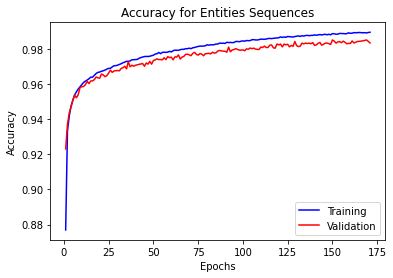

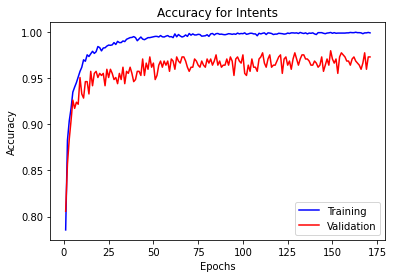

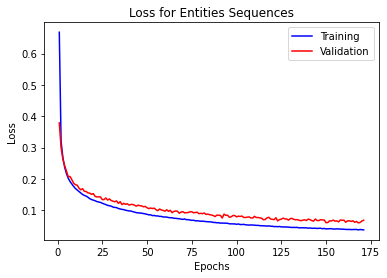

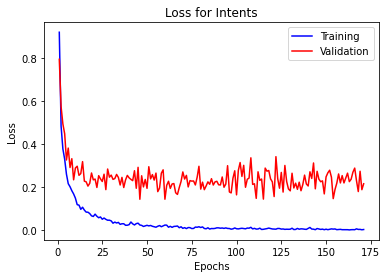

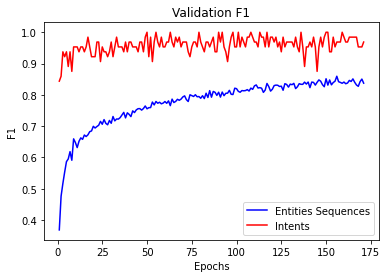

In [14]:
# Se definen funciones para evaluar el resultado del entrenamiento
def plot_training_validation_accuracy(history):
  acc_e = history.history['es_out_sparse_categorical_accuracy']
  val_acc_e = history.history['val_es_out_sparse_categorical_accuracy']

  acc_i = history.history['i_out_sparse_categorical_accuracy']
  val_acc_i = history.history['val_i_out_sparse_categorical_accuracy']

  epochs = range(1, len(acc_e) + 1)

  plt.plot(epochs, acc_e, 'b', label='Training')
  plt.plot(epochs, val_acc_e, 'r', label='Validation')
  plt.title('Accuracy for Entities Sequences')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  plt.plot(epochs, acc_i, 'b', label='Training')
  plt.plot(epochs, val_acc_i, 'r', label='Validation')
  plt.title('Accuracy for Intents')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

def plot_training_validation_loss(history):
  loss_e = history.history['es_out_loss']
  val_loss_e = history.history['val_es_out_loss']

  loss_i = history.history['i_out_loss']
  val_loss_i = history.history['val_i_out_loss']

  epochs = range(1, len(loss_e) + 1)

  plt.plot(epochs, loss_e, 'b', label='Training')
  plt.plot(epochs, val_loss_e, 'r', label='Validation')
  plt.title('Loss for Entities Sequences')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  plt.plot(epochs, loss_i, 'b', label='Training')
  plt.plot(epochs, val_loss_i, 'r', label='Validation')
  plt.title('Loss for Intents')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

def plot_validation_f1(history):
  val_e_f1 = history.history['slots_f1']
  val_i_f1 = history.history['intent_f1']

  epochs = range(1, len(val_e_f1) + 1)
  
  plt.plot(epochs, val_e_f1, 'b', label='Entities Sequences')
  plt.plot(epochs, val_i_f1, 'r', label='Intents')
  plt.title('Validation F1')
  plt.xlabel('Epochs')
  plt.ylabel('F1')
  plt.legend()
  plt.show()
  
plot_training_validation_accuracy(history)
plot_training_validation_loss(history)
plot_validation_f1(history)

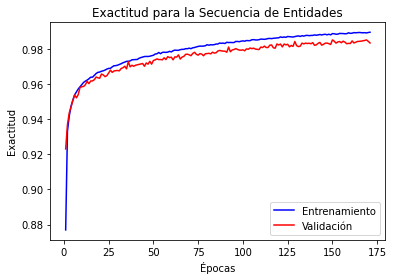

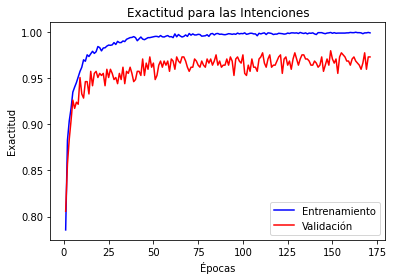

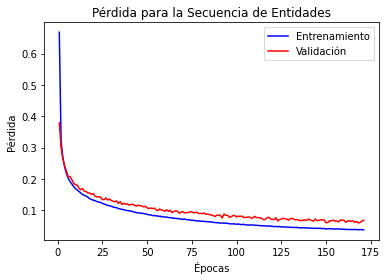

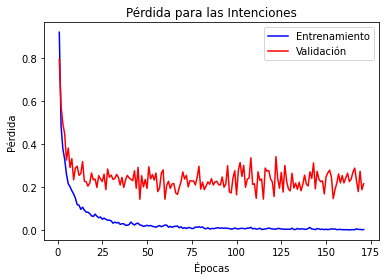

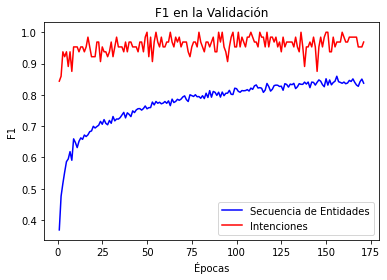

In [15]:
# Se definen funciones para evaluar el resultado del entrenamiento
def plot_training_validation_accuracy(history):
  acc_e = history.history['es_out_sparse_categorical_accuracy']
  val_acc_e = history.history['val_es_out_sparse_categorical_accuracy']

  acc_i = history.history['i_out_sparse_categorical_accuracy']
  val_acc_i = history.history['val_i_out_sparse_categorical_accuracy']

  epochs = range(1, len(acc_e) + 1)

  plt.plot(epochs, acc_e, 'b', label='Entrenamiento')
  plt.plot(epochs, val_acc_e, 'r', label='Validación')
  plt.title('Exactitud para la Secuencia de Entidades')
  plt.xlabel('Épocas')
  plt.ylabel('Exactitud')
  plt.legend()
  plt.show()

  plt.plot(epochs, acc_i, 'b', label='Entrenamiento')
  plt.plot(epochs, val_acc_i, 'r', label='Validación')
  plt.title('Exactitud para las Intenciones')
  plt.xlabel('Épocas')
  plt.ylabel('Exactitud')
  plt.legend()
  plt.show()

def plot_training_validation_loss(history):
  loss_e = history.history['es_out_loss']
  val_loss_e = history.history['val_es_out_loss']

  loss_i = history.history['i_out_loss']
  val_loss_i = history.history['val_i_out_loss']

  epochs = range(1, len(loss_e) + 1)

  plt.plot(epochs, loss_e, 'b', label='Entrenamiento')
  plt.plot(epochs, val_loss_e, 'r', label='Validación')
  plt.title('Pérdida para la Secuencia de Entidades')
  plt.xlabel('Épocas')
  plt.ylabel('Pérdida')
  plt.legend()
  plt.show()

  plt.plot(epochs, loss_i, 'b', label='Entrenamiento')
  plt.plot(epochs, val_loss_i, 'r', label='Validación')
  plt.title('Pérdida para las Intenciones')
  plt.xlabel('Épocas')
  plt.ylabel('Pérdida')
  plt.legend()
  plt.show()

def plot_validation_f1(history):
  val_e_f1 = history.history['slots_f1']
  val_i_f1 = history.history['intent_f1']

  epochs = range(1, len(val_e_f1) + 1)
  
  plt.plot(epochs, val_e_f1, 'b', label='Secuencia de Entidades')
  plt.plot(epochs, val_i_f1, 'r', label='Intenciones')
  plt.title('F1 en la Validación')
  plt.xlabel('Épocas')
  plt.ylabel('F1')
  plt.legend()
  plt.show()
  
plot_training_validation_accuracy(history)
plot_training_validation_loss(history)
plot_validation_f1(history)

In [16]:
# Se guardan los pesos del mejor modelo
!zip -r /content/prepadding_model_weights.zip /content/model-epoch:156-loss:0.042-val_loss:0.283-slots_f1:0.859weights

  adding: content/model-epoch:156-loss:0.042-val_loss:0.283-slots_f1:0.859weights/ (stored 0%)
  adding: content/model-epoch:156-loss:0.042-val_loss:0.283-slots_f1:0.859weights/assets/ (stored 0%)
  adding: content/model-epoch:156-loss:0.042-val_loss:0.283-slots_f1:0.859weights/variables/ (stored 0%)
  adding: content/model-epoch:156-loss:0.042-val_loss:0.283-slots_f1:0.859weights/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/model-epoch:156-loss:0.042-val_loss:0.283-slots_f1:0.859weights/variables/variables.index (deflated 73%)
  adding: content/model-epoch:156-loss:0.042-val_loss:0.283-slots_f1:0.859weights/keras_metadata.pb (deflated 93%)
  adding: content/model-epoch:156-loss:0.042-val_loss:0.283-slots_f1:0.859weights/saved_model.pb (deflated 90%)
